<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/Total/Total_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "fp.pa"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close    Volume
Date                                                       
2009-01-02  38.33  41.00  38.33  41.00      22.82   4915721
2009-01-05  41.68  41.94  40.80  41.70      23.21   7682205
2009-01-06  42.00  42.47  41.35  41.79      23.26   6895659
2009-01-07  41.50  42.10  39.65  40.23      22.40   8883686
2009-01-08  39.78  40.89  39.76  40.67      22.64   5684233
...           ...    ...    ...    ...        ...       ...
2018-12-21  45.90  46.04  45.08  46.04      44.88  13466599
2018-12-24  45.98  46.04  45.23  45.23      44.08   1570694
2018-12-27  46.19  46.19  44.78  45.35      44.20   7100931
2018-12-28  45.56  46.51  45.53  46.08      44.92   5778811
2018-12-31  46.59  46.76  46.16  46.18      45.01   2060626

[2556 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2.556000e+03
mean     42.950051    43.360082    42.517484    42.948345    32.479288  6.223205e+06
std       4.795083     4.792373     4.827171     4.811741     8.294164  2.970581e+06
min      30.250000    30.880000    29.400000    30.380000    19.230000  0.000000e+00
25%      39.240000    39.600000    38.760000    39.190000    25.035000  4.509666e+06
50%      42.565000    42.980000    42.190000    42.600000    32.110000  5.697930e+06
75%      46.280000    46.670000    45.920000    46.290000    38.292500  7.199009e+06
max      56.380000    56.820000    56.070000    56.370000    54.220000  5.608253e+07

7

In [5]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [6]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close    Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2009-03-13  38.22  39.03  37.59  37.88      21.09   7954834   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  37.197134  37.021354  34.652873  37.409714  37.267688  36.929432      36.725      36.875  35.158751  36.99875  37.894944  36.8595  37.264444  36.99875  37.756667  37.468865               38.812322                 36.99875               35.185178               39.719108                 36.99875               34.278392               40.625894                 36.99875               33.371606               41.532680                 36.99875               32.464820  37.267688  37.676417  37.298512               39.081260                37.267688               35.454116               39.988046                37.267688               34.547330               40.894832                37.267688               33.640544               41.801618                37.267688   
2009-03-16  38.41  38.62  37.63  38.18      21.25   7645356   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  37.688567  37.188157  34.915501  37.738573  37.470424  36.952167      36.875      36.875  35.468451  37.06750  38.214068  37.1740  37.526944  37.06750  38.030000  37.409623               39.008782                 37.06750               35.126218               39.979423                 37.06750               34.155577               40.950064                 37.06750               33.184936               41.920704                 37.06750               32.214296  37.470424  38.052488  37.265215               39.411706                37.470424               35.529142               40.382347                37.470424               34.558501               41.352988                37.470424               33.587861               42.323629                37.470424   
2009-03-17  37.87  38.00  37.00  37.83   

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2.506000e+03  2506.000000  2506.000000  2506.000000    2506.000000   2506.000000     2506.000000     2506.000000       2506.000000  2506.000000  2506.000000  2506.000000  2506.000000   2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000   
mean     43.035527    43.440471    42.610686    43.034497    32.698240  6.170025e+06    15.766959     1.999202   186.043496      30.462889      0.032721        0.028332        0.009976          0.007981     6.619314     2.538707    27.001197     1.999202      2.015563    27.001197    43.010327    42.975939     2.425310    43.035411    43.021643    43.035280    42.993992    42.962526    42.858104    43.022243    43.035154    43.022409    43.026478    43.022243    43.031276    42.993850               44.218162                43.022243               41.826323               44.816122                43.022243               41.228363               45.414082                43.022243               40.630403               46.012042                43.022243               40.032443    43.021643    43.031730    42.998017               44.217563                43.021643               41.825724               44.815523                43.021643               41.227764               45.413483   
std       4.796887     4.799602     4.821962     4.812734     8.227514  2.955194e+06     8.737921     1.407706   103.562746       0.785865      0.177942        0.165953        0.099401          0.088996     3.394067     1.106097    14.812238     1.407706      1.412857    14.812238     4.760152     4.677227    43.108486     4.824086     4.748730     4.725051     4.772268     4.774997     4.907993     4.769118     4.823099     4.779243     4.774998     4.769118     4.800843     4.700326                4.810927                 4.769118                4.810003                4.862339                 4.769118                4.860968                4.933327                 4.769118                4.931525                5.023059                 4.769118                5.020847     4.748730     4.793897     4.710268                4.791877                 4.748730                4.788627                4.844066                 4.748730                4.839243                4.915883   
min      30.250000    30.880000    29.

36

In [7]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close    Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2009-03-13  0.305013  0.314187  0.307087  0.288573   0.044143   7954834   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.237407  0.210447  0.815870  0.247599  0.230256  0.185509    0.209278    0.226545  0.210020  0.211478  0.273659  0.215784  0.232469  0.211478  0.278156  0.223859                0.224500                 0.211478                0.205534                0.239435                 0.211478                0.205870                0.251928                 0.211478                0.225273                0.262783                 0.211478                0.242773  0.230256  0.267392  0.217294                0.235586                 0.230256                0.226328                0.245746                 0.230256                0.224522                0.255633                 0.230256                0.241720                0.267382                 0.230256   
2009-03-16  0.312285  0.298381  0.308586  0.300115   0.048759   7645356   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.257483  0.217802  0.818213  0.260601  0.238646  0.186487    0.215464    0.226545  0.221315  0.214334  0.286134  0.228622  0.243166  0.214334  0.288802  0.221259                0.232776                 0.214334                0.203211                0.250163                 0.214334                0.201172                0.264825                 0.214334                0.218499                0.277659                 0.214334                0.234128  0.238646  0.282251  0.215842                0.249638                 0.238646                0.229262                0.261991                 0.238646                0.224947                0.273930                 0.238646                0.239815                0.287542                 0.238646   
2009-03-17  0.291619  0.274480  0.284964  0.2866

140201

In [9]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         3 hours 54 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 8 days
H2O cluster name:           H2O_from_python_unknownUser_1t03yt
H2O cluster total nodes:    1
H2O cluster free memory:    8.98 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_174429_mod...  0.580971  0.790439              0.469221  0.531134  0.282103
1  DeepLearning_grid_1_AutoML_20190827_174429_mod...  0.500000  0.690280              0.500000  0.498566  0.248568
2  DeepLearning_grid_1_AutoML_20190827_174429_mod...  0.500000  0.690331              0.500000  0.498591  0.248593
3  DeepLearning_grid_1_AutoML_20190827_174429_mod...  0.500000  0.690372              0.500000  0.498612  0.248613
4  DeepLearning_grid_1_AutoML_20190827_174429_mod...  0.492912  7.555031              0.468614  0.659291  0.434665
5  DeepLearning_grid_1_AutoML_20190827_174429_mod...  0.487739  0.690374              0.500000  0.498613  0.248615
6              DeepLearning_1_AutoML_20190827_174429  0.485504  1.279668              0.500000  0.537991  0.289434
7  DeepLearning_grid_1_AutoML_20190827_174429_mod...  0.481162  0.773787              0.500000  0.534050  0.285210
8  DeepLearning_grid_1_AutoML_20190827_174429_mod...  0.447190  0.728563              0.482152  0.516106  0.266366
9  DeepLearning_grid_1_AutoML_20190827_174429_mod...  0.440741  0.819135              0.495690  0.546307  0.298452

variable  relative_importance  scaled_importance  percentage
0           CDLABANDONEDBABY             1.000000           1.000000    0.002163
1        CDLGAPSIDESIDEWHITE             0.986779           0.986779    0.002135
2           CDLSTICKSANDWICH             0.979421           0.979421    0.002119
3         CDLEVENINGDOJISTAR             0.963032           0.963032    0.002083
4                  CDLINNECK             0.957784           0.957784    0.002072
...                      ...                  ...                ...         ...
1034               MAVP_24_3             0.401056           0.401056    0.000868
1035             MIDPRICE_30             0.400806           0.400806    0.000867
1036             MIDPRICE_20             0.400303           0.400303    0.000866
1037  BBANDS_upperband_8_1_2             0.400249           0.400249    0.000866
1038             MIDPOINT_20             0.395825           0.395825    0.000856

[1039 rows x 4 columns]

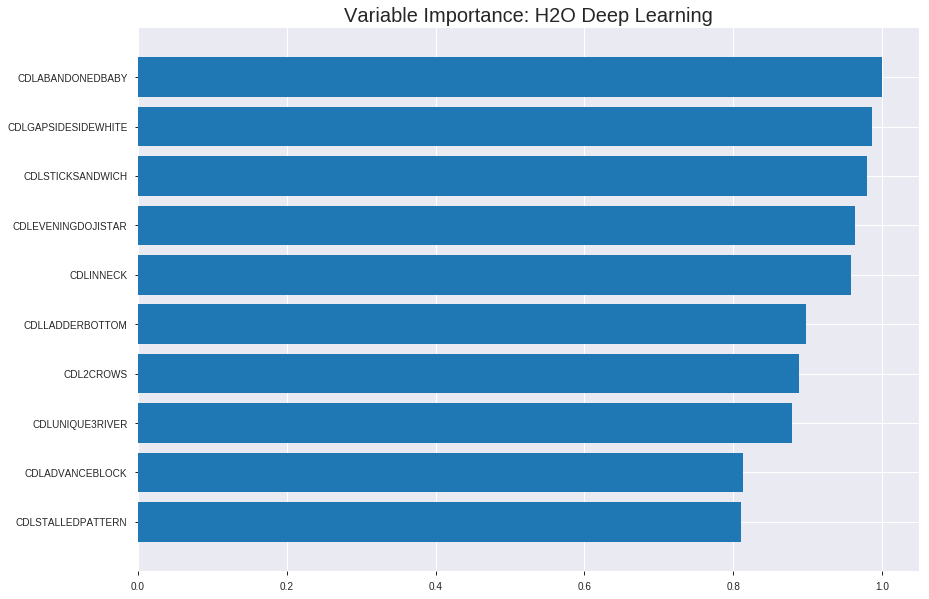

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_174429_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.26453490905050064
RMSE: 0.5143295724051852
LogLoss: 0.9155651088650394
Mean Per-Class Error: 0.3655645668448919
AUC: 0.6749620977864064
pr_auc: 0.6381335992912811
Gini: 0.34992419557281274
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29918207348918413: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      241  593   0.711    (593.0/834.0)
1      71   848   0.0773   (71.0/919.0)
Total  312  1441  0.3788   (664.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.299182     0.718644  303
max f2                       0.132975     0.84844   369
max f0point5                 0.520981     0.652653  217
max accuracy                 0.520981     0.641187  217
max precision                0.99708      0.711111  4
max recall                   0.0263608    1         396
max specificity              0.999723     0.98801   0
max absolute_mcc             0.519119     0.280836  218
max min_per_class_accuracy   0.737943     0.624592  139
max mean_per_class_accuracy  0.520981     0.634435  217

Gains/Lift Table: Avg response rate: 52.42 %, avg score: 65.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.9997             1.58959   1.58959            0.833333         0.999854  0.833333                    0.999854            0.0163221       0.0163221                  58.959     58.959
    2        0.0205362                   0.999321           1.05973   1.32466            0.555556         0.999533  0.694444                    0.999693            0.0108814       0.0272035                  5.97268    32.4658
    3        0.0302339                   0.998498           1.34648   1.33166            0.705882         0.998854  0.698113                    0.999424            0.0130577       0.0402612                  34.6476    33.1657
    4        0.040502                    0.997735           1.27167   1.31645            0.666667         0.998157  0.690141                    0.999103            0.0130577       0.0533188                  27.1672    31.6449
    5        0.0501997                   0.996816           1.45868   1.34393            0.764706         0.997277  0.704545                    0.99875             0.0141458       0.0674646                  45.8683    34.3926
    6        0.100399                    0.990522           1.25722   1.30057            0.659091         0.9939    0.681818                    0.996325            0.0631121       0.130577                   25.7221    30.0574
    7        0.150029                    0.981007           1.40322   1.33453            0.735632         0.986135  0.69962                     0.992954            0.0696409       0.200218                   40.3224    33.453
    8        0.200228                    0.970057           1.12716   1.28254            0.590909         0.976154  0.672365                    0.988742            0.0565832       0.256801                   12.7164    28.2541
    9        0.300057                    0.928937           1.36251   1.30915            0.714286         0.950874  0.686312                    0.976143            0.136017        0.392818                   36.2506    30.9145
    10       0.399886                    0.848572           1.22081   1.28709            0.64             0.890418  0.67475                     0.954743            0.121872        0.51469                    22.0805    28.7092
    11       0.500285                    0.742093           1.07297   1.24412            0.5625           0.797577  0.652223                    0.923202            0.107726        0.622416                   7.29733    24.4122
    12       0.600114                    0.591546           0.991904  1.20217            0.52             0.668855  0.630228                    0.880891            0.0990207       0.721436                   -0.809576  20.2165
    13       0.699943                    0.454723           0.937404  1.1644             0.491429         0.518222  0.610432                    0.829166            0.09358         0.815016                   -6.2596    16.4404
    14       0.799772                    0.322896           0.882904  1.12927            0.462857         0.390969  0.592011                    0.774469            0.0881393       0.903156                   -11.7096   12.9267
    15       0.899601                    0.20925            0.632203  1.07411            0.331429         0.270565  0.563094                    0.718551            0.0631121       0.966268                   -36.7797   7.41073
    16       1                           0.00704107         0.335982  1                  0.176136         0.132833  0.524244                    0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.29382049240304015
RMSE: 0.5420521122577054
LogLoss: 0.8769714488596987
Mean Per-Class Error: 0.4507038873780196
AUC: 0.5452167653175491
pr_auc: 0.5554551212462778
Gini: 0.09043353063509829
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.001296120224528212: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    235  1        (235.0/235.0)
1      0    266  0        (0.0/266.0)
Total  0    501  0.4691   (235.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.00129612   0.693611   399
max f2                       0.00129612   0.84984    399
max f0point5                 0.329643     0.593472   343
max accuracy                 0.614076     0.550898   206
max precision                0.999346     1          0
max recall                   0.00129612   1          399
max specificity              0.999346     1          0
max absolute_mcc             0.614076     0.0985686  206
max min_per_class_accuracy   0.627417     0.545113   197
max mean_per_class_accuracy  0.614076     0.549296   206

Gains/Lift Table: Avg response rate: 53.09 %, avg score: 61.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.994836           0.62782   0.62782            0.333333         0.996726  0.333333                    0.996726            0.0075188       0.0075188                  -37.218   -37.218
    2        0.0219561                   0.987614           1.13008   0.856118           0.6              0.989251  0.454545                    0.993328            0.0112782       0.018797                   13.0075   -14.3882
    3        0.0319361                   0.968945           1.13008   0.941729           0.6              0.977848  0.5                         0.98849             0.0112782       0.0300752                  13.0075   -5.82707
    4        0.0419162                   0.962181           1.50677   1.07626            0.8              0.965227  0.571429                    0.982951            0.0150376       0.0451128                  50.6767   7.62621
    5        0.0518962                   0.955116           0.376692  0.941729           0.2              0.958155  0.5                         0.978183            0.0037594       0.0488722                  -62.3308  -5.82707
    6        0.101796                    0.921842           1.35609   1.14485            0.72             0.935549  0.607843                    0.957284            0.0676692       0.116541                   35.609    14.4847
    7        0.151697                    0.886976           1.05474   1.11521            0.56             0.901678  0.592105                    0.938993            0.0526316       0.169173                   5.47368   11.5206
    8        0.201597                    0.850074           1.05474   1.10024            0.56             0.8698    0.584158                    0.921866            0.0526316       0.221805                   5.47368   10.0238
    9        0.301397                    0.776907           1.13008   1.11012            0.6              0.809693  0.589404                    0.884722            0.112782        0.334586                   13.0075   11.0118
    10       0.401198                    0.710328           0.941729  1.06823            0.5              0.742485  0.567164                    0.84934             0.093985        0.428571                   -5.82707  6.82303
    11       0.500998                    0.627417           1.16774   1.08805            0.62             0.665047  0.577689                    0.812628            0.116541        0.545113                   16.7744   8.80538
    12       0.600798                    0.57443            0.941729  1.06375            0.5              0.60115   0.564784                    0.777499            0.093985        0.639098                   -5.82707  6.37474
    13       0.700599                    0.495601           0.828722  1.03027            0.44             0.535094  0.547009                    0.742968            0.0827068       0.721805                   -17.1278  3.0268
    14       0.800399                    0.400772           0.90406   1.01453            0.48             0.444769  0.538653                    0.705786            0.0902256       0.81203                    -9.59398  1.45313
    15       0.9002                      0.296141           0.941729  1.00646            0.5              0.352474  0.534368                    0.666616            0.093985        0.906015                   -5.82707  0.646016
    16       1                           0.00129612         0.941729  1                  0.5              0.197544  0.530938                    0.619803      


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 17:50:14  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 17:50:17  5.889 sec         143 obs/sec       0.275528  1             483        0.654527         2.46448             -0.717663      0.535699        0.560924           1.27167          0.475756                         0.705304           3.01621               -0.997462        0.494641          0.516989             0.62782            0.469062
    2019-08-27 17:50:42  30.791 sec        150 obs/sec       2.21848   8             3889       0.634436         2.29533             -0.613829      0.530976        0.471345           1.37764          0.475756                         0.683494           3.89178               -0.87584         0.456407          0.478217             0.62782            0.469062
    2019-08-27 17:51:08  56.472 sec        159 obs/sec       4.45807   16            7815       0.572049         1.48727             -0.312043      0.577534        0.512899           1.05973          0.447233                         0.63186            2.06662               -0.603125        0.475892          0.495567             0.941729           0.469062
    2019-08-27 17:51:33  1 min 21.738 sec  162 obs/sec       6.6834    24            11716      0.611712         2.02608             -0.500294      0.601313        0.517076           1.48362          0.44267                          0.647011           1.67201               -0.680929        0.504039          0.541342             0.62782            0.46507
    2019-08-27 17:51:59  1 min 47.076 sec  170 obs/sec       9.23103   33            16182      0.564839         1.39447             -0.279179      0.627907        0.568794           1.05973          0.472904                         0.592379           1.16419               -0.409046        0.536458          0.561521             0.62782            0.469062
    2019-08-27 17:52:23  2 min 11.417 sec  176 obs/sec       11.7627   42            20620      0.51433          0.915565            -0.0606333     0.674962        0.638134           1.58959          0.378779                         0.542052           0.876971              -0.179799        0.545217          0.555455             0.62782            0.469062
    2019-08-27 17:52:48  2 min 36.622 sec  182 obs/sec       14.5174   52            25449      0.489498         0.797432            0.0393099      0.7088          0.659462           1.37764          0.351968                         0.595321           1.06929               -0.423077        0.498744          0.545115             1.25564            0.469062
    2019-08-27 17:53:13  3 min  1.677 sec  187 obs/sec       17.3155   62            30354      0.448442         0.589531            0.193705       0.765732        0.776702           1.90751          0.308614                         0.554746           0.882838              -0.235703        0.501704          0.539759             1.25564            0.469062
    2019-08-27 17:53:38 

Variable Importances: 


variable                relative_importance    scaled_importance    percentage
----------------------  ---------------------  -------------------  ---------------------
CDLABANDONEDBABY        1.0                    1.0                  0.002163255691470661
CDLGAPSIDESIDEWHITE     0.986778974533081      0.986778974533081    0.00213465523288227
CDLSTICKSANDWICH        0.9794214963912964     0.9794214963912964   0.0021187391264171833
CDLEVENINGDOJISTAR      0.9630321860313416     0.9630321860313416   0.002083284857501732
CDLINNECK               0.9577836394309998     0.9577836394309998   0.0020719309091965935
---                     ---                    ---                  ---
MAVP_24_3               0.4010563790798187     0.4010563790798187   0.0008675874946450328
MIDPRICE_30             0.40080565214157104    0.40080565214157104  0.0008670451081688635
MIDPRICE_20             0.4003034234046936     0.4003034234046936   0.0008659586589953932
BBANDS_upperband_8_1_2  0.4002494513988495     0.4002494513988495   0.0008658419037465709
MIDPOINT_20             0.3958248794078827     0.3958248794078827   0.0008562704232047902


See the whole table with table.as_data_frame()


('accuracy', 0.5896414342629482)

('F1', 0.7108753315649868)

('auc', 0.580970625798212)

('logloss', 0.7904385451599242)

('mean_per_class_error', 0.4113346104725415)

('rmse', 0.5311336238160584)

('mse', 0.2821029263479783)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


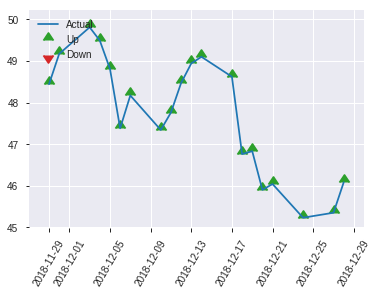


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2821029263479783
RMSE: 0.5311336238160584
LogLoss: 0.7904385451599242
Mean Per-Class Error: 0.4113346104725415
AUC: 0.580970625798212
pr_auc: 0.6063403672437427
Gini: 0.16194125159642403
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.05128161510544504: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    108  0.931    (108.0/116.0)
1      1    134  0.0074   (1.0/135.0)
Total  9    242  0.4343   (109.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0512816    0.710875  241
max f2                       0.0512816    0.856777  241
max f0point5                 0.261792     0.620023  185
max accuracy                 0.267763     0.589641  183
max precision                0.981818     1         0
max recall                   0.00854103   1         247
max specificity              0.981818     1         0
max absolute_mcc             0.437004     0.179475  103
max min_per_class_accuracy   0.400725     0.568966  126
max mean_per_class_accuracy  0.437004     0.588665  103

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 40.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.957884           1.23951   1.23951            0.666667         0.972589   0.666667                    0.972589            0.0148148       0.0148148                  23.9506   23.9506
    2        0.0239044                   0.89086            1.85926   1.54938            1                0.916126   0.833333                    0.944357            0.0222222       0.037037                   85.9259   54.9383
    3        0.0318725                   0.871775           1.85926   1.62685            1                0.887738   0.875                       0.930203            0.0148148       0.0518519                  85.9259   62.6852
    4        0.0438247                   0.840481           1.85926   1.69024            1                0.847707   0.909091                    0.907704            0.0222222       0.0740741                  85.9259   69.0236
    5        0.0517928                   0.794829           0.92963   1.57322            0.5              0.796217   0.846154                    0.890552            0.00740741      0.0814815                  -7.03704  57.3219
    6        0.103586                    0.692955           0.7151    1.14416            0.384615         0.742664   0.615385                    0.816608            0.037037        0.118519                   -28.49    14.416
    7        0.151394                    0.625224           1.08457   1.12534            0.583333         0.659596   0.605263                    0.767025            0.0518519       0.17037                    8.45679   12.5341
    8        0.203187                    0.570766           0.7151    1.02077            0.384615         0.598956   0.54902                     0.724184            0.037037        0.207407                   -28.49    2.07698
    9        0.302789                    0.494488           1.18993   1.07641            0.64             0.523483   0.578947                    0.658164            0.118519        0.325926                   18.9926   7.64133
    10       0.40239                     0.442348           1.56178   1.19655            0.84             0.462476   0.643564                    0.609726            0.155556        0.481481                   56.1778   19.6553
    11       0.501992                    0.403317           0.818074  1.12146            0.44             0.422578   0.603175                    0.572594            0.0814815       0.562963                   -18.1926  12.1458
    12       0.601594                    0.344806           0.892444  1.08354            0.48             0.373277   0.582781                    0.539594            0.0888889       0.651852                   -10.7556  8.35418
    13       0.701195                    0.296052           0.966815  1.06696            0.52             0.317598   0.573864                    0.508061            0.0962963       0.748148                   -3.31852  6.69613
    14       0.800797                    0.199742           1.11556   1.07301            0.6              0.246484   0.577114                    0.475526            0.111111        0.859259                   11.5556   7.30053
    15       0.900398                    0.118228           0.743704  1.03658            0.4              0.157844   0.557522                    0.440385            0.0740741       0.933333                   -25.6296  3.65782
    16       1                           0.000656893        0.669333  1                  0.36             0.0635399  0.537849                    

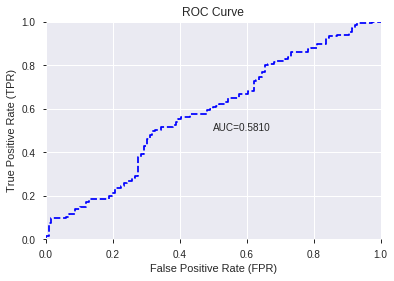

This function is available for GLM models only


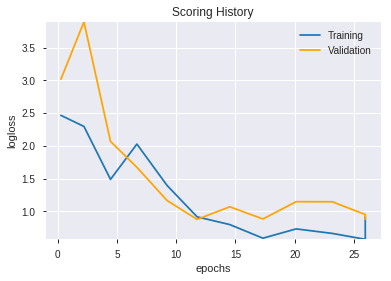

--2019-08-27 18:10:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.100.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.100.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_174429_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_174429_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_9b73',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [11]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_181032_model_9  0.549425  0.702843              0.468008  0.502516  0.252522
1  DeepLearning_grid_1_AutoML_20190827_181032_model_4  0.532120  2.582359              0.468008  0.603466  0.364171
2  DeepLearning_grid_1_AutoML_20190827_181032_model_1  0.530651  1.447750              0.495690  0.576913  0.332829
3  DeepLearning_grid_1_AutoML_20190827_181032_model_5  0.525032  0.779824              0.468008  0.522675  0.273189
4               DeepLearning_1_AutoML_20190827_181032  0.514240  0.931350              0.482152  0.529910  0.280804
5  DeepLearning_grid_1_AutoML_20190827_181032_model_2  0.512835  1.494668              0.472925  0.585861  0.343233
6  DeepLearning_grid_1_AutoML_20190827_181032_model_6  0.511814  0.694924              0.495690  0.500909  0.250910
7  DeepLearning_grid_1_AutoML_20190827_181032_model_3  0.503065  1.122765              0.463697  0.573141  0.328490
8  DeepLearning_grid_1_AutoML_20190827_181032_model_8  0.489017  0.691674              0.495690  0.499263  0.249264
9  DeepLearning_grid_1_AutoML_20190827_181032_model_7  0.444732  1.061422              0.500000  0.580698  0.337210

variable  relative_importance  scaled_importance  percentage
0                   day             1.000000           1.000000    0.027305
1               weekday             0.939598           0.939598    0.025656
2             CORREL_12             0.882384           0.882384    0.024094
3             dayofweek             0.874357           0.874357    0.023874
4               CDLDOJI             0.852788           0.852788    0.023285
5                   BOP             0.843427           0.843427    0.023030
6                  SINH             0.831263           0.831263    0.022698
7                   EXP             0.798462           0.798462    0.021802
8             CDLHAMMER             0.785994           0.785994    0.021462
9          weekday_name             0.784232           0.784232    0.021414
10                 COSH             0.782174           0.782174    0.021357
11      CDLHOMINGPIGEON             0.780029           0.780029    0.021299
12              BETA_30             0.775250           0.775250    0.021168
13          CDLPIERCING             0.773910           0.773910    0.021132
14     is_quarter_start             0.747058           0.747058    0.020398
15    CDLSTALLEDPATTERN             0.742478           0.742478    0.020273
16       CDLMORNINGSTAR             0.741086           0.741086    0.020235
17    CDLDARKCLOUDCOVER             0.741046           0.741046    0.020234
18       CDLMATCHINGLOW             0.739540           0.739540    0.020193
19       is_month_start             0.735349           0.735349    0.020079
20       CDLEVENINGSTAR             0.733891           0.733891    0.020039
21       is_quarter_end             0.730527           0.730527    0.019947
22         HT_TRENDMODE             0.728270           0.728270    0.019885
23        CDLHANGINGMAN             0.727300           0.727300    0.019859
24            CDL2CROWS             0.725377           0.725377    0.019806
25    CDLINVERTEDHAMMER             0.725030           0.725030    0.019797
26            CDLONNECK             0.722478           0.722478    0.019727
27         CDLTHRUSTING             0.721574           0.721574    0.019703
28       CDLRICKSHAWMAN             0.720853           0.720853    0.019683
29         is_month_end             0.720140           0.720140    0.019663
30      CDLADVANCEBLOCK             0.716701           0.716701    0.019570
31    CDLGRAVESTONEDOJI             0.707047           0.707047    0.019306
32      CDLSHOOTINGSTAR             0.705217           0.705217    0.019256
33       STOCHRSI_fastk             0.703502           0.703502    0.019209
34            CDLTAKURI             0.702252           0.702252    0.019175
35      CDLUNIQUE3RIVER             0.693399           0.693399    0.018933
36   CDLMORNINGDOJISTAR             0.690939           0.690939    0.018866
37  CDLGAPSIDESIDEWHITE             0.679072           0.679072    0.018542
38            CORREL_14             0.678115           0.678115    0.018516
39     CDLSTICKSANDWICH             0.677178           0.677178    0.018490
40            CDLINNECK             0.667445           0.667445    0.018225
41     CDLDRAGONFLYDOJI             0.659512           0.659512    0.018008
42      CDLLADDERBOTTOM             0.656492           0.656492    0.017926
43        days_in_month             0.655398           0.655398    0.017896
44     CDLABANDONEDBABY             0.636672           0.636672    0.017384
45   CDLEVENINGDOJISTAR             0.625444           0.625444    0.017078
46           CDL3INSIDE             0.622566           0.622566    0.016999
47   CDLSEPARATINGLINES             0.615305           0.615305    0.016801
48          CDLDOJISTAR             0.565354           0.565354    0.015437
49         CDLTASUKIGAP             0.559774           0.559774    0.015285

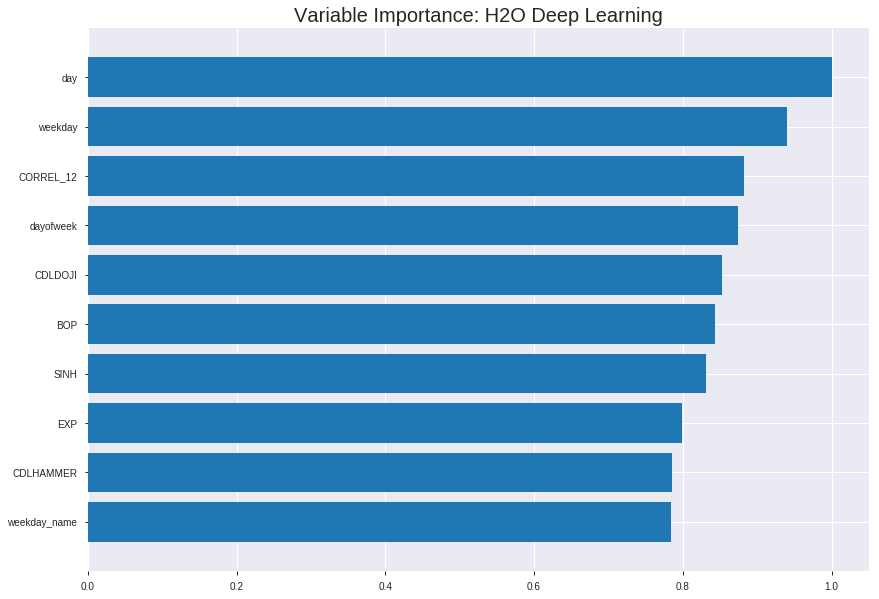

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_181032_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24409142635316605
RMSE: 0.49405609636271675
LogLoss: 0.6808755529346147
Mean Per-Class Error: 0.441346161373404
AUC: 0.5754795510707865
pr_auc: 0.6104760488563504
Gini: 0.15095910214157304
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4430266540796528: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      11   823   0.9868   (823.0/834.0)
1      2    917   0.0022   (2.0/919.0)
Total  13   1740  0.4706   (825.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.443027     0.689733  387
max f2                       0.443027     0.846566  387
max f0point5                 0.509515     0.587225  287
max accuracy                 0.522996     0.561323  243
max precision                0.76052      1         0
max recall                   0.395026     1         398
max specificity              0.76052      1         0
max absolute_mcc             0.654917     0.141622  75
max min_per_class_accuracy   0.524612     0.552775  236
max mean_per_class_accuracy  0.522996     0.558654  243

Gains/Lift Table: Avg response rate: 52.42 %, avg score: 53.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.736024           1.80154   1.80154            0.944444         0.747276  0.944444                    0.747276            0.0184984       0.0184984                  80.1535    80.1535
    2        0.0205362                   0.721216           1.37764   1.58959            0.722222         0.726679  0.833333                    0.736977            0.0141458       0.0326442                  37.7645    58.959
    3        0.0302339                   0.709331           1.34648   1.51161            0.705882         0.715688  0.792453                    0.730149            0.0130577       0.0457018                  34.6476    51.161
    4        0.040502                    0.691325           1.37764   1.47765            0.722222         0.698992  0.774648                    0.72225             0.0141458       0.0598477                  37.7645    47.7647
    5        0.0501997                   0.682456           1.45868   1.47398            0.764706         0.68651   0.772727                    0.715346            0.0141458       0.0739935                  45.8683    47.3984
    6        0.100399                    0.619071           1.25722   1.3656             0.659091         0.653328  0.715909                    0.684337            0.0631121       0.137106                   25.7221    36.5602
    7        0.150029                    0.574278           1.11819   1.28376            0.586207         0.594009  0.673004                    0.654457            0.0554951       0.192601                   11.8194    28.376
    8        0.200228                    0.544338           0.97543   1.20646            0.511364         0.558124  0.632479                    0.630305            0.0489663       0.241567                   -2.45697   20.6458
    9        0.300057                    0.530878           1.0355    1.14958            0.542857         0.534945  0.602662                    0.598579            0.103373        0.34494                    3.55044    14.9582
    10       0.399886                    0.527443           0.991904  1.11022            0.52             0.529089  0.582026                    0.581231            0.0990207       0.443961                   -0.809576  11.0219
    11       0.500285                    0.524586           1.08381   1.10492            0.568182         0.526007  0.579247                    0.570148            0.108814        0.552775                   8.38115    10.4919
    12       0.600114                    0.521488           0.981004  1.08431            0.514286         0.523126  0.568441                    0.562326            0.0979325       0.650707                   -1.89958   8.4306
    13       0.699943                    0.517626           0.839304  1.04936            0.44             0.519796  0.550122                    0.55626             0.0837867       0.734494                   -16.0696   4.93627
    14       0.799772                    0.507491           0.959204  1.03811            0.502857         0.512869  0.544223                    0.550844            0.0957563       0.83025                    -4.07959   3.81089
    15       0.899601                    0.492701           0.872004  1.01968            0.457143         0.500176  0.534559                    0.545222            0.0870511       0.917301                   -12.7996   1.96762
    16       1                           0.34556            0.823697  1                  0.431818         0.473677  0.524244                    0.53



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24544026094142865
RMSE: 0.495419277926716
LogLoss: 0.6839892089253923
Mean Per-Class Error: 0.4347144456886898
AUC: 0.5757318828987362
pr_auc: 0.5986408735531404
Gini: 0.15146376579747245
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4943155764098046: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      27   208  0.8851   (208.0/235.0)
1      12   254  0.0451   (12.0/266.0)
Total  39   462  0.4391   (220.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.494316     0.697802  362
max f2                       0.426692     0.84984   399
max f0point5                 0.494316     0.600757  362
max accuracy                 0.525729     0.562874  198
max precision                0.815873     1         0
max recall                   0.426692     1         399
max specificity              0.815873     1         0
max absolute_mcc             0.553154     0.13588   90
max min_per_class_accuracy   0.524829     0.553191  209
max mean_per_class_accuracy  0.525729     0.565286  198

Gains/Lift Table: Avg response rate: 53.09 %, avg score: 54.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.763036           1.56955   1.56955            0.833333         0.77965   0.833333                    0.77965             0.018797        0.018797                   56.9549   56.9549
    2        0.0219561                   0.734149           1.13008   1.36979            0.6              0.741415  0.727273                    0.762271            0.0112782       0.0300752                  13.0075   36.9788
    3        0.0319361                   0.714424           0.753383  1.17716            0.4              0.719416  0.625                       0.748879            0.0075188       0.037594                   -24.6617  17.7162
    4        0.0419162                   0.704521           1.13008   1.16595            0.6              0.707431  0.619048                    0.73901             0.0112782       0.0488722                  13.0075   16.5951
    5        0.0518962                   0.687158           1.13008   1.15905            0.6              0.694532  0.615385                    0.730457            0.0112782       0.0601504                  13.0075   15.9051
    6        0.101796                    0.63882            1.28075   1.21871            0.68             0.660257  0.647059                    0.696045            0.0639098       0.12406                    28.0752   21.8709
    7        0.151697                    0.587839           1.43143   1.28868            0.76             0.608132  0.684211                    0.667126            0.0714286       0.195489                   43.1429   28.8682
    8        0.201597                    0.548485           0.90406   1.19348            0.48             0.560398  0.633663                    0.640708            0.0451128       0.240602                   -9.59398  19.3479
    9        0.301397                    0.53211            1.13008   1.17248            0.6              0.537414  0.622517                    0.606505            0.112782        0.353383                   13.0075   17.2484
    10       0.401198                    0.528265           1.05474   1.14319            0.56             0.529873  0.606965                    0.587442            0.105263        0.458647                   5.47368   14.3194
    11       0.500998                    0.524837           0.979398  1.11057            0.52             0.52619   0.589641                    0.575241            0.0977444       0.556391                   -2.06015  11.0565
    12       0.600798                    0.52122            0.941729  1.08252            0.5              0.522983  0.574751                    0.56656             0.093985        0.650376                   -5.82707  8.25194
    13       0.700599                    0.517429           0.866391  1.05173            0.46             0.519477  0.558405                    0.559853            0.0864662       0.736842                   -13.3609  5.17319
    14       0.800399                    0.50864            0.941729  1.03802            0.5              0.513592  0.551122                    0.554085            0.093985        0.830827                   -5.82707  3.80159
    15       0.9002                      0.496545           0.979398  1.03152            0.52             0.503271  0.547672                    0.548451            0.0977444       0.928571                   -2.06015  3.15173
    16       1                           0.426692           0.715714  1                  0.38             0.484006  0.530938                    0.54202          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:16:35  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 18:16:37  2 min 10.151 sec  443 obs/sec       0.636623  1             1116       0.651591         1.41449             -0.702286      0.522648        0.546509           1.37764          0.473474                         0.644019           1.36517               -0.665416        0.540338          0.5626               1.25564            0.463074
    2019-08-27 18:16:46  2 min 19.127 sec  838 obs/sec       5.05647   8             8864       0.499412         0.691973            -1.75056e-06   0.520432        0.531688           0.847781         0.475185                         0.499092           0.691331              -0.000199622     0.480891          0.530404             0.62782            0.467066
    2019-08-27 18:16:55  2 min 28.302 sec  1002 obs/sec      10.7986   17            18930      0.499701         0.69255             -0.00115901    0.513014        0.538964           0.847781         0.474615                         0.49959            0.692327              -0.00219755      0.546873          0.561111             1.25564            0.46507
    2019-08-27 18:17:04  2 min 37.245 sec  1077 obs/sec      16.5642   26            29037      0.498985         0.691115            0.00170894     0.552038        0.588336           1.37764          0.472333                         0.498614           0.690374              0.00171326       0.540889          0.579679             1.25564            0.467066
    2019-08-27 18:17:14  2 min 46.441 sec  1137 obs/sec      22.8699   36            40091      0.497605         0.688339            0.00722222     0.573796        0.592977           1.1657           0.472333                         0.498001           0.689105              0.00416534       0.566533          0.589148             1.56955            0.467066
    2019-08-27 18:17:23  2 min 55.708 sec  1172 obs/sec      29.2042   46            51195      0.495761         0.684517            0.0145681      0.579826        0.609071           1.48362          0.473474                         0.496948           0.686958              0.00837384       0.555743          0.588888             1.25564            0.467066
    2019-08-27 18:17:32  3 min  4.437 sec  1209 obs/sec      35.502    56            62235      0.494056         0.680876            0.0213333      0.57548         0.610476           1.80154          0.470622                         0.495419           0.683989              0.0144657        0.575732          0.598641             1.56955            0.439122

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
day                 1.0                    1.0                  0.027305060983311643
weekday             0.9395983219146729     0.9395983219146729   0.025655789479697426
CORREL_12           0.8823838829994202     0.8823838829994202   0.02409354573599049
dayofweek           0.8743566870689392     0.8743566870689392   0.023874362661583718
CDLDOJI             0.8527877330780029     0.8527877330780029   0.023285421057514962
---                 ---                    ---                  ---
CDLEVENINGDOJISTAR  0.6254439949989319     0.6254439949989319   0.017077786425091897
CDL3INSIDE          0.6225661635398865     0.6225661635398865   0.016999207061602968
CDLSEPARATINGLINES  0.6153048872947693     0.6153048872947693   0.016800937470913373
CDLDOJISTAR         0.5653539896011353     0.5653539896011353   0.015437025163217533
CDLTASUKIGAP        0.5597741603851318     0.5597741603851318   0.015284667586198097


See the whole table with table.as_data_frame()


('accuracy', 0.5697211155378487)

('F1', 0.707774798927614)

('auc', 0.5494252873563219)

('logloss', 0.702843240571031)

('mean_per_class_error', 0.4471583652618135)

('rmse', 0.5025158331397138)

('mse', 0.2525221625561007)

deeplearning prediction progress: |███████████████████████████████████████| 100%


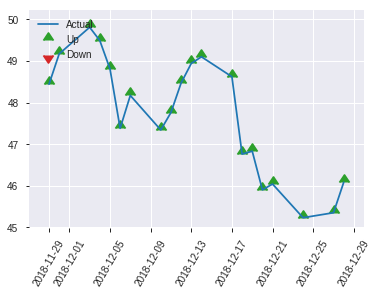


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2525221625561007
RMSE: 0.5025158331397138
LogLoss: 0.702843240571031
Mean Per-Class Error: 0.4471583652618135
AUC: 0.5494252873563219
pr_auc: 0.580615103122931
Gini: 0.0988505747126438
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18434880379837792: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   106  0.9138   (106.0/116.0)
1      3    132  0.0222   (3.0/135.0)
Total  13   238  0.4343   (109.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.184349     0.707775  237
max f2                       0.0373018    0.855513  248
max f0point5                 0.272455     0.609185  232
max accuracy                 0.292771     0.569721  228
max precision                0.73602      1         0
max recall                   0.0373018    1         248
max specificity              0.73602      1         0
max absolute_mcc             0.272455     0.144987  232
max min_per_class_accuracy   0.502125     0.525926  123
max mean_per_class_accuracy  0.515346     0.552842  89

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 47.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.719361           1.23951   1.23951            0.666667         0.727978  0.666667                    0.727978            0.0148148       0.0148148                  23.9506   23.9506
    2        0.0239044                   0.676543           1.85926   1.54938            1                0.698491  0.833333                    0.713235            0.0222222       0.037037                   85.9259   54.9383
    3        0.0318725                   0.664358           0         1.16204            0                0.670244  0.625                       0.702487            0               0.037037                   -100      16.2037
    4        0.0438247                   0.634395           1.85926   1.35219            1                0.644252  0.727273                    0.686605            0.0222222       0.0592593                  85.9259   35.2189
    5        0.0517928                   0.621551           0.92963   1.28718            0.5              0.625041  0.692308                    0.677133            0.00740741      0.0666667                  -7.03704  28.7179
    6        0.103586                    0.568113           0.85812   1.07265            0.461538         0.601407  0.576923                    0.63927             0.0444444       0.111111                   -14.188   7.26496
    7        0.151394                    0.530954           1.23951   1.12534            0.666667         0.547575  0.605263                    0.610314            0.0592593       0.17037                    23.9506   12.5341
    8        0.203187                    0.526623           0.85812   1.05723            0.461538         0.528296  0.568627                    0.589407            0.0444444       0.214815                   -14.188   5.72259
    9        0.302789                    0.519175           1.11556   1.07641            0.6              0.523115  0.578947                    0.5676              0.111111        0.325926                   11.5556   7.64133
    10       0.40239                     0.511927           1.18993   1.10451            0.64             0.515366  0.594059                    0.554671            0.118519        0.444444                   18.9926   10.451
    11       0.501992                    0.500288           0.818074  1.04768            0.44             0.505376  0.563492                    0.54489             0.0814815       0.525926                   -18.1926  4.76778
    12       0.601594                    0.487527           0.966815  1.03429            0.52             0.49362   0.556291                    0.536402            0.0962963       0.622222                   -3.31852  3.42899
    13       0.701195                    0.464297           1.04119   1.03527            0.56             0.476503  0.556818                    0.527893            0.103704        0.725926                   4.11852   3.52694
    14       0.800797                    0.434815           0.966815  1.02676            0.52             0.451332  0.552239                    0.518371            0.0962963       0.822222                   -3.31852  2.67551
    15       0.900398                    0.310059           1.04119   1.02835            0.56             0.390383  0.553097                    0.504213            0.103704        0.925926                   4.11852   2.83514
    16       1                           0.0175817          0.743704  1                  0.4              0.177908  0.537849                    0.471712          

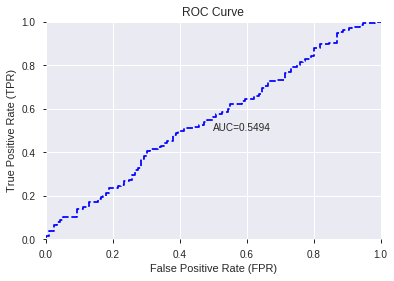

This function is available for GLM models only


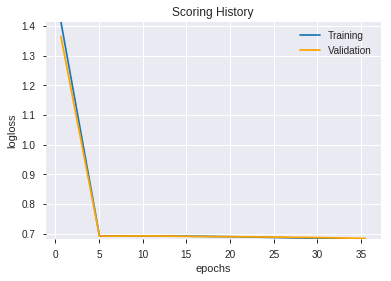

--2019-08-27 18:17:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.32.84
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.32.84|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_181032_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_181032_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_9b73',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['day',
 'weekday',
 'CORREL_12',
 'dayofweek',
 'CDLDOJI',
 'BOP',
 'SINH',
 'EXP',
 'CDLHAMMER',
 'weekday_name',
 'COSH',
 'CDLHOMINGPIGEON',
 'BETA_30',
 'CDLPIERCING',
 'is_quarter_start',
 'CDLSTALLEDPATTERN',
 'CDLMORNINGSTAR',
 'CDLDARKCLOUDCOVER',
 'CDLMATCHINGLOW',
 'is_month_start',
 'CDLEVENINGSTAR',
 'is_quarter_end',
 'HT_TRENDMODE',
 'CDLHANGINGMAN',
 'CDL2CROWS',
 'CDLINVERTEDHAMMER',
 'CDLONNECK',
 'CDLTHRUSTING',
 'CDLRICKSHAWMAN',
 'is_month_end',
 'CDLADVANCEBLOCK',
 'CDLGRAVESTONEDOJI',
 'CDLSHOOTINGSTAR',
 'STOCHRSI_fastk',
 'CDLTAKURI',
 'CDLUNIQUE3RIVER',
 'CDLMORNINGDOJISTAR',
 'CDLGAPSIDESIDEWHITE',
 'CORREL_14',
 'CDLSTICKSANDWICH',
 'CDLINNECK',
 'CDLDRAGONFLYDOJI',
 'CDLLADDERBOTTOM',
 'days_in_month',
 'CDLABANDONEDBABY',
 'CDLEVENINGDOJISTAR',
 'CDL3INSIDE',
 'CDLSEPARATINGLINES',
 'CDLDOJISTAR',
 'CDLTASUKIGAP']

In [12]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_181745_model_1  0.529438  0.687522              0.459994  0.497488  0.247495

variable  relative_importance  scaled_importance  percentage
0                   day             0.061303           1.000000    0.059766
1                   BOP             0.052955           0.863828    0.051627
2    CDLEVENINGDOJISTAR             0.049083           0.800662    0.047852
3             CORREL_12             0.043532           0.710113    0.042441
4             CDLINNECK             0.041221           0.672410    0.040187
5      is_quarter_start             0.040764           0.664961    0.039742
6       CDLUNIQUE3RIVER             0.040061           0.653498    0.039057
7               CDLDOJI             0.039489           0.644164    0.038499
8         CDLHANGINGMAN             0.037282           0.608166    0.036348
9          CDLTASUKIGAP             0.035863           0.585006    0.034963
10            dayofweek             0.034022           0.554983    0.033169
11              weekday             0.033992           0.554488    0.033139
12       is_quarter_end             0.030885           0.503815    0.030111
13       CDLEVENINGSTAR             0.030552           0.498376    0.029786
14       CDLMATCHINGLOW             0.029717           0.484751    0.028972
15            CDLHAMMER             0.029673           0.484041    0.028929
16         weekday_name             0.028975           0.472645    0.028248
17           CDL3INSIDE             0.028203           0.460051    0.027495
18     CDLABANDONEDBABY             0.025847           0.421627    0.025199
19              BETA_30             0.024730           0.403408    0.024110
20    CDLGRAVESTONEDOJI             0.023626           0.385393    0.023033
21         HT_TRENDMODE             0.022054           0.359759    0.021501
22       is_month_start             0.021730           0.354472    0.021185
23      CDLHOMINGPIGEON             0.020869           0.340427    0.020346
24            CDL2CROWS             0.018953           0.309173    0.018478
25            CDLTAKURI             0.018295           0.298433    0.017836
26      CDLADVANCEBLOCK             0.015106           0.246417    0.014727
27         CDLTHRUSTING             0.013519           0.220533    0.013180
28  CDLGAPSIDESIDEWHITE             0.013508           0.220353    0.013170
29          CDLPIERCING             0.011629           0.189703    0.011338
30    CDLSTALLEDPATTERN             0.010902           0.177841    0.010629
31        days_in_month             0.010702           0.174573    0.010434
32   CDLMORNINGDOJISTAR             0.010475           0.170865    0.010212
33   CDLSEPARATINGLINES             0.010408           0.169784    0.010147
34            CORREL_14             0.009060           0.147790    0.008833
35         is_month_end             0.007979           0.130155    0.007779
36          CDLDOJISTAR             0.006710           0.109453    0.006542
37    CDLINVERTEDHAMMER             0.006274           0.102348    0.006117
38     CDLDRAGONFLYDOJI             0.005774           0.094182    0.005629
39       CDLRICKSHAWMAN             0.004958           0.080881    0.004834
40       CDLMORNINGSTAR             0.004582           0.074740    0.004467
41    CDLDARKCLOUDCOVER             0.003587           0.058505    0.003497
42       STOCHRSI_fastk             0.003320           0.054154    0.003237
43                  EXP             0.003148           0.051350    0.003069
44                 COSH             0.003102           0.050600    0.003024
45            CDLONNECK             0.003078           0.050214    0.003001
46                 SINH             0.003074           0.050138    0.002997
47     CDLSTICKSANDWICH             0.000609           0.009934    0.000594
48      CDLSHOOTINGSTAR             0.000344           0.005611    0.000335
49      CDLLADDERBOTTOM             0.000195           0.003175    0.000190

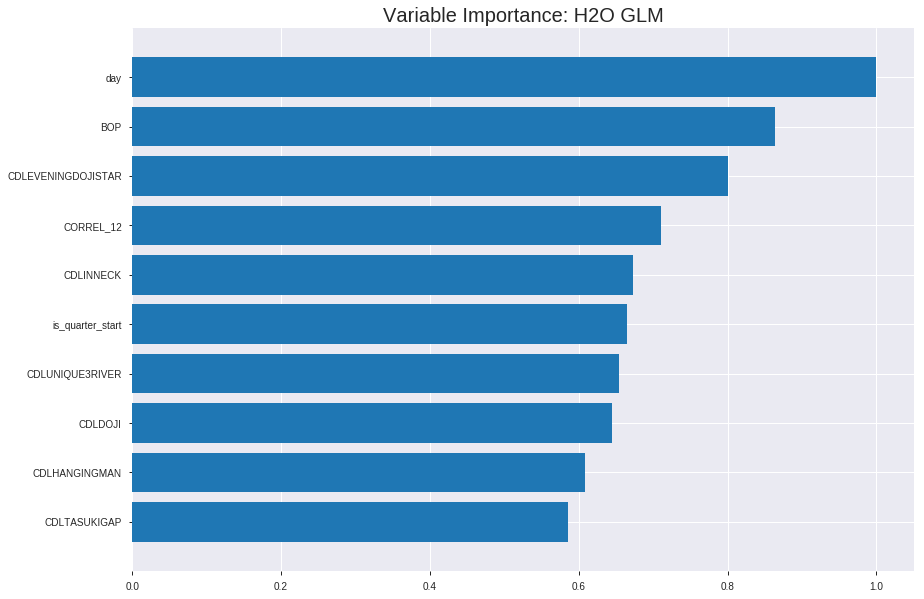

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_181745_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24438291967994527
RMSE: 0.49435100857583497
LogLoss: 0.6816684872114332
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2426.050892509706
Residual deviance: 2389.929716163285
AIC: 2491.929716163285
AUC: 0.5790825446280625
pr_auc: 0.6025020885411994
Gini: 0.15816508925612505
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4455312234022103: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      47   787   0.9436   (787.0/834.0)
1      16   903   0.0174   (16.0/919.0)
Total  63   1690  0.4581   (803.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.445531     0.692219  349
max f2                       0.367362     0.847035  383
max f0point5                 0.504444     0.590584  246
max accuracy                 0.506718     0.559612  240
max precision                0.80539      1         0
max recall                   0.318444     1         395
max specificity              0.80539      1         0
max absolute_mcc             0.535658     0.127968  162
max min_per_class_accuracy   0.526253     0.55036   190
max mean_per_class_accuracy  0.535658     0.562608  162

Gains/Lift Table: Avg response rate: 52.42 %, avg score: 52.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.640166           1.58959   1.58959            0.833333         0.673697  0.833333                    0.673697            0.0163221       0.0163221                  58.959    58.959
    2        0.0205362                   0.625192           1.37764   1.48362            0.722222         0.63061   0.777778                    0.652153            0.0141458       0.0304679                  37.7645   48.3617
    3        0.0302339                   0.608074           1.45868   1.47562            0.764706         0.615251  0.773585                    0.640317            0.0141458       0.0446137                  45.8683   47.562
    4        0.040502                    0.592954           0.847781  1.31645            0.444444         0.600855  0.690141                    0.630312            0.00870511      0.0533188                  -15.2219  31.6449
    5        0.0501997                   0.587432           1.34648   1.32225            0.705882         0.590983  0.693182                    0.622715            0.0130577       0.0663765                  34.6476   32.225
    6        0.100399                    0.571253           1.19219   1.25722            0.625            0.578225  0.659091                    0.60047             0.0598477       0.126224                   19.2193   25.7221
    7        0.150029                    0.562626           1.24975   1.25475            0.655172         0.566606  0.657795                    0.589268            0.0620239       0.188248                   24.9747   25.4749
    8        0.200228                    0.555507           1.04046   1.20102            0.545455         0.558595  0.62963                     0.581578            0.0522307       0.240479                   4.0459    20.1024
    9        0.300057                    0.544336           1.1009    1.16771            0.577143         0.549161  0.612167                    0.570793            0.109902        0.350381                   10.0905   16.7714
    10       0.399886                    0.534854           1.0682    1.14287            0.56             0.539631  0.599144                    0.563013            0.106638        0.457018                   6.82046   14.2872
    11       0.500285                    0.526271           0.932078  1.10057            0.488636         0.53069   0.576967                    0.556527            0.09358         0.550598                   -6.79221  10.0569
    12       0.600114                    0.517704           0.926504  1.07161            0.485714         0.522366  0.561787                    0.550844            0.0924918       0.64309                    -7.3496   7.16134
    13       0.699943                    0.506728           1.0355    1.06646            0.542857         0.511959  0.559087                    0.545298            0.103373        0.746464                   3.55044   6.64634
    14       0.799772                    0.494955           0.893804  1.04491            0.468571         0.501196  0.547789                    0.539793            0.0892274       0.835691                   -10.6196  4.49117
    15       0.899601                    0.475718           0.872004  1.02572            0.457143         0.486491  0.53773                     0.533878            0.0870511       0.922742                   -12.7996  2.57241
    16       1                           0.195891           0.769506  1                  0.403409         0.437921  0.524244                    0.524244            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24695977238484018
RMSE: 0.49695047276850457
LogLoss: 0.6871081646425712
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 692.7041364892402
Residual deviance: 688.4823809718563
AIC: 790.4823809718563
AUC: 0.5622620380739082
pr_auc: 0.5836889468979217
Gini: 0.12452407614781635
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3433318863301462: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    234  0.9957   (234.0/235.0)
1      0    266  0        (0.0/266.0)
Total  1    500  0.4671   (234.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.343332     0.694517  398
max f2                       0.343332     0.850384  398
max f0point5                 0.530869     0.596252  178
max accuracy                 0.530869     0.57485   178
max precision                0.687387     0.75      3
max recall                   0.343332     1         398
max specificity              0.732305     0.995745  0
max absolute_mcc             0.536352     0.157342  161
max min_per_class_accuracy   0.525947     0.548936  197
max mean_per_class_accuracy  0.530869     0.578052  178

Gains/Lift Table: Avg response rate: 53.09 %, avg score: 52.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.666665           1.25564   1.25564            0.666667         0.692468  0.666667                    0.692468            0.0150376       0.0150376                  25.5639   25.5639
    2        0.0219561                   0.636446           1.13008   1.19856            0.6              0.64484   0.636364                    0.670819            0.0112782       0.0263158                  13.0075   19.8565
    3        0.0319361                   0.613859           1.50677   1.29488            0.8              0.622939  0.6875                      0.655856            0.0150376       0.0413534                  50.6767   29.4878
    4        0.0419162                   0.609604           1.13008   1.25564            0.6              0.611854  0.666667                    0.64538             0.0112782       0.0526316                  13.0075   25.5639
    5        0.0518962                   0.602568           0.753383  1.15905            0.4              0.6055    0.615385                    0.63771             0.0075188       0.0601504                  -24.6617  15.9051
    6        0.101796                    0.573228           1.28075   1.21871            0.68             0.582795  0.647059                    0.610791            0.0639098       0.12406                    28.0752   21.8709
    7        0.151697                    0.564254           1.05474   1.16477            0.56             0.567269  0.618421                    0.596475            0.0526316       0.176692                   5.47368   16.477
    8        0.201597                    0.556021           0.979398  1.11889            0.52             0.559674  0.594059                    0.587366            0.0488722       0.225564                   -2.06015  11.8886
    9        0.301397                    0.54517            1.13008   1.12259            0.6              0.549787  0.596026                    0.574923            0.112782        0.338346                   13.0075   12.2591
    10       0.401198                    0.536352           1.35609   1.18068            0.72             0.54007   0.626866                    0.566253            0.135338        0.473684                   35.609    18.0676
    11       0.500998                    0.52604            0.753383  1.09556            0.4              0.531021  0.581673                    0.559234            0.075188        0.548872                   -24.6617  9.55576
    12       0.600798                    0.516858           0.866391  1.05749            0.46             0.521014  0.561462                    0.552885            0.0864662       0.635338                   -13.3609  5.74901
    13       0.700599                    0.506855           1.01707   1.05173            0.54             0.511743  0.558405                    0.547025            0.101504        0.736842                   1.70677   5.17319
    14       0.800399                    0.494342           0.753383  1.01453            0.4              0.50009   0.538653                    0.541173            0.075188        0.81203                    -24.6617  1.45313
    15       0.9002                      0.473986           0.979398  1.01064            0.52             0.483999  0.536585                    0.534834            0.0977444       0.909774                   -2.06015  1.06363
    16       1                           0.335197           0.90406   1                  0.48             0.445597  0.530938                    0.525928          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 18:17:45  0.000 sec   2            3.2       51            1.38004           1.38021
    2019-08-27 18:17:45  0.022 sec   4            2         51            1.37817           1.37911
    2019-08-27 18:17:45  0.037 sec   6            1.2       51            1.37571           1.37776
    2019-08-27 18:17:45  0.055 sec   8            0.76      51            1.37274           1.37632
    2019-08-27 18:17:45  0.067 sec   10           0.47      51            1.36948           1.37505
    2019-08-27 18:17:45  0.087 sec   12           0.29      51            1.36625           1.37427
    2019-08-27 18:17:45  0.106 sec   14           0.18      51            1.36334           1.37422
    2019-08-27 18:17:46  0.129 sec   16           0.11      51            1.36093           1.37492
    2019-08-27 18:17:46  0.147 sec   18           0.07      51            1.35906           1.37623
    2019-08-27 18:17:46  0.163 sec   20           0.043     51            1.35767           1.37793
    2019-08-27 18:17:46  0.177 sec   22           0.027     51            1.35669           1.37977
    2019-08-27 18:17:46  0.190 sec   24           0.017     51            1.35599           1.38161

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5737051792828686)

('F1', 0.71313672922252)

('auc', 0.5294380587484036)

('logloss', 0.6875218755069451)

('mean_per_class_error', 0.4461047254150703)

('rmse', 0.49748821592460185)

('mse', 0.24749452498384325)

glm prediction progress: |████████████████████████████████████████████████| 100%


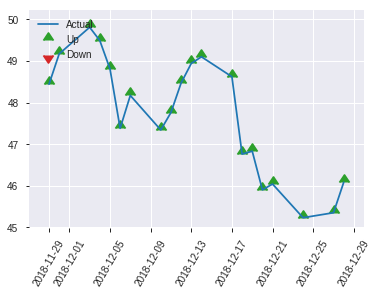


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24749452498384325
RMSE: 0.49748821592460185
LogLoss: 0.6875218755069451
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 346.70670784719556
Residual deviance: 345.13598150448644
AIC: 447.13598150448644
AUC: 0.5294380587484036
pr_auc: 0.5465712388880877
Gini: 0.0588761174968071
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3830674605843487: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      11   105  0.9052   (105.0/116.0)
1      2    133  0.0148   (2.0/135.0)
Total  13   238  0.4263   (107.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.383067     0.713137  237
max f2                       0.327242     0.856777  241
max f0point5                 0.383067     0.611776  237
max accuracy                 0.383067     0.573705  237
max precision                0.670904     1         0
max recall                   0.237708     1         248
max specificity              0.670904     1         0
max absolute_mcc             0.383067     0.180009  237
max min_per_class_accuracy   0.513246     0.518519  124
max mean_per_class_accuracy  0.48131      0.553895  178

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 49.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.606503           1.23951   1.23951            0.666667         0.636776  0.666667                    0.636776            0.0148148       0.0148148                  23.9506   23.9506
    2        0.0239044                   0.59561            0         0.619753           0                0.601004  0.333333                    0.61889             0               0.0148148                  -100      -38.0247
    3        0.0318725                   0.585496           0.92963   0.697222           0.5              0.587357  0.375                       0.611007            0.00740741      0.0222222                  -7.03704  -30.2778
    4        0.0438247                   0.581254           1.85926   1.01414            1                0.582698  0.545455                    0.603286            0.0222222       0.0444444                  85.9259   1.41414
    5        0.0517928                   0.57846            0.92963   1.00114            0.5              0.580437  0.538462                    0.599771            0.00740741      0.0518519                  -7.03704  0.11396
    6        0.103586                    0.5639             1.14416   1.07265            0.615385         0.570107  0.576923                    0.584939            0.0592593       0.111111                   14.416    7.26496
    7        0.151394                    0.554547           0.92963   1.02749            0.5              0.559287  0.552632                    0.576838            0.0444444       0.155556                   -7.03704  2.74854
    8        0.203187                    0.549641           0.7151    0.947858           0.384615         0.552055  0.509804                    0.570521            0.037037        0.192593                   -28.49    -5.21423
    9        0.302789                    0.534841           1.04119   0.978558           0.56             0.543548  0.526316                    0.561648            0.103704        0.296296                   4.11852   -2.14425
    10       0.40239                     0.523113           1.18993   1.03088            0.64             0.528305  0.554455                    0.553395            0.118519        0.414815                   18.9926   3.08764
    11       0.501992                    0.513235           1.04119   1.03292            0.56             0.517777  0.555556                    0.546328            0.103704        0.518519                   4.11852   3.29218
    12       0.601594                    0.496713           1.18993   1.05892            0.64             0.502706  0.569536                    0.539106            0.118519        0.637037                   18.9926   5.89159
    13       0.701195                    0.482961           1.04119   1.0564             0.56             0.489564  0.568182                    0.532068            0.103704        0.740741                   4.11852   5.63973
    14       0.800797                    0.459396           0.743704  1.01751            0.4              0.471663  0.547264                    0.524555            0.0740741       0.814815                   -25.6296  1.75051
    15       0.900398                    0.420797           1.11556   1.02835            0.6              0.44012   0.553097                    0.515215            0.111111        0.925926                   11.5556   2.83514
    16       1                           0.119118           0.743704  1                  0.4              0.340037  0.537849                    0.497767     

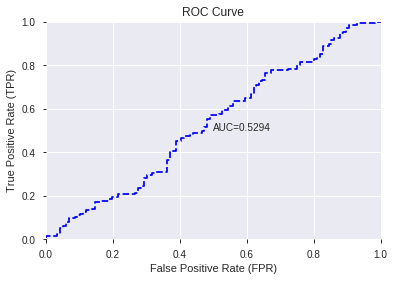

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


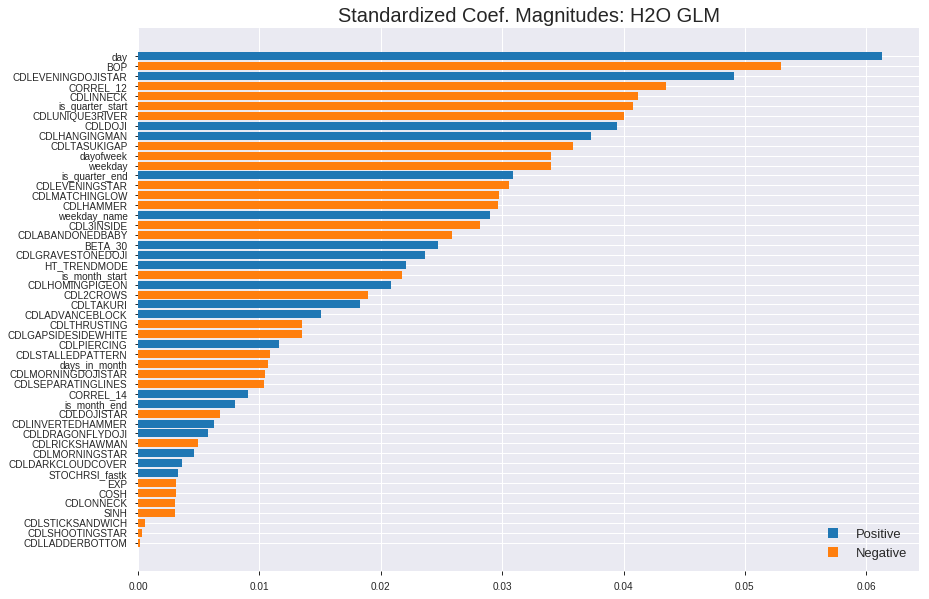

'log_likelihood'
--2019-08-27 18:17:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.137.76
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.137.76|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_181745_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_181745_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_9b73',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['day',
 'BOP',
 'CDLEVENINGDOJISTAR',
 'CORREL_12',
 'CDLINNECK',
 'is_quarter_start',
 'CDLUNIQUE3RIVER',
 'CDLDOJI',
 'CDLHANGINGMAN',
 'CDLTASUKIGAP',
 'dayofweek',
 'weekday',
 'is_quarter_end',
 'CDLEVENINGSTAR',
 'CDLMATCHINGLOW',
 'CDLHAMMER',
 'weekday_name',
 'CDL3INSIDE',
 'CDLABANDONEDBABY',
 'BETA_30',
 'CDLGRAVESTONEDOJI',
 'HT_TRENDMODE',
 'is_month_start',
 'CDLHOMINGPIGEON',
 'CDL2CROWS',
 'CDLTAKURI',
 'CDLADVANCEBLOCK',
 'CDLTHRUSTING',
 'CDLGAPSIDESIDEWHITE',
 'CDLPIERCING',
 'CDLSTALLEDPATTERN',
 'days_in_month',
 'CDLMORNINGDOJISTAR',
 'CDLSEPARATINGLINES',
 'CORREL_14',
 'is_month_end',
 'CDLDOJISTAR',
 'CDLINVERTEDHAMMER',
 'CDLDRAGONFLYDOJI',
 'CDLRICKSHAWMAN',
 'CDLMORNINGSTAR',
 'CDLDARKCLOUDCOVER',
 'STOCHRSI_fastk',
 'EXP',
 'COSH',
 'CDLONNECK',
 'SINH',
 'CDLSTICKSANDWICH',
 'CDLSHOOTINGSTAR',
 'CDLLADDERBOTTOM']

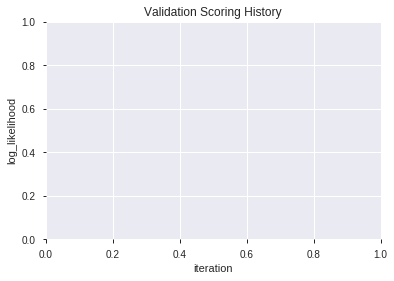

In [13]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_181756_model_4  0.536079  0.691300              0.495690  0.499094  0.249095
1               XGBoost_2_AutoML_20190827_181756  0.534738  0.698471              0.500000  0.502540  0.252546
2  XGBoost_grid_1_AutoML_20190827_181756_model_2  0.519987  0.696577              0.500000  0.501659  0.251662
3  XGBoost_grid_1_AutoML_20190827_181756_model_6  0.517369  0.698845              0.495690  0.502702  0.252709
4  XGBoost_grid_1_AutoML_20190827_181756_model_5  0.513729  0.725224              0.500000  0.513636  0.263822
5               XGBoost_1_AutoML_20190827_181756  0.512197  0.707303              0.495690  0.506677  0.256721
6  XGBoost_grid_1_AutoML_20190827_181756_model_3  0.508876  0.707289              0.490166  0.506755  0.256800
7  XGBoost_grid_1_AutoML_20190827_181756_model_1  0.501341  0.700371              0.500000  0.503637  0.253651
8               XGBoost_3_AutoML_20190827_181756  0.491762  0.708645              0.500000  0.507452  0.257508
9  XGBoost_grid_1_AutoML_20190827_181756_model_7  0.487803  0.719968              0.500000  0.512498  0.262654

variable  relative_importance  scaled_importance  percentage
0        CORREL_12           303.692841           1.000000    0.165749
1          BETA_30           253.719147           0.835447    0.138474
2              day           248.912979           0.819621    0.135851
3              BOP           236.215195           0.777810    0.128921
4        CORREL_14           236.084808           0.777380    0.128850
5             COSH           216.525467           0.712975    0.118175
6   STOCHRSI_fastk           154.179611           0.507683    0.084148
7        dayofweek            87.331902           0.287567    0.047664
8     weekday_name            35.550426           0.117060    0.019403
9     HT_TRENDMODE            20.984158           0.069097    0.011453
10         CDLDOJI            18.495783           0.060903    0.010095
11   days_in_month            13.104195           0.043150    0.007152
12         weekday             7.451707           0.024537    0.004067

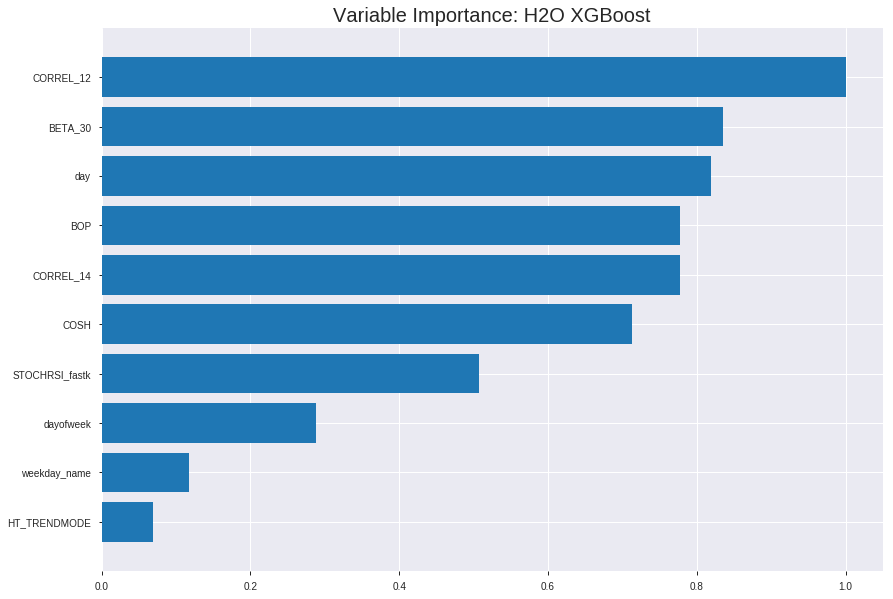

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_181756_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2308171887256921
RMSE: 0.48043437504584546
LogLoss: 0.6542903963222187
Mean Per-Class Error: 0.34184665325411046
AUC: 0.7155572603940786
pr_auc: 0.7220059868499428
Gini: 0.43111452078815726
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47009060382843015: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      271  563   0.6751   (563.0/834.0)
1      90   829   0.0979   (90.0/919.0)
Total  361  1392  0.3725   (653.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.470091     0.717438  295
max f2                       0.411416     0.850707  369
max f0point5                 0.520778     0.675894  201
max accuracy                 0.499459     0.662293  244
max precision                0.728983     1         0
max recall                   0.39039      1         386
max specificity              0.728983     1         0
max absolute_mcc             0.498476     0.324192  246
max min_per_class_accuracy   0.518669     0.651795  205
max mean_per_class_accuracy  0.520778     0.658153  201

Gains/Lift Table: Avg response rate: 52.42 %, avg score: 51.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.65712            1.80154   1.80154            0.944444         0.68195   0.944444                    0.68195             0.0184984       0.0184984                  80.1535    80.1535
    2        0.0205362                   0.636889           1.69556   1.74855            0.888889         0.644985  0.916667                    0.663467            0.0174102       0.0359086                  69.5563    74.8549
    3        0.0302339                   0.627045           1.6831    1.72755            0.882353         0.6317    0.90566                     0.653278            0.0163221       0.0522307                  68.3095    72.7555
    4        0.040502                    0.619059           1.48362   1.66571            0.777778         0.62222   0.873239                    0.645404            0.0152339       0.0674646                  48.3617    66.5711
    5        0.0501997                   0.613917           1.6831    1.66907            0.882353         0.616445  0.875                       0.63981             0.0163221       0.0837867                  68.3095    66.907
    6        0.100399                    0.593736           1.38728   1.52817            0.727273         0.603279  0.801136                    0.621544            0.0696409       0.153428                   38.7279    52.8174
    7        0.150029                    0.581571           1.51285   1.52311            0.793103         0.587612  0.798479                    0.61032             0.0750816       0.228509                   51.2851    52.3105
    8        0.200228                    0.570564           1.40895   1.49449            0.738636         0.575918  0.783476                    0.601695            0.0707291       0.299238                   40.8955    49.4486
    9        0.300057                    0.551948           1.27531   1.42157            0.668571         0.561108  0.745247                    0.588192            0.127312        0.426551                   27.5305    42.1565
    10       0.399886                    0.534316           1.1118    1.34424            0.582857         0.543015  0.704708                    0.576914            0.11099         0.537541                   11.1805    34.4235
    11       0.500285                    0.519211           1.11633   1.2985             0.585227         0.526437  0.68073                     0.566784            0.112078        0.649619                   11.6326    29.8498
    12       0.600114                    0.503728           0.991904  1.2475             0.52             0.511607  0.653992                    0.557605            0.0990207       0.74864                    -0.809576  24.7496
    13       0.699943                    0.489222           0.882904  1.1955             0.462857         0.496705  0.626732                    0.548919            0.0881393       0.836779                   -11.7096   19.5496
    14       0.799772                    0.467596           0.654003  1.12791            0.342857         0.479274  0.591298                    0.540226            0.0652884       0.902067                   -34.5997   12.7906
    15       0.899601                    0.441905           0.643103  1.07411            0.337143         0.456622  0.563094                    0.530949            0.0642002       0.966268                   -35.6897   7.41073
    16       1                           0.351322           0.335982  1                  0.176136         0.416524  0.524244                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2508104047172578
RMSE: 0.5008097490237763
LogLoss: 0.6948062575097549
Mean Per-Class Error: 0.4698448248280275
AUC: 0.5162294032954727
pr_auc: 0.5579530340153418
Gini: 0.032458806590945466
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37395426630973816: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    235  1        (235.0/235.0)
1      0    266  0        (0.0/266.0)
Total  0    501  0.4691   (235.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.373954     0.693611  399
max f2                       0.373954     0.84984   399
max f0point5                 0.410579     0.587832  380
max accuracy                 0.428562     0.536926  366
max precision                0.62355      0.764706  14
max recall                   0.373954     1         399
max specificity              0.692747     0.995745  0
max absolute_mcc             0.612274     0.100338  24
max min_per_class_accuracy   0.508444     0.497872  202
max mean_per_class_accuracy  0.578573     0.530155  70

Gains/Lift Table: Avg response rate: 53.09 %, avg score: 51.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.637032           0.941729  0.941729           0.5              0.654435  0.5                         0.654435            0.0112782       0.0112782                  -5.82707  -5.82707
    2        0.0219561                   0.627421           1.50677   1.19856            0.8              0.630631  0.636364                    0.643615            0.0150376       0.0263158                  50.6767   19.8565
    3        0.0319361                   0.623582           1.88346   1.41259            1                0.625158  0.75                        0.637847            0.018797        0.0451128                  88.3459   41.2594
    4        0.0419162                   0.61703            1.13008   1.34533            0.6              0.620655  0.714286                    0.633754            0.0112782       0.056391                   13.0075   34.5328
    5        0.0518962                   0.615207           1.50677   1.37637            0.8              0.615909  0.730769                    0.630322            0.0150376       0.0714286                  50.6767   37.6374
    6        0.101796                    0.593676           0.979398  1.18178            0.52             0.603219  0.627451                    0.617036            0.0488722       0.120301                   -2.06015  18.1778
    7        0.151697                    0.580857           1.05474   1.13999            0.56             0.585909  0.605263                    0.606797            0.0526316       0.172932                   5.47368   13.9988
    8        0.201597                    0.567329           0.979398  1.10024            0.52             0.57383   0.584158                    0.598637            0.0488722       0.221805                   -2.06015  10.0238
    9        0.301397                    0.543844           0.866391  1.02281            0.46             0.555839  0.543046                    0.584466            0.0864662       0.308271                   -13.3609  2.28054
    10       0.401198                    0.522913           1.01707   1.02138            0.54             0.533875  0.542289                    0.571881            0.101504        0.409774                   1.70677   2.13781
    11       0.500998                    0.508444           0.90406   0.998008           0.48             0.516196  0.52988                     0.560788            0.0902256       0.5                        -9.59398  -0.199203
    12       0.600798                    0.492479           0.979398  0.994917           0.52             0.500679  0.528239                    0.550803            0.0977444       0.597744                   -2.06015  -0.508331
    13       0.700599                    0.480406           1.09241   1.0088             0.58             0.487116  0.535613                    0.541731            0.109023        0.706767                   9.2406    0.880406
    14       0.800399                    0.462106           0.941729  1.00044            0.5              0.470104  0.531172                    0.5328              0.093985        0.800752                   -5.82707  0.0440628
    15       0.9002                      0.436046           1.01707   1.00228            0.54             0.451815  0.532151                    0.523822            0.101504        0.902256                   1.70677   0.228398
    16       1                           0.373954           0.979398  1                  0.52             0.413604  0.530938                    0.512822


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:18:03  2.871 sec   0                  0.5              0.693147            0.5             0                  1                0.475756                         0.5                0.693147              0.5               0                    1                  0.469062
    2019-08-27 18:18:04  2.970 sec   5                  0.496953         0.687067            0.63459         0.643072           1.58959          0.419852                         0.499345           0.691837              0.522228          0.5513               1.25564            0.461078
    2019-08-27 18:18:04  3.022 sec   10                 0.494314         0.681819            0.653854        0.661699           1.37764          0.420422                         0.499074           0.691294              0.529987          0.548846             1.25564            0.457086
    2019-08-27 18:18:04  3.075 sec   15                 0.49187          0.676965            0.664714        0.676711           1.80154          0.409584                         0.499013           0.691166              0.525732          0.556688             1.56955            0.457086
    2019-08-27 18:18:04  3.126 sec   20                 0.48994          0.673129            0.67099         0.678181           1.80154          0.429549                         0.499464           0.692067              0.518157          0.551031             1.56955            0.461078
    2019-08-27 18:18:04  3.186 sec   25                 0.488336         0.669942            0.67838         0.686906           1.80154          0.410724                         0.499619           0.692371              0.515454          0.556627             1.56955            0.461078
    2019-08-27 18:18:04  3.241 sec   30                 0.486575         0.666455            0.691137        0.700559           1.90751          0.378779                         0.499854           0.692859              0.51511           0.549875             1.25564            0.461078
    2019-08-27 18:18:04  3.301 sec   35                 0.48502          0.663363            0.697907        0.707215           1.90751          0.375927                         0.499504           0.69215               0.521357          0.554939             0.941729           0.467066
    2019-08-27 18:18:04  3.365 sec   40                 0.483434         0.66023             0.706779        0.713292           1.80154          0.384484                         0.50037            0.693894              0.512254          0.551054             0.941729           0.469062
    2019-08-27 18:18:04  3.426 sec   45                 0.482076         0.65753             0.707217        0.715849           1.80154          0.399886                         0.500396           0.69395               0.517349          0.557653             0.941729           0.469062
    2019-08-27 18:18:04  3.493 sec   50                 0.480434         0.65429             0.715557        0.722006           1.80154          0.372504                         0.50081            0.694806              0.516229          0.557953             0.941729           0.469062

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  ------------
CORREL_12       303.693                1                    0.165749
BETA_30         253.719                0.835447             0.138474
day             248.913                0.819621             0.135851
BOP             236.215                0.77781              0.128921
CORREL_14       236.085                0.77738              0.12885
COSH            216.525                0.712975             0.118175
STOCHRSI_fastk  154.18                 0.507683             0.0841478
dayofweek       87.3319                0.287567             0.0476638
weekday_name    35.5504                0.11706              0.0194026
HT_TRENDMODE    20.9842                0.0690966            0.0114527
CDLDOJI         18.4958                0.0609029            0.0100946
days_in_month   13.1042                0.0431495            0.00715198
weekday         7.45171                0.024537             0.00406697

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.545816733067729)

('F1', 0.7012987012987013)

('auc', 0.5360791826309067)

('logloss', 0.6912999772130072)

('mean_per_class_error', 0.4332694763729247)

('rmse', 0.4990944185218032)

('mse', 0.24909523859961683)

xgboost prediction progress: |████████████████████████████████████████████| 100%


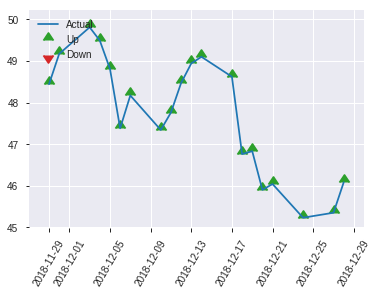


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24909523859961683
RMSE: 0.4990944185218032
LogLoss: 0.6912999772130072
Mean Per-Class Error: 0.4332694763729247
AUC: 0.5360791826309067
pr_auc: 0.6204777809382758
Gini: 0.0721583652618134
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36804041266441345: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    115  0.9914   (115.0/116.0)
1      0    135  0        (0.0/135.0)
Total  1    250  0.4582   (115.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.36804      0.701299  249
max f2                       0.36804      0.85443   249
max f0point5                 0.415003     0.595349  234
max accuracy                 0.415003     0.545817  234
max precision                0.643346     1         0
max recall                   0.36804      1         249
max specificity              0.643346     1         0
max absolute_mcc             0.557777     0.202236  30
max min_per_class_accuracy   0.493066     0.533333  124
max mean_per_class_accuracy  0.557777     0.566731  30

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 49.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.605453           1.85926   1.85926            1                0.627051  1                           0.627051            0.0222222       0.0222222                  85.9259   85.9259
    2        0.0239044                   0.59478            1.85926   1.85926            1                0.598835  1                           0.612943            0.0222222       0.0444444                  85.9259   85.9259
    3        0.0318725                   0.588294           1.85926   1.85926            1                0.590131  1                           0.60724             0.0148148       0.0592593                  85.9259   85.9259
    4        0.0438247                   0.586757           1.23951   1.69024            0.666667         0.58731   0.909091                    0.601805            0.0148148       0.0740741                  23.9506   69.0236
    5        0.0517928                   0.579551           1.85926   1.71624            1                0.581174  0.923077                    0.598631            0.0148148       0.0888889                  85.9259   71.6239
    6        0.103586                    0.565701           1.28718   1.50171            0.692308         0.572388  0.807692                    0.585509            0.0666667       0.155556                   28.7179   50.1709
    7        0.151394                    0.549006           0.92963   1.32105            0.5              0.555574  0.710526                    0.576056            0.0444444       0.2                        -7.03704  32.1053
    8        0.203187                    0.539839           0.57208   1.13014            0.307692         0.543969  0.607843                    0.567877            0.0296296       0.22963                    -42.792   13.0138
    9        0.302789                    0.527477           0.966815  1.07641            0.52             0.532766  0.578947                    0.556327            0.0962963       0.325926                   -3.31852  7.64133
    10       0.40239                     0.507915           0.966815  1.04928            0.52             0.517049  0.564356                    0.546605            0.0962963       0.422222                   -3.31852  4.92849
    11       0.501992                    0.492154           1.11556   1.06243            0.6              0.499622  0.571429                    0.537283            0.111111        0.533333                   11.5556   6.24339
    12       0.601594                    0.476823           0.818074  1.02198            0.44             0.484616  0.549669                    0.528563            0.0814815       0.614815                   -18.1926  2.19769
    13       0.701195                    0.457946           0.818074  0.993013           0.44             0.468515  0.534091                    0.520034            0.0814815       0.696296                   -18.1926  -0.698653
    14       0.800797                    0.444727           0.966815  0.989755           0.52             0.452234  0.532338                    0.511601            0.0962963       0.792593                   -3.31852  -1.02451
    15       0.900398                    0.423654           1.04119   0.995444           0.56             0.432738  0.535398                    0.502877            0.103704        0.896296                   4.11852   -0.455588
    16       1                           0.357931           1.04119   1                  0.56             0.405514  0.537849                    0.49318     

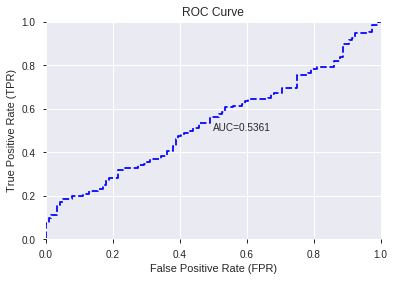

This function is available for GLM models only


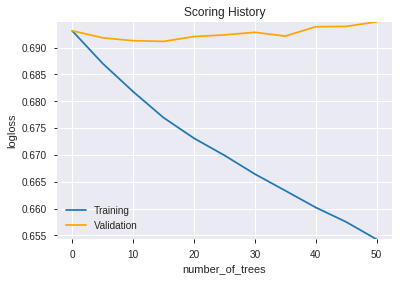

--2019-08-27 18:18:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.0.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.0.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.ge

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_181756_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_181756_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_9b73',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CORREL_12',
 'BETA_30',
 'day',
 'BOP',
 'CORREL_14',
 'COSH',
 'STOCHRSI_fastk',
 'dayofweek',
 'weekday_name',
 'HT_TRENDMODE',
 'CDLDOJI',
 'days_in_month',
 'weekday']

In [14]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_181821_model_1  0.474393  0.695525              0.490773  0.501187  0.251189

variable  relative_importance  scaled_importance  percentage
0                 CDLSHORTLINE             0.009186           1.000000    0.012389
1                          day             0.008301           0.903618    0.011195
2             is_quarter_start             0.006044           0.657899    0.008151
3                      weekday             0.005922           0.644609    0.007986
4                    dayofweek             0.005911           0.643505    0.007973
...                        ...                  ...                ...         ...
1034   BBANDS_lowerband_20_0_2             0.000004           0.000384    0.000005
1035  BBANDS_middleband_20_3_2             0.000003           0.000379    0.000005
1036                   MA_20_3             0.000003           0.000338    0.000004
1037  BBANDS_middleband_12_6_3             0.000001           0.000154    0.000002
1038                 MAVP_14_5             0.000001           0.000135    0.000002

[1039 rows x 4 columns]

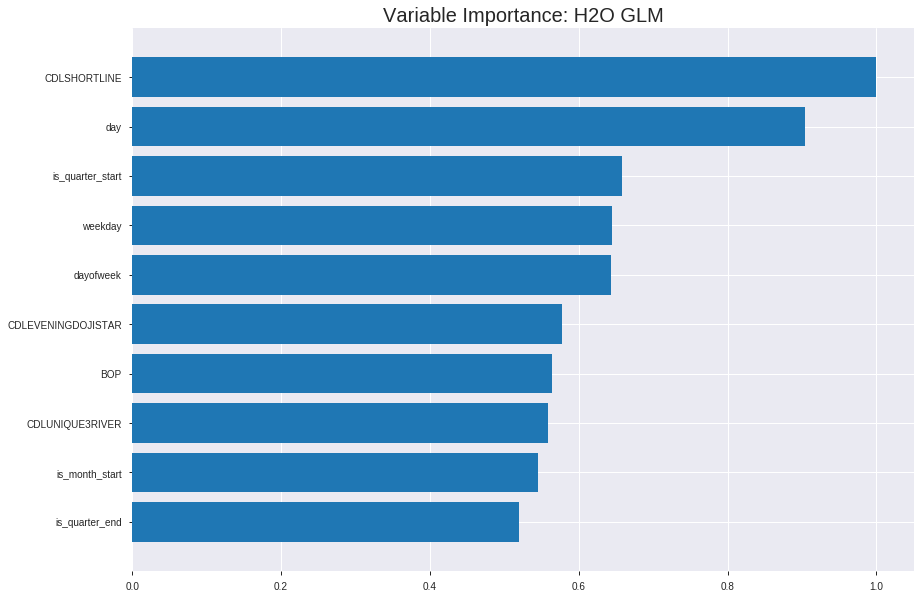

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_181821_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24632305993290093
RMSE: 0.496309439697555
LogLoss: 0.6857629635768286
Null degrees of freedom: 1752
Residual degrees of freedom: 713
Null deviance: 2426.050892509706
Residual deviance: 2404.2849503003617
AIC: 4484.284950300362
AUC: 0.578069426939406
pr_auc: 0.5845235031870788
Gini: 0.156138853878812
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4611033186915171: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      20   814   0.976    (814.0/834.0)
1      5    914   0.0054   (5.0/919.0)
Total  25   1728  0.4672   (819.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.461103     0.690593  381
max f2                       0.430195     0.846849  396
max f0point5                 0.506293     0.598063  269
max accuracy                 0.518302     0.573303  220
max precision                0.615616     0.75      3
max recall                   0.430195     1         396
max specificity              0.623614     0.998801  0
max absolute_mcc             0.518302     0.14042   220
max min_per_class_accuracy   0.52347      0.566921  201
max mean_per_class_accuracy  0.518302     0.569192  220

Gains/Lift Table: Avg response rate: 52.42 %, avg score: 52.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.5955             1.37764   1.37764            0.722222         0.607314  0.722222                    0.607314            0.0141458       0.0141458                  37.7645   37.7645
    2        0.0205362                   0.584886           1.27167   1.32466            0.666667         0.591148  0.694444                    0.599231            0.0130577       0.0272035                  27.1672   32.4658
    3        0.0302339                   0.5796             1.34648   1.33166            0.705882         0.582052  0.698113                    0.593721            0.0130577       0.0402612                  34.6476   33.1657
    4        0.040502                    0.576283           1.05973   1.26272            0.555556         0.577779  0.661972                    0.589679            0.0108814       0.0511425                  5.97268   26.2717
    5        0.0501997                   0.57234            1.45868   1.30057            0.764706         0.574488  0.681818                    0.586744            0.0141458       0.0652884                  45.8683   30.0574
    6        0.100399                    0.559365           0.953754  1.12716            0.5              0.564534  0.590909                    0.575639            0.0478781       0.113166                   -4.62459  12.7164
    7        0.150029                    0.552513           1.22782   1.16046            0.643678         0.555508  0.608365                    0.56898             0.0609358       0.174102                   22.7821   16.0461
    8        0.200228                    0.546348           1.01878   1.12494            0.534091         0.549073  0.589744                    0.563989            0.0511425       0.225245                   1.87828   12.4941
    9        0.300057                    0.537125           1.0246    1.09156            0.537143         0.542091  0.572243                    0.556704            0.102285        0.32753                    2.46044   9.15589
    10       0.399886                    0.530003           1.1227    1.09933            0.588571         0.533647  0.57632                     0.550948            0.112078        0.439608                   12.2705   9.93342
    11       0.500285                    0.52351            1.23555   1.12667            0.647727         0.526842  0.59065                     0.54611             0.124048        0.563656                   23.5545   12.667
    12       0.600114                    0.517813           0.970104  1.10062            0.508571         0.520412  0.576996                    0.541835            0.0968444       0.660501                   -2.98958  10.0625
    13       0.699943                    0.510641           0.926504  1.07579            0.485714         0.514236  0.563977                    0.537899            0.0924918       0.752992                   -7.3496   7.57911
    14       0.799772                    0.502145           0.926504  1.05716            0.485714         0.506345  0.554208                    0.53396             0.0924918       0.845484                   -7.3496   5.71568
    15       0.899601                    0.489229           0.784803  1.02693            0.411429         0.496096  0.538364                    0.529758            0.078346        0.92383                    -21.5197  2.69337
    16       1                           0.400878           0.758668  1                  0.397727         0.474835  0.524244                    0.524244          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24961685283142002
RMSE: 0.49961670591706603
LogLoss: 0.6923850151087547
Null degrees of freedom: 500
Residual degrees of freedom: -539
Null deviance: 692.7041364892402
Residual deviance: 693.7697851389722
AIC: 2773.769785138972
AUC: 0.5238681810910255
pr_auc: 0.537099334830445
Gini: 0.04773636218205102
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46034972067559005: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    232  0.9872   (232.0/235.0)
1      0    266  0        (0.0/266.0)
Total  3    498  0.4631   (232.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.46035      0.696335  396
max f2                       0.46035      0.851472  396
max f0point5                 0.46035      0.589017  396
max accuracy                 0.519589     0.55489   143
max precision                0.579849     1         0
max recall                   0.46035      1         396
max specificity              0.579849     1         0
max absolute_mcc             0.519589     0.134952  143
max min_per_class_accuracy   0.513861     0.541353  196
max mean_per_class_accuracy  0.519589     0.564462  143

Gains/Lift Table: Avg response rate: 53.09 %, avg score: 51.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.562039           0.62782   0.62782            0.333333         0.570112  0.333333                    0.570112            0.0075188       0.0075188                  -37.218   -37.218
    2        0.0219561                   0.55986            1.13008   0.856118           0.6              0.560523  0.454545                    0.565753            0.0112782       0.018797                   13.0075   -14.3882
    3        0.0319361                   0.555247           1.13008   0.941729           0.6              0.556939  0.5                         0.562999            0.0112782       0.0300752                  13.0075   -5.82707
    4        0.0419162                   0.554807           0.376692  0.807197           0.2              0.554976  0.428571                    0.561088            0.0037594       0.0338346                  -62.3308  -19.2803
    5        0.0518962                   0.551546           0.753383  0.796848           0.4              0.553116  0.423077                    0.559555            0.0075188       0.0413534                  -24.6617  -20.3152
    6        0.101796                    0.537254           0.90406   0.849403           0.48             0.54334   0.45098                     0.551607            0.0451128       0.0864662                  -9.59398  -15.0597
    7        0.151697                    0.530325           1.20541   0.966512           0.64             0.533164  0.513158                    0.54554             0.0601504       0.146617                   20.5414   -3.34883
    8        0.201597                    0.526915           1.28075   1.04429            0.68             0.528584  0.554455                    0.541343            0.0639098       0.210526                   28.0752   4.42939
    9        0.301397                    0.520988           1.20541   1.09764            0.64             0.523461  0.582781                    0.535422            0.120301        0.330827                   20.5414   9.76448
    10       0.401198                    0.517605           1.16774   1.11508            0.62             0.519279  0.59204                     0.531406            0.116541        0.447368                   16.7744   11.5082
    11       0.500998                    0.513861           0.941729  1.08055            0.5              0.515841  0.573705                    0.528306            0.093985        0.541353                   -5.82707  8.055
    12       0.600798                    0.509004           0.715714  1.01995            0.38             0.511259  0.541528                    0.525474            0.0714286       0.612782                   -28.4286  1.9946
    13       0.700599                    0.504132           0.979398  1.01417            0.52             0.506654  0.538462                    0.522793            0.0977444       0.710526                   -2.06015  1.417
    14       0.800399                    0.497401           0.828722  0.991047           0.44             0.500784  0.526185                    0.520049            0.0827068       0.793233                   -17.1278  -0.895318
    15       0.9002                      0.485963           0.979398  0.989755           0.52             0.493056  0.525499                    0.517056            0.0977444       0.890977                   -2.06015  -1.02446
    16       1                           0.439304           1.09241   1                  0.58             0.474467  0.530938                    0.512806     


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 18:18:24  0.000 sec   2            3.2       1040          1.37153           1.38477
    2019-08-27 18:18:27  2.153 sec   4            2.4       1040          1.36894           1.38498
    2019-08-27 18:18:29  4.283 sec   6            1.7       1040          1.36586           1.385
    2019-08-27 18:18:31  6.398 sec   8            1.3       1040          1.36225           1.38495
    2019-08-27 18:18:33  8.509 sec   10           0.91      1040          1.35809           1.38487
    2019-08-27 18:18:35  10.627 sec  12           0.66      1040          1.35342           1.38485
    2019-08-27 18:18:37  12.785 sec  14           0.48      1040          1.34831           1.385
    2019-08-27 18:18:39  14.975 sec  16           0.35      1040          1.34286           1.38547
    2019-08-27 18:18:42  17.120 sec  18           0.26      1040          1.33722           1.38639
    2019-08-27 18:18:44  19.288 sec  20           0.19      1040          1.3315            1.38788
    2019-08-27 18:18:46  21.458 sec  22           0.14      1040          1.32581           1.39007

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.545816733067729)

('F1', 0.7015706806282723)

('auc', 0.4743933588761175)

('logloss', 0.6955251632336527)

('mean_per_class_error', 0.47713920817369093)

('rmse', 0.5011872684344625)

('mse', 0.2511886780407979)

glm prediction progress: |████████████████████████████████████████████████| 100%


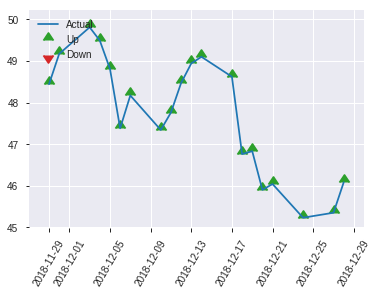


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2511886780407979
RMSE: 0.5011872684344625
LogLoss: 0.6955251632336527
Null degrees of freedom: 250
Residual degrees of freedom: -789
Null deviance: 346.70670784719556
Residual deviance: 349.15363194329365
AIC: 2429.1536319432935
AUC: 0.4743933588761175
pr_auc: 0.5249019398813967
Gini: -0.051213282247765
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4529132705415852: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    113  0.9741   (113.0/116.0)
1      1    134  0.0074   (1.0/135.0)
Total  4    247  0.4542   (114.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.452913     0.701571  246
max f2                       0.449455     0.85443   249
max f0point5                 0.452913     0.596616  246
max accuracy                 0.452913     0.545817  246
max precision                0.57052      1         0
max recall                   0.449455     1         249
max specificity              0.57052      1         0
max absolute_mcc             0.481316     0.112117  206
max min_per_class_accuracy   0.500643     0.508621  125
max mean_per_class_accuracy  0.497678     0.522861  135

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 50.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.547703           1.23951   1.23951            0.666667         0.560154  0.666667                    0.560154            0.0148148       0.0148148                  23.9506   23.9506
    2        0.0239044                   0.545744           1.23951   1.23951            0.666667         0.546095  0.666667                    0.553125            0.0148148       0.0296296                  23.9506   23.9506
    3        0.0318725                   0.543866           0.92963   1.16204            0.5              0.544394  0.625                       0.550942            0.00740741      0.037037                   -7.03704  16.2037
    4        0.0438247                   0.542923           1.23951   1.18316            0.666667         0.543264  0.636364                    0.548848            0.0148148       0.0518519                  23.9506   18.3165
    5        0.0517928                   0.541119           0.92963   1.14416            0.5              0.542156  0.615385                    0.547818            0.00740741      0.0592593                  -7.03704  14.416
    6        0.103586                    0.533272           0.42906   0.78661            0.230769         0.536798  0.423077                    0.542308            0.0222222       0.0814815                  -57.094   -21.339
    7        0.151394                    0.525927           1.39444   0.978558           0.75             0.529204  0.526316                    0.53817             0.0666667       0.148148                   39.4444   -2.14425
    8        0.203187                    0.521003           0.85812   0.947858           0.461538         0.523217  0.509804                    0.534359            0.0444444       0.192593                   -14.188   -5.21423
    9        0.302789                    0.514611           0.966815  0.954094           0.52             0.517724  0.513158                    0.528887            0.0962963       0.288889                   -3.31852  -4.59064
    10       0.40239                     0.507837           0.966815  0.957242           0.52             0.51119   0.514851                    0.524506            0.0962963       0.385185                   -3.31852  -4.27576
    11       0.501992                    0.500643           1.2643    1.01817            0.68             0.503953  0.547619                    0.520428            0.125926        0.511111                   26.4296   1.81658
    12       0.601594                    0.494302           0.892444  0.997351           0.48             0.497024  0.536424                    0.516553            0.0888889       0.6                        -10.7556  -0.264901
    13       0.701195                    0.489813           0.669333  0.950758           0.36             0.49189   0.511364                    0.51305             0.0666667       0.666667                   -33.0667  -4.92424
    14       0.800797                    0.482338           1.04119   0.962005           0.56             0.486251  0.517413                    0.509717            0.103704        0.77037                    4.11852   -3.79952
    15       0.900398                    0.472226           1.2643    0.995444           0.68             0.4786    0.535398                    0.506275            0.125926        0.896296                   26.4296   -0.455588
    16       1                           0.439207           1.04119   1                  0.56             0.461711  0.537849                    0.501836

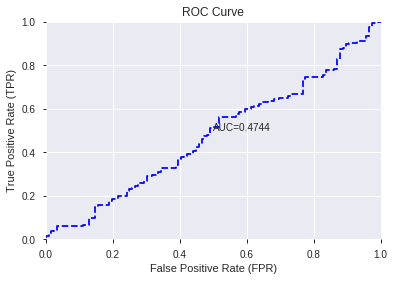

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


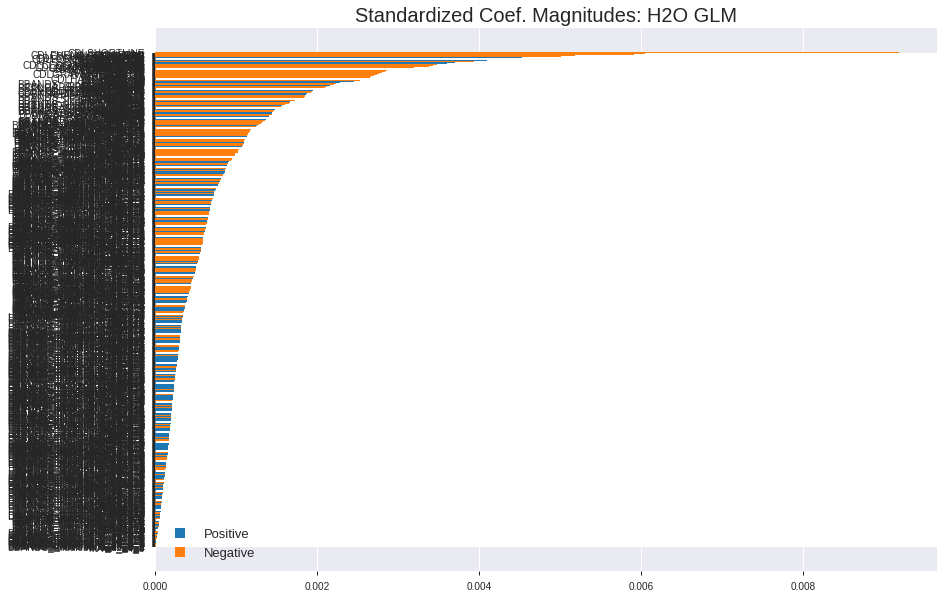

'log_likelihood'
--2019-08-27 18:19:10--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.105.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.105.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_181821_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_181821_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_9b73',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

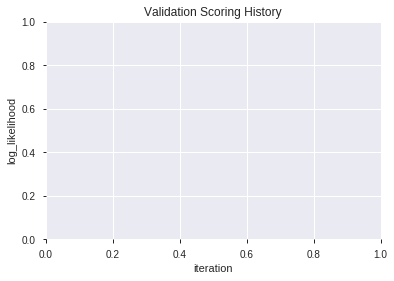

In [15]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [16]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [17]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [18]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_181916_model_3  0.537229  0.702918              0.487069  0.504572  0.254593
1  XGBoost_grid_1_AutoML_20190827_181916_model_5  0.512963  0.746979              0.495690  0.522703  0.273218
2  XGBoost_grid_1_AutoML_20190827_181916_model_7  0.496616  0.722644              0.491379  0.513460  0.263641
3  XGBoost_grid_1_AutoML_20190827_181916_model_4  0.485377  0.702001              0.485856  0.504343  0.254362
4               XGBoost_1_AutoML_20190827_181916  0.484802  0.737538              0.487069  0.520358  0.270772
5               XGBoost_2_AutoML_20190827_181916  0.478416  0.722831              0.477842  0.513729  0.263918
6  XGBoost_grid_1_AutoML_20190827_181916_model_6  0.478416  0.731701              0.490773  0.517799  0.268116
7               XGBoost_3_AutoML_20190827_181916  0.476564  0.728602              0.490166  0.516304  0.266570
8  XGBoost_grid_1_AutoML_20190827_181916_model_1  0.463538  0.759035              0.490773  0.529395  0.280259
9  XGBoost_grid_1_AutoML_20190827_181916_model_2  0.448978  0.718177              0.500000  0.512005  0.262149

variable  relative_importance  scaled_importance  percentage
0                        day           122.819008           1.000000    0.021567
1                  CORREL_14            96.471237           0.785475    0.016940
2                     CCI_24            87.282204           0.710657    0.015327
3          HT_PHASOR_inphase            81.607971           0.664457    0.014330
4                  CORREL_24            72.757599           0.592397    0.012776
..                       ...                  ...                ...         ...
324              MINUS_DM_20             1.222715           0.009955    0.000215
325  BBANDS_lowerband_12_0_2             1.023185           0.008331    0.000180
326                   CMO_14             0.768317           0.006256    0.000135
327              aroondown_8             0.763712           0.006218    0.000134
328   BBANDS_upperband_8_6_2             0.304053           0.002476    0.000053

[329 rows x 4 columns]

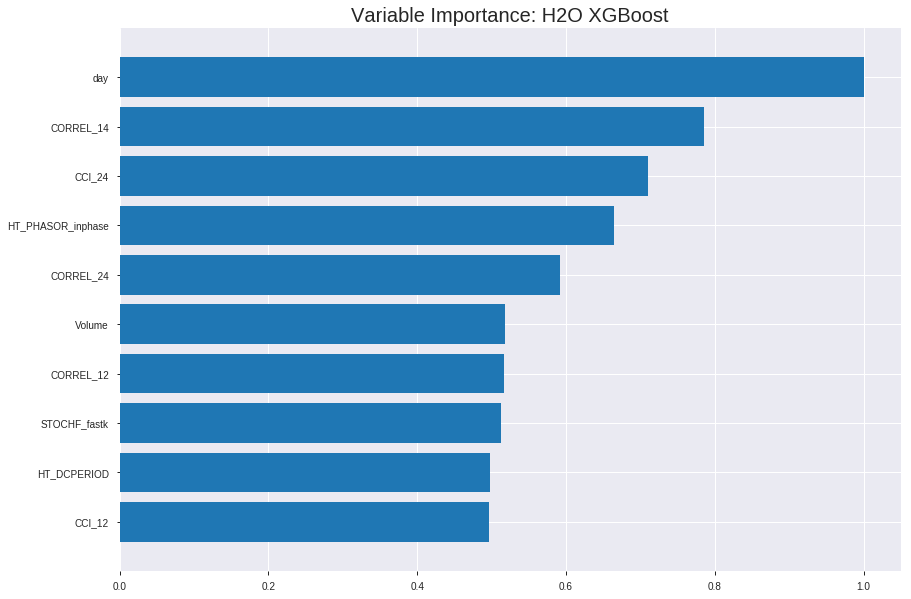

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_181916_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17846723852926513
RMSE: 0.4224538300563331
LogLoss: 0.5456074738227253
Mean Per-Class Error: 0.1351204129188488
AUC: 0.9395482525840047
pr_auc: 0.9417034808583666
Gini: 0.8790965051680093
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4946851134300232: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      657  177   0.2122   (177.0/834.0)
1      63   856   0.0686   (63.0/919.0)
Total  720  1033  0.1369   (240.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.494685     0.877049  223
max f2                       0.476832     0.919983  240
max f0point5                 0.546453     0.888476  174
max accuracy                 0.511925     0.865944  207
max precision                0.795759     1         0
max recall                   0.349793     1         344
max specificity              0.795759     1         0
max absolute_mcc             0.511925     0.731203  207
max min_per_class_accuracy   0.519398     0.860718  199
max mean_per_class_accuracy  0.511925     0.86488   207

Gains/Lift Table: Avg response rate: 52.42 %, avg score: 52.29 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.745711           1.90751    1.90751            1                0.769139  1                           0.769139            0.0195865       0.0195865                  90.7508   90.7508
    2        0.0205362                   0.721383           1.90751    1.90751            1                0.732388  1                           0.750764            0.0195865       0.039173                   90.7508   90.7508
    3        0.0302339                   0.713473           1.90751    1.90751            1                0.716902  1                           0.739902            0.0184984       0.0576714                  90.7508   90.7508
    4        0.040502                    0.707283           1.90751    1.90751            1                0.709954  1                           0.73231             0.0195865       0.0772579                  90.7508   90.7508
    5        0.0501997                   0.701284           1.90751    1.90751            1                0.704109  1                           0.726862            0.0184984       0.0957563                  90.7508   90.7508
    6        0.100399                    0.672184           1.88583    1.89667            0.988636         0.684994  0.994318                    0.705928            0.0946681       0.190424                   88.5832   89.667
    7        0.150029                    0.647679           1.84173    1.8785             0.965517         0.659173  0.984791                    0.690462            0.0914037       0.281828                   84.1732   87.8497
    8        0.200228                    0.629634           1.8208     1.86403            0.954545         0.636932  0.977208                    0.677041            0.0914037       0.373232                   82.0803   86.4032
    9        0.300057                    0.592384           1.76581    1.83135            0.925714         0.611107  0.960076                    0.655105            0.176279        0.54951                    76.5808   83.1353
    10       0.399886                    0.563477           1.61321    1.77689            0.845714         0.578154  0.931526                    0.635895            0.161045        0.710555                   61.3207   77.6894
    11       0.500285                    0.525988           1.33309    1.68783            0.698864         0.543441  0.884835                    0.617341            0.133841        0.844396                   33.3088   68.7829
    12       0.600114                    0.49131            0.926504   1.56118            0.485714         0.507822  0.818441                    0.599122            0.0924918       0.936888                   -7.3496   56.1183
    13       0.699943                    0.453415           0.381502   1.39293            0.2              0.472543  0.730236                    0.581069            0.0380849       0.974973                   -61.8498  39.2932
    14       0.799772                    0.419858           0.196201   1.24355            0.102857         0.437479  0.651926                    0.563146            0.0195865       0.994559                   -80.3799  24.3554
    15       0.899601                    0.374909           0.0436002  1.11039            0.0228571        0.397582  0.582118                    0.544773            0.00435256      0.998912                   -95.64    11.0395
    16       1                           0.140015           0.0108381  1                  0.00568182       0.326602  0.524244                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2655784298967568
RMSE: 0.5153430215853871
LogLoss: 0.7254608623327643
Mean Per-Class Error: 0.4927291633338666
AUC: 0.4348904175331947
pr_auc: 0.4894330830747079
Gini: -0.13021916493361063
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20768743753433228: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    235  1        (235.0/235.0)
1      0    266  0        (0.0/266.0)
Total  0    501  0.4691   (235.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.207687     0.693611  399
max f2                       0.207687     0.84984   399
max f0point5                 0.261296     0.586667  394
max accuracy                 0.261296     0.532934  394
max precision                0.713228     1         0
max recall                   0.207687     1         399
max specificity              0.713228     1         0
max absolute_mcc             0.529448     0.128024  107
max min_per_class_accuracy   0.483335     0.443609  196
max mean_per_class_accuracy  0.659818     0.507271  5

Gains/Lift Table: Avg response rate: 53.09 %, avg score: 47.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.659818           1.56955   1.56955            0.833333         0.683365  0.833333                    0.683365            0.018797        0.018797                   56.9549   56.9549
    2        0.0219561                   0.623119           0.753383  1.19856            0.4              0.630234  0.636364                    0.659215            0.0075188       0.0263158                  -24.6617  19.8565
    3        0.0319361                   0.615836           0         0.824013           0                0.62051   0.4375                      0.64712             0               0.0263158                  -100      -17.5987
    4        0.0419162                   0.60527            1.13008   0.896885           0.6              0.610067  0.47619                     0.638297            0.0112782       0.037594                   13.0075   -10.3115
    5        0.0518962                   0.596846           0         0.724407           0                0.600717  0.384615                    0.63107             0               0.037594                   -100      -27.5593
    6        0.101796                    0.565844           1.13008   0.923264           0.6              0.578005  0.490196                    0.605058            0.056391        0.093985                   13.0075   -7.6736
    7        0.151697                    0.555714           0.602707  0.817818           0.32             0.560459  0.434211                    0.590387            0.0300752       0.12406                    -39.7293  -18.2182
    8        0.201597                    0.544058           0.979398  0.857813           0.52             0.549353  0.455446                    0.58023             0.0488722       0.172932                   -2.06015  -14.2187
    9        0.301397                    0.519332           0.715714  0.81076            0.38             0.530864  0.430464                    0.563884            0.0714286       0.244361                   -28.4286  -18.924
    10       0.401198                    0.499922           1.09241   0.880821           0.58             0.508186  0.467662                    0.550029            0.109023        0.353383                   9.2406    -11.9179
    11       0.500998                    0.481854           0.941729  0.892954           0.5              0.490766  0.474104                    0.538224            0.093985        0.447368                   -5.82707  -10.7046
    12       0.600798                    0.465767           1.16774   0.938601           0.62             0.473201  0.498339                    0.527423            0.116541        0.56391                    16.7744   -6.13993
    13       0.700599                    0.446555           1.13008   0.965876           0.6              0.455945  0.512821                    0.51724             0.112782        0.676692                   13.0075   -3.41238
    14       0.800399                    0.419815           1.01707   0.972259           0.54             0.433096  0.516209                    0.506749            0.101504        0.778195                   1.70677   -2.77408
    15       0.9002                      0.384548           1.05474   0.981403           0.56             0.404553  0.521064                    0.495419            0.105263        0.883459                   5.47368   -1.85969
    16       1                           0.207687           1.16774   1                  0.62             0.330253  0.530938                    0.4789


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:19:39  7.159 sec   0                  0.5              0.693147            0.5             0                  1                0.475756                         0.5                0.693147              0.5               0                    1                  0.469062
    2019-08-27 18:19:40  8.373 sec   5                  0.491723         0.676685            0.712995        0.732494           1.80154          0.386766                         0.50128            0.69572               0.489682          0.51897              0.706297           0.467066
    2019-08-27 18:19:41  8.739 sec   10                 0.483274         0.660072            0.784173        0.794354           1.80154          0.313177                         0.503114           0.699437              0.456767          0.505947             1.25564            0.46507
    2019-08-27 18:19:41  9.115 sec   15                 0.47452          0.643021            0.829094        0.83767            1.90751          0.261837                         0.506239           0.705894              0.438474          0.481693             0.62782            0.467066
    2019-08-27 18:19:42  9.495 sec   20                 0.465864         0.626325            0.851454        0.865964           1.90751          0.229321                         0.508073           0.709702              0.435898          0.493649             1.56955            0.467066
    2019-08-27 18:19:42  9.862 sec   25                 0.459403         0.613987            0.868606        0.880152           1.90751          0.224187                         0.508926           0.711537              0.442993          0.499678             1.56955            0.467066
    2019-08-27 18:19:42  10.249 sec  30                 0.452642         0.60116             0.883479        0.892398           1.90751          0.204221                         0.510422           0.714771              0.442209          0.496262             1.56955            0.469062
    2019-08-27 18:19:43  10.627 sec  35                 0.446054         0.588943            0.907275        0.914167           1.90751          0.179692                         0.511092           0.716237              0.448624          0.495417             1.56955            0.469062
    2019-08-27 18:19:43  11.058 sec  40                 0.438115         0.574217            0.92252         0.927677           1.90751          0.150599                         0.510653           0.715479              0.459327          0.509375             1.25564            0.469062
    2019-08-27 18:19:44  11.463 sec  45                 0.43041          0.56007             0.931459        0.935424           1.90751          0.146606                         0.514271           0.723091              0.43601           0.490257             1.56955            0.469062
    2019-08-27 18:19:44  11.855 sec  50                 0.422454         0.545607            0.939548        0.941703           1.90751          0.136908                         0.515343           0.725461              0.43489           0.489433             1.56955            0.469062

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
day                      122.81900787353516     1.0                    0.021566977628013163
CORREL_14                96.47123718261719      0.7854748125139729     0.01694031770885669
CCI_24                   87.2822036743164       0.7106571302398856     0.01532672642907165
HT_PHASOR_inphase        81.60797119140625      0.6644571764936965     0.014330333060212346
CORREL_24                72.75759887695312      0.5923968947206487     0.012776210575344699
---                      ---                    ---                    ---
MINUS_DM_20              1.2227153778076172     0.009955424644584562   0.00021470842058712614
BBANDS_lowerband_12_0_2  1.0231847763061523     0.008330834078709624   0.00017967091219822014
CMO_14                   0.7683167457580566     0.00625568272420162    0.0001349161693608048
aroondown_8              0.7637119293212891     0.006218190022408188   0.00013410756510001207
BBANDS_upperband_8_6_2   0.30405330657958984    0.0024756209307004733  5.339166122785823e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5537848605577689)

('F1', 0.7049608355091384)

('auc', 0.5372286079182631)

('logloss', 0.7029175458920663)

('mean_per_class_error', 0.44862707535121327)

('rmse', 0.5045716911514762)

('mse', 0.25459259151146063)

xgboost prediction progress: |████████████████████████████████████████████| 100%


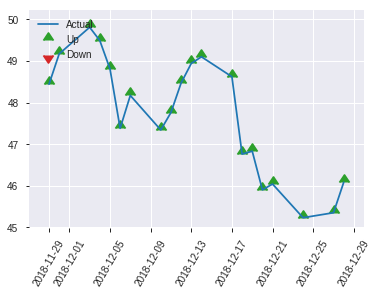


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25459259151146063
RMSE: 0.5045716911514762
LogLoss: 0.7029175458920663
Mean Per-Class Error: 0.44862707535121327
AUC: 0.5372286079182631
pr_auc: 0.5763233583322397
Gini: 0.0744572158365262
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23748557269573212: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    113  0.9741   (113.0/116.0)
1      0    135  0        (0.0/135.0)
Total  3    248  0.4502   (113.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.237486     0.704961  247
max f2                       0.237486     0.856599  247
max f0point5                 0.282154     0.600723  242
max accuracy                 0.287962     0.553785  240
max precision                0.587381     0.75      11
max recall                   0.237486     1         247
max specificity              0.684668     0.991379  0
max absolute_mcc             0.547332     0.137234  41
max min_per_class_accuracy   0.478853     0.511111  124
max mean_per_class_accuracy  0.547332     0.551373  41

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 46.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.617348           0.619753  0.619753           0.333333         0.650914  0.333333                    0.650914            0.00740741      0.00740741                 -38.0247  -38.0247
    2        0.0239044                   0.609551           1.85926   1.23951            1                0.609992  0.666667                    0.630453            0.0222222       0.0296296                  85.9259   23.9506
    3        0.0318725                   0.597822           0.92963   1.16204            0.5              0.605479  0.625                       0.62421             0.00740741      0.037037                   -7.03704  16.2037
    4        0.0438247                   0.590173           1.85926   1.35219            1                0.591108  0.727273                    0.615182            0.0222222       0.0592593                  85.9259   35.2189
    5        0.0517928                   0.58468            0.92963   1.28718            0.5              0.586414  0.692308                    0.610756            0.00740741      0.0666667                  -7.03704  28.7179
    6        0.103586                    0.566783           1.00114   1.14416            0.538462         0.575413  0.615385                    0.593085            0.0518519       0.118519                   0.11396   14.416
    7        0.151394                    0.550366           1.39444   1.2232             0.75             0.557216  0.657895                    0.581758            0.0666667       0.185185                   39.4444   22.3197
    8        0.203187                    0.54078            1.00114   1.16659            0.538462         0.545217  0.627451                    0.572443            0.0518519       0.237037                   0.11396   16.6594
    9        0.302789                    0.518372           1.11556   1.14981            0.6              0.530899  0.618421                    0.558777            0.111111        0.348148                   11.5556   14.9805
    10       0.40239                     0.500703           0.892444  1.0861             0.48             0.509025  0.584158                    0.546462            0.0888889       0.437037                   -10.7556  8.61019
    11       0.501992                    0.477362           0.743704  1.01817            0.4              0.486568  0.547619                    0.534579            0.0740741       0.511111                   -25.6296  1.81658
    12       0.601594                    0.45517            0.892444  0.997351           0.48             0.465546  0.536424                    0.523149            0.0888889       0.6                        -10.7556  -0.264901
    13       0.701195                    0.437858           0.966815  0.993013           0.52             0.446465  0.534091                    0.512257            0.0962963       0.696296                   -3.31852  -0.698653
    14       0.800797                    0.404678           1.11556   1.00826            0.6              0.425785  0.542289                    0.501502            0.111111        0.807407                   11.5556   0.825502
    15       0.900398                    0.364938           1.11556   1.02012            0.6              0.381417  0.548673                    0.488218            0.111111        0.918519                   11.5556   2.01245
    16       1                           0.186959           0.818074  1                  0.44             0.290455  0.537849                    0.46852     

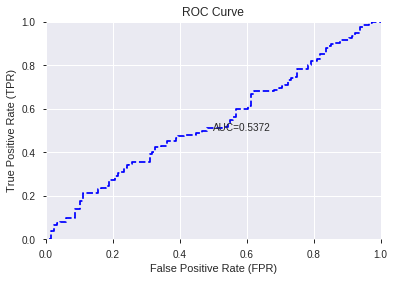

This function is available for GLM models only


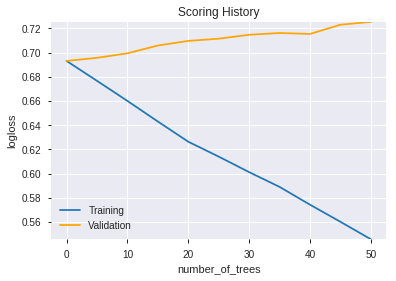

--2019-08-27 18:20:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.161.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.161.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_181916_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_181916_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_9b73',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [19]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190827_182018  0.546743  1.029577              0.477842  0.530363  0.281285
1  DeepLearning_grid_1_AutoML_20190827_182018_model_6  0.537356  0.756607              0.462484  0.518203  0.268534
2  DeepLearning_grid_1_AutoML_20190827_182018_model_4  0.532854  3.718666              0.468008  0.628031  0.394423
3  DeepLearning_grid_1_AutoML_20190827_182018_model_5  0.531897  0.742741              0.468008  0.513114  0.263286
4  DeepLearning_grid_1_AutoML_20190827_182018_model_3  0.524393  1.255105              0.468614  0.576675  0.332554
5  DeepLearning_grid_1_AutoML_20190827_182018_model_9  0.496648  0.693563              0.500000  0.500269  0.250269
6  DeepLearning_grid_1_AutoML_20190827_182018_model_8  0.471903  0.714505              0.490773  0.508412  0.258483
7  DeepLearning_grid_1_AutoML_20190827_182018_model_1  0.454470  2.277689              0.500000  0.614489  0.377597
8  DeepLearning_grid_1_AutoML_20190827_182018_model_2  0.428512  1.561694              0.500000  0.586075  0.343484
9  DeepLearning_grid_1_AutoML_20190827_182018_model_7  0.414368  0.941775              0.491379  0.559157  0.312656

variable  relative_importance  scaled_importance  percentage
0          CDLTASUKIGAP             1.000000           1.000000    0.028676
1               CDLDOJI             0.975749           0.975749    0.027981
2       CDLSHOOTINGSTAR             0.946948           0.946948    0.027155
3       CDLUNIQUE3RIVER             0.943689           0.943689    0.027061
4               weekday             0.915183           0.915183    0.026244
5                   EXP             0.878250           0.878250    0.025185
6             CORREL_14             0.872488           0.872488    0.025020
7          HT_TRENDMODE             0.828289           0.828289    0.023752
8                   BOP             0.824334           0.824334    0.023639
9                  COSH             0.823023           0.823023    0.023601
10    CDLINVERTEDHAMMER             0.812404           0.812404    0.023297
11    CDLGRAVESTONEDOJI             0.810043           0.810043    0.023229
12          CDLPIERCING             0.806302           0.806302    0.023122
13     is_quarter_start             0.803242           0.803242    0.023034
14                 SINH             0.796051           0.796051    0.022828
15            dayofweek             0.786804           0.786804    0.022563
16        days_in_month             0.752649           0.752649    0.021583
17    CDLDARKCLOUDCOVER             0.741313           0.741313    0.021258
18            CDLONNECK             0.740317           0.740317    0.021230
19            CDLHAMMER             0.728189           0.728189    0.020882
20     CDLABANDONEDBABY             0.718824           0.718824    0.020613
21  CDLGAPSIDESIDEWHITE             0.712214           0.712214    0.020424
22            CDLINNECK             0.709585           0.709585    0.020348
23            CDL2CROWS             0.690841           0.690841    0.019811
24          CDLDOJISTAR             0.690766           0.690766    0.019809
25       is_month_start             0.678854           0.678854    0.019467
26         is_month_end             0.677972           0.677972    0.019442
27      CDLADVANCEBLOCK             0.665407           0.665407    0.019081
28       is_quarter_end             0.656853           0.656853    0.018836
29   CDLMORNINGDOJISTAR             0.644001           0.644001    0.018468
30   CDLEVENINGDOJISTAR             0.640650           0.640650    0.018371
31    CDLSTALLEDPATTERN             0.615251           0.615251    0.017643
32           CDL3INSIDE             0.614029           0.614029    0.017608
33       CDLRICKSHAWMAN             0.611151           0.611151    0.017525
34              BETA_30             0.611089           0.611089    0.017524
35                  day             0.608113           0.608113    0.017438
36       CDLMORNINGSTAR             0.597733           0.597733    0.017141
37            CORREL_12             0.593569           0.593569    0.017021
38       CDLEVENINGSTAR             0.584812           0.584812    0.016770
39       CDLMATCHINGLOW             0.584120           0.584120    0.016750
40      CDLHOMINGPIGEON             0.574509           0.574509    0.016475
41      CDLLADDERBOTTOM             0.573330           0.573330    0.016441
42         weekday_name             0.560083           0.560083    0.016061
43   CDLSEPARATINGLINES             0.559556           0.559556    0.016046
44            CDLTAKURI             0.549767           0.549767    0.015765
45         CDLTHRUSTING             0.530095           0.530095    0.015201
46     CDLDRAGONFLYDOJI             0.511673           0.511673    0.014673
47     CDLSTICKSANDWICH             0.494618           0.494618    0.014184
48       STOCHRSI_fastk             0.443003           0.443003    0.012704
49        CDLHANGINGMAN             0.384366           0.384366    0.011022

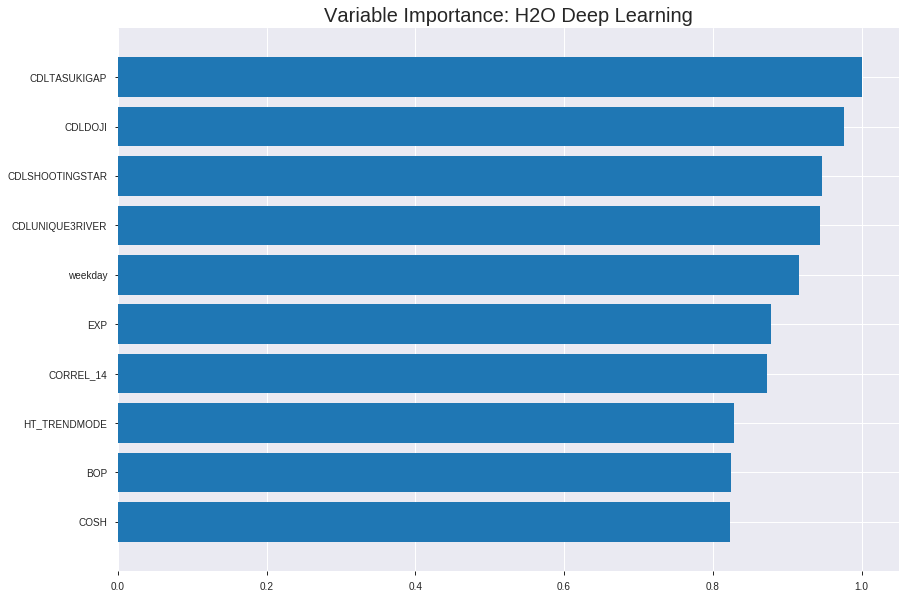

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190827_182018


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2347457445779298
RMSE: 0.48450567032587943
LogLoss: 0.6629405315413457
Mean Per-Class Error: 0.3976816370624936
AUC: 0.637058579469395
pr_auc: 0.6560307195242353
Gini: 0.2741171589387901
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40901077038397826: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      121  713   0.8549   (713.0/834.0)
1      50   869   0.0544   (50.0/919.0)
Total  171  1582  0.4353   (763.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.409011     0.694922  318
max f2                       0.0410461    0.847473  394
max f0point5                 0.522775     0.620845  214
max accuracy                 0.529269     0.602396  208
max precision                0.993265     1         0
max recall                   0.0410461    1         394
max specificity              0.993265     1         0
max absolute_mcc             0.588615     0.205855  148
max min_per_class_accuracy   0.529269     0.600719  208
max mean_per_class_accuracy  0.529269     0.602318  208

Gains/Lift Table: Avg response rate: 52.42 %, avg score: 53.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.85682            1.48362   1.48362            0.777778         0.916898  0.777778                    0.916898            0.0152339       0.0152339                  48.3617   48.3617
    2        0.0205362                   0.836273           1.69556   1.58959            0.888889         0.846468  0.833333                    0.881683            0.0174102       0.0326442                  69.5563   58.959
    3        0.0302339                   0.801268           1.6831    1.61958            0.882353         0.821165  0.849057                    0.862272            0.0163221       0.0489663                  68.3095   61.9582
    4        0.040502                    0.766731           1.48362   1.58511            0.777778         0.782801  0.830986                    0.842124            0.0152339       0.0642002                  48.3617   58.5112
    5        0.0501997                   0.754163           1.57089   1.58236            0.823529         0.762465  0.829545                    0.826735            0.0152339       0.0794342                  57.0889   58.2365
    6        0.100399                    0.689212           1.43063   1.5065             0.75             0.717096  0.789773                    0.771916            0.0718172       0.151251                   43.0631   50.6498
    7        0.150029                    0.650969           1.18397   1.39981            0.62069          0.667799  0.73384                     0.737474            0.0587595       0.210011                   18.3971   39.9806
    8        0.200228                    0.617415           1.23555   1.35862            0.647727         0.634445  0.712251                    0.711643            0.0620239       0.272035                   23.5545   35.8624
    9        0.300057                    0.579184           1.1336    1.28376            0.594286         0.596218  0.673004                    0.673241            0.113166        0.385201                   13.3605   28.376
    10       0.399886                    0.557319           1.0355    1.22178            0.542857         0.567446  0.640514                    0.64683             0.103373        0.488575                   3.55044   22.1785
    11       0.500285                    0.530231           1.0513    1.18757            0.551136         0.544096  0.622577                    0.626213            0.10555         0.594124                   5.12971   18.7571
    12       0.600114                    0.505622           0.948304  1.14777            0.497143         0.518509  0.601711                    0.608296            0.0946681       0.688792                   -5.16959  14.7769
    13       0.699943                    0.479728           0.882904  1.10999            0.462857         0.492659  0.581907                    0.591804            0.0881393       0.776931                   -11.7096  10.9993
    14       0.799772                    0.451669           0.730303  1.0626             0.382857         0.46584   0.557061                    0.576081            0.0729053       0.849837                   -26.9697  6.25991
    15       0.899601                    0.409655           0.937404  1.04871            0.491429         0.432481  0.549778                    0.560145            0.09358         0.943417                   -6.2596   4.87061
    16       1                           0.000682358        0.563582  1                  0.295455         0.320737  0.524244                    0.536109           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2664230734220757
RMSE: 0.5161618674622097
LogLoss: 0.7480352309200512
Mean Per-Class Error: 0.4748280275155975
AUC: 0.5035674292113261
pr_auc: 0.5349843199768852
Gini: 0.007134858422652268
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.011229208218111504: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    235  1        (235.0/235.0)
1      0    266  0        (0.0/266.0)
Total  0    501  0.4691   (235.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0112292    0.693611   399
max f2                       0.0112292    0.84984    399
max f0point5                 0.0112292    0.585903   399
max accuracy                 0.291254     0.530938   389
max precision                0.827713     0.666667   14
max recall                   0.0112292    1          399
max specificity              0.995279     0.995745   0
max absolute_mcc             0.991138     0.0673553  1
max min_per_class_accuracy   0.531922     0.503759   208
max mean_per_class_accuracy  0.55705      0.525172   174

Gains/Lift Table: Avg response rate: 53.09 %, avg score: 54.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.902587           0.62782   0.62782            0.333333         0.948937  0.333333                    0.948937            0.0075188       0.0075188                  -37.218   -37.218
    2        0.0219561                   0.853322           1.50677   1.02734            0.8              0.873939  0.545455                    0.914847            0.0150376       0.0225564                  50.6767   2.73411
    3        0.0319361                   0.813267           1.50677   1.17716            0.8              0.83406   0.625                       0.889601            0.0150376       0.037594                   50.6767   17.7162
    4        0.0419162                   0.799076           0.376692  0.986574           0.2              0.807094  0.52381                     0.869957            0.0037594       0.0413534                  -62.3308  -1.34264
    5        0.0518962                   0.781062           1.50677   1.08661            0.8              0.788669  0.576923                    0.854324            0.0150376       0.056391                   50.6767   8.66108
    6        0.101796                    0.70983            1.05474   1.07099            0.56             0.736073  0.568627                    0.796358            0.0526316       0.109023                   5.47368   7.09863
    7        0.151697                    0.668508           0.828722  0.991294           0.44             0.684917  0.526316                    0.7597              0.0413534       0.150376                   -17.1278  -0.870598
    8        0.201597                    0.628913           1.05474   1.007              0.56             0.645783  0.534653                    0.731502            0.0526316       0.203008                   5.47368   0.699769
    9        0.301397                    0.584625           1.16774   1.06023            0.62             0.60694   0.562914                    0.690257            0.116541        0.319549                   16.7744   6.02251
    10       0.401198                    0.55705            1.05474   1.05886            0.56             0.570212  0.562189                    0.660395            0.105263        0.424812                   5.47368   5.88598
    11       0.500998                    0.531506           0.791053  1.00551            0.42             0.542468  0.533865                    0.636903            0.0789474       0.503759                   -20.8947  0.551179
    12       0.600798                    0.501332           1.01707   1.00743            0.54             0.516345  0.534884                    0.616877            0.101504        0.605263                   1.70677   0.743137
    13       0.700599                    0.479005           0.941729  0.998072           0.5              0.489463  0.529915                    0.598727            0.093985        0.699248                   -5.82707  -0.19279
    14       0.800399                    0.445219           0.828722  0.976956           0.44             0.464089  0.518703                    0.581939            0.0827068       0.781955                   -17.1278  -2.30439
    15       0.9002                      0.409573           1.16774   0.998108           0.62             0.42783   0.529933                    0.564854            0.116541        0.898496                   16.7744   -0.18922
    16       1                           0.0112292          1.01707   1                  0.54             0.32964   0.530938                    0.541379


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:20:18  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 18:20:18  0.054 sec   79681 obs/sec     1         1             1753       0.533624         0.899805            -0.141701      0.528937        0.539042           1.05973          0.475756                         0.543409           0.936722              -0.185713        0.493985          0.520381             0.941729           0.469062
    2019-08-27 18:20:18  0.276 sec   83080 obs/sec     10        10            17530      0.484506         0.662941            0.0588042      0.637059        0.656031           1.48362          0.435254                         0.516162           0.748035              -0.0697882       0.503567          0.534984             0.62782            0.469062

Variable Importances: 


variable          relative_importance    scaled_importance    percentage
----------------  ---------------------  -------------------  --------------------
CDLTASUKIGAP      1.0                    1.0                  0.028676217861387066
CDLDOJI           0.975749135017395      0.975749135017395    0.027980794773818804
CDLSHOOTINGSTAR   0.9469479918479919     0.9469479918479919   0.027154886917636
CDLUNIQUE3RIVER   0.9436890482902527     0.9436890482902527   0.027061432742176306
weekday           0.9151833057403564     0.9151833057403564   0.02624399585851487
---               ---                    ---                  ---
CDLTHRUSTING      0.5300951600074768     0.5300951600074768   0.015201124295641242
CDLDRAGONFLYDOJI  0.5116729736328125     0.5116729736328125   0.01467284566567829
CDLSTICKSANDWICH  0.49461835622787476    0.49461835622787476  0.014183783741431692
STOCHRSI_fastk    0.4430026113986969     0.4430026113986969   0.012703639397632426
CDLHANGINGMAN     0.3843664824962616     0.3843664824962616   0.011022176990677816


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5697211155378487)

('F1', 0.7071240105540898)

('auc', 0.5467432950191571)

('logloss', 1.029576938039591)

('mean_per_class_error', 0.4492656449553001)

('rmse', 0.5303634251960856)

('mse', 0.28128536278572386)

deeplearning prediction progress: |███████████████████████████████████████| 100%


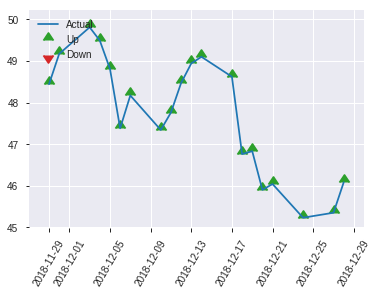


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.28128536278572386
RMSE: 0.5303634251960856
LogLoss: 1.029576938039591
Mean Per-Class Error: 0.4492656449553001
AUC: 0.5467432950191571
pr_auc: 0.5796893400474623
Gini: 0.09348659003831417
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.199759601493773e-06: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    110  0.9483   (110.0/116.0)
1      1    134  0.0074   (1.0/135.0)
Total  7    244  0.4422   (111.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.19976e-06  0.707124  243
max f2                       3.98413e-09  0.855513  248
max f0point5                 0.00164843   0.609185  232
max accuracy                 0.00164843   0.569721  232
max precision                0.998261     1         0
max recall                   3.98413e-09  1         248
max specificity              0.998261     1         0
max absolute_mcc             0.00164843   0.144987  232
max min_per_class_accuracy   0.477122     0.525926  124
max mean_per_class_accuracy  0.433867     0.550734  162

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 43.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.839858           1.85926   1.85926            1                0.940901   1                           0.940901            0.0222222       0.0222222                  85.9259   85.9259
    2        0.0239044                   0.771426           1.23951   1.54938            0.666667         0.791393   0.833333                    0.866147            0.0148148       0.037037                   23.9506   54.9383
    3        0.0318725                   0.736493           0.92963   1.39444            0.5              0.755527   0.75                        0.838492            0.00740741      0.0444444                  -7.03704  39.4444
    4        0.0438247                   0.720436           0.619753  1.18316            0.333333         0.725718   0.636364                    0.807736            0.00740741      0.0518519                  -38.0247  18.3165
    5        0.0517928                   0.708269           0.92963   1.14416            0.5              0.713073   0.615385                    0.793172            0.00740741      0.0592593                  -7.03704  14.416
    6        0.103586                    0.651612           1.14416   1.14416            0.615385         0.670192   0.615385                    0.731682            0.0592593       0.118519                   14.416    14.416
    7        0.151394                    0.604476           1.08457   1.12534            0.583333         0.62239    0.605263                    0.697169            0.0518519       0.17037                    8.45679   12.5341
    8        0.203187                    0.580426           1.00114   1.09368            0.538462         0.591676   0.588235                    0.670278            0.0518519       0.222222                   0.11396   9.36819
    9        0.302789                    0.541142           0.892444  1.02749            0.48             0.560718   0.552632                    0.634239            0.0888889       0.311111                   -10.7556  2.74854
    10       0.40239                     0.503811           1.11556   1.04928            0.6              0.520061   0.564356                    0.605977            0.111111        0.422222                   11.5556   4.92849
    11       0.501992                    0.476871           1.04119   1.04768            0.56             0.490452   0.563492                    0.583055            0.103704        0.525926                   4.11852   4.76778
    12       0.601594                    0.451526           0.966815  1.03429            0.52             0.465084   0.556291                    0.563524            0.0962963       0.622222                   -3.31852  3.42899
    13       0.701195                    0.394052           1.18993   1.0564             0.64             0.429818   0.568182                    0.544531            0.118519        0.740741                   18.9926   5.63973
    14       0.800797                    0.316614           0.966815  1.04526            0.52             0.358003   0.562189                    0.521331            0.0962963       0.837037                   -3.31852  4.52552
    15       0.900398                    0.00925517         0.892444  1.02835            0.48             0.142964   0.553097                    0.479477            0.0888889       0.925926                   -10.7556  2.83514
    16       1                           1.2498e-10         0.743704  1                  0.4              0.0017026  0.537849                    0

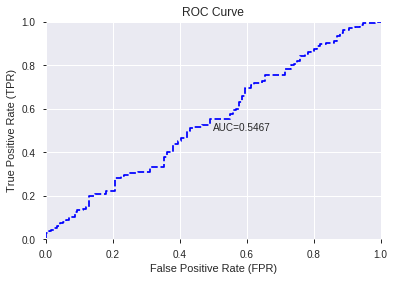

This function is available for GLM models only


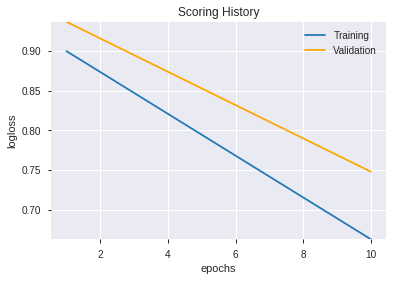

--2019-08-27 18:27:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.8.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.8.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190827_182018',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190827_182018',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_9b73',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_50_sid_9b73'

['CDLTASUKIGAP',
 'CDLDOJI',
 'CDLSHOOTINGSTAR',
 'CDLUNIQUE3RIVER',
 'weekday',
 'EXP',
 'CORREL_14',
 'HT_TRENDMODE',
 'BOP',
 'COSH',
 'CDLINVERTEDHAMMER',
 'CDLGRAVESTONEDOJI',
 'CDLPIERCING',
 'is_quarter_start',
 'SINH',
 'dayofweek',
 'days_in_month',
 'CDLDARKCLOUDCOVER',
 'CDLONNECK',
 'CDLHAMMER',
 'CDLABANDONEDBABY',
 'CDLGAPSIDESIDEWHITE',
 'CDLINNECK',
 'CDL2CROWS',
 'CDLDOJISTAR',
 'is_month_start',
 'is_month_end',
 'CDLADVANCEBLOCK',
 'is_quarter_end',
 'CDLMORNINGDOJISTAR',
 'CDLEVENINGDOJISTAR',
 'CDLSTALLEDPATTERN',
 'CDL3INSIDE',
 'CDLRICKSHAWMAN',
 'BETA_30',
 'day',
 'CDLMORNINGSTAR',
 'CORREL_12',
 'CDLEVENINGSTAR',
 'CDLMATCHINGLOW',
 'CDLHOMINGPIGEON',
 'CDLLADDERBOTTOM',
 'weekday_name',
 'CDLSEPARATINGLINES',
 'CDLTAKURI',
 'CDLTHRUSTING',
 'CDLDRAGONFLYDOJI',
 'CDLSTICKSANDWICH',
 'STOCHRSI_fastk',
 'CDLHANGINGMAN']

In [20]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_182728_model_1  0.529438  0.687522              0.459994  0.497488  0.247495

variable  relative_importance  scaled_importance  percentage
0                   day             0.061303           1.000000    0.059766
1                   BOP             0.052955           0.863828    0.051627
2    CDLEVENINGDOJISTAR             0.049083           0.800662    0.047852
3             CORREL_12             0.043532           0.710113    0.042441
4             CDLINNECK             0.041221           0.672410    0.040187
5      is_quarter_start             0.040764           0.664961    0.039742
6       CDLUNIQUE3RIVER             0.040061           0.653498    0.039057
7               CDLDOJI             0.039489           0.644164    0.038499
8         CDLHANGINGMAN             0.037282           0.608166    0.036348
9          CDLTASUKIGAP             0.035863           0.585006    0.034963
10            dayofweek             0.034022           0.554983    0.033169
11              weekday             0.033992           0.554488    0.033139
12       is_quarter_end             0.030885           0.503815    0.030111
13       CDLEVENINGSTAR             0.030552           0.498376    0.029786
14       CDLMATCHINGLOW             0.029717           0.484751    0.028972
15            CDLHAMMER             0.029673           0.484041    0.028929
16         weekday_name             0.028975           0.472645    0.028248
17           CDL3INSIDE             0.028203           0.460051    0.027495
18     CDLABANDONEDBABY             0.025847           0.421627    0.025199
19              BETA_30             0.024730           0.403408    0.024110
20    CDLGRAVESTONEDOJI             0.023626           0.385393    0.023033
21         HT_TRENDMODE             0.022054           0.359759    0.021501
22       is_month_start             0.021730           0.354472    0.021185
23      CDLHOMINGPIGEON             0.020869           0.340427    0.020346
24            CDL2CROWS             0.018953           0.309173    0.018478
25            CDLTAKURI             0.018295           0.298433    0.017836
26      CDLADVANCEBLOCK             0.015106           0.246417    0.014727
27         CDLTHRUSTING             0.013519           0.220533    0.013180
28  CDLGAPSIDESIDEWHITE             0.013508           0.220353    0.013170
29          CDLPIERCING             0.011629           0.189703    0.011338
30    CDLSTALLEDPATTERN             0.010902           0.177841    0.010629
31        days_in_month             0.010702           0.174573    0.010434
32   CDLMORNINGDOJISTAR             0.010475           0.170865    0.010212
33   CDLSEPARATINGLINES             0.010408           0.169784    0.010147
34            CORREL_14             0.009060           0.147790    0.008833
35         is_month_end             0.007979           0.130155    0.007779
36          CDLDOJISTAR             0.006710           0.109453    0.006542
37    CDLINVERTEDHAMMER             0.006274           0.102348    0.006117
38     CDLDRAGONFLYDOJI             0.005774           0.094182    0.005629
39       CDLRICKSHAWMAN             0.004958           0.080881    0.004834
40       CDLMORNINGSTAR             0.004582           0.074740    0.004467
41    CDLDARKCLOUDCOVER             0.003587           0.058505    0.003497
42       STOCHRSI_fastk             0.003320           0.054154    0.003237
43                  EXP             0.003148           0.051350    0.003069
44                 COSH             0.003102           0.050600    0.003024
45            CDLONNECK             0.003078           0.050214    0.003001
46                 SINH             0.003074           0.050138    0.002997
47     CDLSTICKSANDWICH             0.000609           0.009934    0.000594
48      CDLSHOOTINGSTAR             0.000344           0.005611    0.000335
49      CDLLADDERBOTTOM             0.000195           0.003175    0.000190

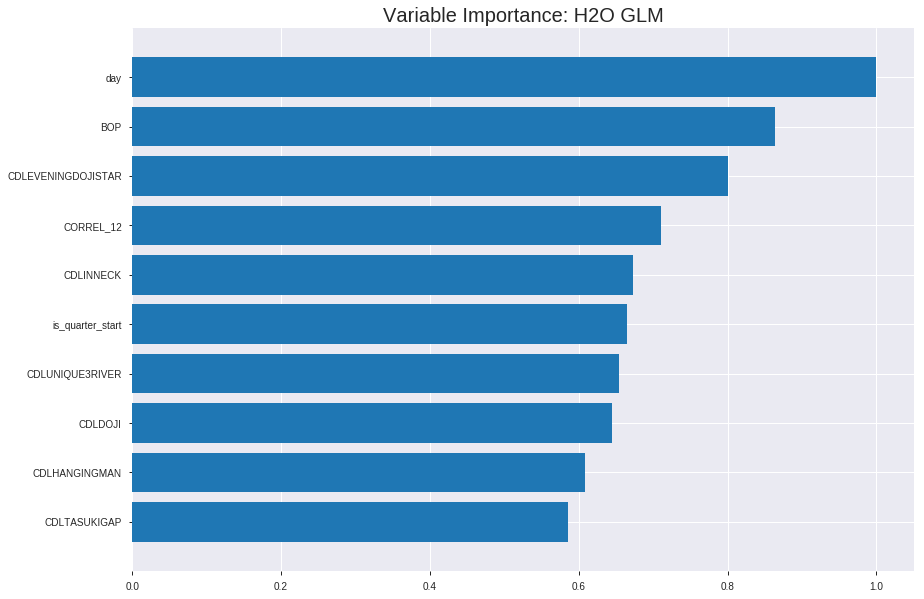

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_182728_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24438291967994527
RMSE: 0.49435100857583497
LogLoss: 0.6816684872114332
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2426.050892509706
Residual deviance: 2389.929716163285
AIC: 2491.929716163285
AUC: 0.5790825446280625
pr_auc: 0.6025020885411994
Gini: 0.15816508925612505
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4455312234022103: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      47   787   0.9436   (787.0/834.0)
1      16   903   0.0174   (16.0/919.0)
Total  63   1690  0.4581   (803.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.445531     0.692219  349
max f2                       0.367362     0.847035  383
max f0point5                 0.504444     0.590584  246
max accuracy                 0.506718     0.559612  240
max precision                0.80539      1         0
max recall                   0.318444     1         395
max specificity              0.80539      1         0
max absolute_mcc             0.535658     0.127968  162
max min_per_class_accuracy   0.526253     0.55036   190
max mean_per_class_accuracy  0.535658     0.562608  162

Gains/Lift Table: Avg response rate: 52.42 %, avg score: 52.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.640166           1.58959   1.58959            0.833333         0.673697  0.833333                    0.673697            0.0163221       0.0163221                  58.959    58.959
    2        0.0205362                   0.625192           1.37764   1.48362            0.722222         0.63061   0.777778                    0.652153            0.0141458       0.0304679                  37.7645   48.3617
    3        0.0302339                   0.608074           1.45868   1.47562            0.764706         0.615251  0.773585                    0.640317            0.0141458       0.0446137                  45.8683   47.562
    4        0.040502                    0.592954           0.847781  1.31645            0.444444         0.600855  0.690141                    0.630312            0.00870511      0.0533188                  -15.2219  31.6449
    5        0.0501997                   0.587432           1.34648   1.32225            0.705882         0.590983  0.693182                    0.622715            0.0130577       0.0663765                  34.6476   32.225
    6        0.100399                    0.571253           1.19219   1.25722            0.625            0.578225  0.659091                    0.60047             0.0598477       0.126224                   19.2193   25.7221
    7        0.150029                    0.562626           1.24975   1.25475            0.655172         0.566606  0.657795                    0.589268            0.0620239       0.188248                   24.9747   25.4749
    8        0.200228                    0.555507           1.04046   1.20102            0.545455         0.558595  0.62963                     0.581578            0.0522307       0.240479                   4.0459    20.1024
    9        0.300057                    0.544336           1.1009    1.16771            0.577143         0.549161  0.612167                    0.570793            0.109902        0.350381                   10.0905   16.7714
    10       0.399886                    0.534854           1.0682    1.14287            0.56             0.539631  0.599144                    0.563013            0.106638        0.457018                   6.82046   14.2872
    11       0.500285                    0.526271           0.932078  1.10057            0.488636         0.53069   0.576967                    0.556527            0.09358         0.550598                   -6.79221  10.0569
    12       0.600114                    0.517704           0.926504  1.07161            0.485714         0.522366  0.561787                    0.550844            0.0924918       0.64309                    -7.3496   7.16134
    13       0.699943                    0.506728           1.0355    1.06646            0.542857         0.511959  0.559087                    0.545298            0.103373        0.746464                   3.55044   6.64634
    14       0.799772                    0.494955           0.893804  1.04491            0.468571         0.501196  0.547789                    0.539793            0.0892274       0.835691                   -10.6196  4.49117
    15       0.899601                    0.475718           0.872004  1.02572            0.457143         0.486491  0.53773                     0.533878            0.0870511       0.922742                   -12.7996  2.57241
    16       1                           0.195891           0.769506  1                  0.403409         0.437921  0.524244                    0.524244            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24695977238484018
RMSE: 0.49695047276850457
LogLoss: 0.6871081646425712
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 692.7041364892402
Residual deviance: 688.4823809718563
AIC: 790.4823809718563
AUC: 0.5622620380739082
pr_auc: 0.5836889468979217
Gini: 0.12452407614781635
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3433318863301462: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    234  0.9957   (234.0/235.0)
1      0    266  0        (0.0/266.0)
Total  1    500  0.4671   (234.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.343332     0.694517  398
max f2                       0.343332     0.850384  398
max f0point5                 0.530869     0.596252  178
max accuracy                 0.530869     0.57485   178
max precision                0.687387     0.75      3
max recall                   0.343332     1         398
max specificity              0.732305     0.995745  0
max absolute_mcc             0.536352     0.157342  161
max min_per_class_accuracy   0.525947     0.548936  197
max mean_per_class_accuracy  0.530869     0.578052  178

Gains/Lift Table: Avg response rate: 53.09 %, avg score: 52.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.666665           1.25564   1.25564            0.666667         0.692468  0.666667                    0.692468            0.0150376       0.0150376                  25.5639   25.5639
    2        0.0219561                   0.636446           1.13008   1.19856            0.6              0.64484   0.636364                    0.670819            0.0112782       0.0263158                  13.0075   19.8565
    3        0.0319361                   0.613859           1.50677   1.29488            0.8              0.622939  0.6875                      0.655856            0.0150376       0.0413534                  50.6767   29.4878
    4        0.0419162                   0.609604           1.13008   1.25564            0.6              0.611854  0.666667                    0.64538             0.0112782       0.0526316                  13.0075   25.5639
    5        0.0518962                   0.602568           0.753383  1.15905            0.4              0.6055    0.615385                    0.63771             0.0075188       0.0601504                  -24.6617  15.9051
    6        0.101796                    0.573228           1.28075   1.21871            0.68             0.582795  0.647059                    0.610791            0.0639098       0.12406                    28.0752   21.8709
    7        0.151697                    0.564254           1.05474   1.16477            0.56             0.567269  0.618421                    0.596475            0.0526316       0.176692                   5.47368   16.477
    8        0.201597                    0.556021           0.979398  1.11889            0.52             0.559674  0.594059                    0.587366            0.0488722       0.225564                   -2.06015  11.8886
    9        0.301397                    0.54517            1.13008   1.12259            0.6              0.549787  0.596026                    0.574923            0.112782        0.338346                   13.0075   12.2591
    10       0.401198                    0.536352           1.35609   1.18068            0.72             0.54007   0.626866                    0.566253            0.135338        0.473684                   35.609    18.0676
    11       0.500998                    0.52604            0.753383  1.09556            0.4              0.531021  0.581673                    0.559234            0.075188        0.548872                   -24.6617  9.55576
    12       0.600798                    0.516858           0.866391  1.05749            0.46             0.521014  0.561462                    0.552885            0.0864662       0.635338                   -13.3609  5.74901
    13       0.700599                    0.506855           1.01707   1.05173            0.54             0.511743  0.558405                    0.547025            0.101504        0.736842                   1.70677   5.17319
    14       0.800399                    0.494342           0.753383  1.01453            0.4              0.50009   0.538653                    0.541173            0.075188        0.81203                    -24.6617  1.45313
    15       0.9002                      0.473986           0.979398  1.01064            0.52             0.483999  0.536585                    0.534834            0.0977444       0.909774                   -2.06015  1.06363
    16       1                           0.335197           0.90406   1                  0.48             0.445597  0.530938                    0.525928          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 18:27:29  0.000 sec   2            3.2       51            1.38004           1.38021
    2019-08-27 18:27:29  0.010 sec   4            2         51            1.37817           1.37911
    2019-08-27 18:27:29  0.020 sec   6            1.2       51            1.37571           1.37776
    2019-08-27 18:27:29  0.031 sec   8            0.76      51            1.37274           1.37632
    2019-08-27 18:27:29  0.042 sec   10           0.47      51            1.36948           1.37505
    2019-08-27 18:27:29  0.052 sec   12           0.29      51            1.36625           1.37427
    2019-08-27 18:27:29  0.059 sec   14           0.18      51            1.36334           1.37422
    2019-08-27 18:27:29  0.075 sec   16           0.11      51            1.36093           1.37492
    2019-08-27 18:27:29  0.088 sec   18           0.07      51            1.35906           1.37623
    2019-08-27 18:27:29  0.102 sec   20           0.043     51            1.35767           1.37793
    2019-08-27 18:27:29  0.112 sec   22           0.027     51            1.35669           1.37977
    2019-08-27 18:27:29  0.124 sec   24           0.017     51            1.35599           1.38161

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5737051792828686)

('F1', 0.71313672922252)

('auc', 0.5294380587484036)

('logloss', 0.6875218755069451)

('mean_per_class_error', 0.4461047254150703)

('rmse', 0.49748821592460185)

('mse', 0.24749452498384325)

glm prediction progress: |████████████████████████████████████████████████| 100%


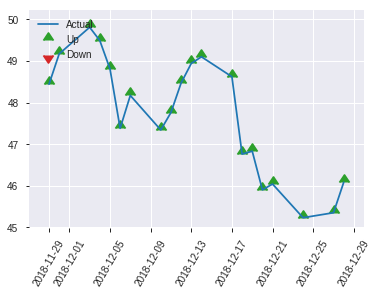


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24749452498384325
RMSE: 0.49748821592460185
LogLoss: 0.6875218755069451
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 346.70670784719556
Residual deviance: 345.13598150448644
AIC: 447.13598150448644
AUC: 0.5294380587484036
pr_auc: 0.5465712388880877
Gini: 0.0588761174968071
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3830674605843487: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      11   105  0.9052   (105.0/116.0)
1      2    133  0.0148   (2.0/135.0)
Total  13   238  0.4263   (107.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.383067     0.713137  237
max f2                       0.327242     0.856777  241
max f0point5                 0.383067     0.611776  237
max accuracy                 0.383067     0.573705  237
max precision                0.670904     1         0
max recall                   0.237708     1         248
max specificity              0.670904     1         0
max absolute_mcc             0.383067     0.180009  237
max min_per_class_accuracy   0.513246     0.518519  124
max mean_per_class_accuracy  0.48131      0.553895  178

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 49.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.606503           1.23951   1.23951            0.666667         0.636776  0.666667                    0.636776            0.0148148       0.0148148                  23.9506   23.9506
    2        0.0239044                   0.59561            0         0.619753           0                0.601004  0.333333                    0.61889             0               0.0148148                  -100      -38.0247
    3        0.0318725                   0.585496           0.92963   0.697222           0.5              0.587357  0.375                       0.611007            0.00740741      0.0222222                  -7.03704  -30.2778
    4        0.0438247                   0.581254           1.85926   1.01414            1                0.582698  0.545455                    0.603286            0.0222222       0.0444444                  85.9259   1.41414
    5        0.0517928                   0.57846            0.92963   1.00114            0.5              0.580437  0.538462                    0.599771            0.00740741      0.0518519                  -7.03704  0.11396
    6        0.103586                    0.5639             1.14416   1.07265            0.615385         0.570107  0.576923                    0.584939            0.0592593       0.111111                   14.416    7.26496
    7        0.151394                    0.554547           0.92963   1.02749            0.5              0.559287  0.552632                    0.576838            0.0444444       0.155556                   -7.03704  2.74854
    8        0.203187                    0.549641           0.7151    0.947858           0.384615         0.552055  0.509804                    0.570521            0.037037        0.192593                   -28.49    -5.21423
    9        0.302789                    0.534841           1.04119   0.978558           0.56             0.543548  0.526316                    0.561648            0.103704        0.296296                   4.11852   -2.14425
    10       0.40239                     0.523113           1.18993   1.03088            0.64             0.528305  0.554455                    0.553395            0.118519        0.414815                   18.9926   3.08764
    11       0.501992                    0.513235           1.04119   1.03292            0.56             0.517777  0.555556                    0.546328            0.103704        0.518519                   4.11852   3.29218
    12       0.601594                    0.496713           1.18993   1.05892            0.64             0.502706  0.569536                    0.539106            0.118519        0.637037                   18.9926   5.89159
    13       0.701195                    0.482961           1.04119   1.0564             0.56             0.489564  0.568182                    0.532068            0.103704        0.740741                   4.11852   5.63973
    14       0.800797                    0.459396           0.743704  1.01751            0.4              0.471663  0.547264                    0.524555            0.0740741       0.814815                   -25.6296  1.75051
    15       0.900398                    0.420797           1.11556   1.02835            0.6              0.44012   0.553097                    0.515215            0.111111        0.925926                   11.5556   2.83514
    16       1                           0.119118           0.743704  1                  0.4              0.340037  0.537849                    0.497767     

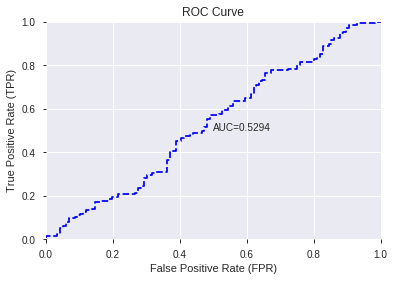

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


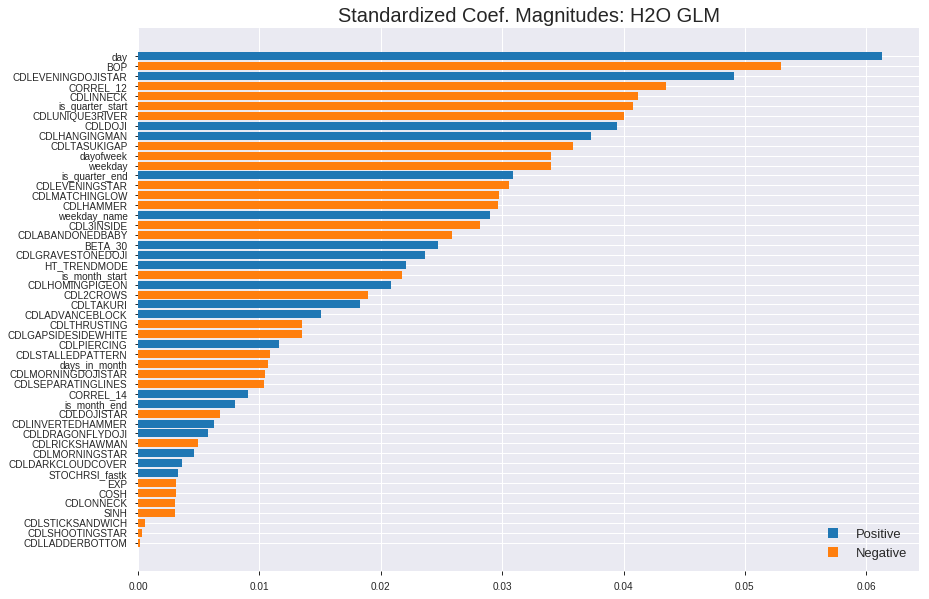

'log_likelihood'
--2019-08-27 18:27:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.164.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.164.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_182728_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_182728_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_9b73',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['day',
 'BOP',
 'CDLEVENINGDOJISTAR',
 'CORREL_12',
 'CDLINNECK',
 'is_quarter_start',
 'CDLUNIQUE3RIVER',
 'CDLDOJI',
 'CDLHANGINGMAN',
 'CDLTASUKIGAP',
 'dayofweek',
 'weekday',
 'is_quarter_end',
 'CDLEVENINGSTAR',
 'CDLMATCHINGLOW',
 'CDLHAMMER',
 'weekday_name',
 'CDL3INSIDE',
 'CDLABANDONEDBABY',
 'BETA_30',
 'CDLGRAVESTONEDOJI',
 'HT_TRENDMODE',
 'is_month_start',
 'CDLHOMINGPIGEON',
 'CDL2CROWS',
 'CDLTAKURI',
 'CDLADVANCEBLOCK',
 'CDLTHRUSTING',
 'CDLGAPSIDESIDEWHITE',
 'CDLPIERCING',
 'CDLSTALLEDPATTERN',
 'days_in_month',
 'CDLMORNINGDOJISTAR',
 'CDLSEPARATINGLINES',
 'CORREL_14',
 'is_month_end',
 'CDLDOJISTAR',
 'CDLINVERTEDHAMMER',
 'CDLDRAGONFLYDOJI',
 'CDLRICKSHAWMAN',
 'CDLMORNINGSTAR',
 'CDLDARKCLOUDCOVER',
 'STOCHRSI_fastk',
 'EXP',
 'COSH',
 'CDLONNECK',
 'SINH',
 'CDLSTICKSANDWICH',
 'CDLSHOOTINGSTAR',
 'CDLLADDERBOTTOM']

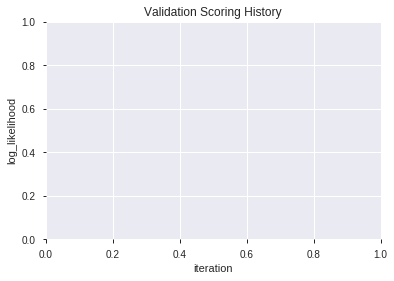

In [21]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_182740_model_4  0.536079  0.691300              0.495690  0.499094  0.249095
1               XGBoost_2_AutoML_20190827_182740  0.534738  0.698471              0.500000  0.502540  0.252546
2  XGBoost_grid_1_AutoML_20190827_182740_model_2  0.519987  0.696577              0.500000  0.501659  0.251662
3  XGBoost_grid_1_AutoML_20190827_182740_model_6  0.517369  0.698845              0.495690  0.502702  0.252709
4  XGBoost_grid_1_AutoML_20190827_182740_model_5  0.513729  0.725224              0.500000  0.513636  0.263822
5               XGBoost_1_AutoML_20190827_182740  0.512197  0.707303              0.495690  0.506677  0.256721
6  XGBoost_grid_1_AutoML_20190827_182740_model_3  0.508876  0.707289              0.490166  0.506755  0.256800
7  XGBoost_grid_1_AutoML_20190827_182740_model_1  0.501341  0.700371              0.500000  0.503637  0.253651
8               XGBoost_3_AutoML_20190827_182740  0.491762  0.708645              0.500000  0.507452  0.257508
9  XGBoost_grid_1_AutoML_20190827_182740_model_7  0.487803  0.719968              0.500000  0.512498  0.262654

variable  relative_importance  scaled_importance  percentage
0        CORREL_12           303.692841           1.000000    0.165749
1          BETA_30           253.719147           0.835447    0.138474
2              day           248.912979           0.819621    0.135851
3              BOP           236.215195           0.777810    0.128921
4        CORREL_14           236.084808           0.777380    0.128850
5             COSH           216.525467           0.712975    0.118175
6   STOCHRSI_fastk           154.179611           0.507683    0.084148
7        dayofweek            87.331902           0.287567    0.047664
8     weekday_name            35.550426           0.117060    0.019403
9     HT_TRENDMODE            20.984158           0.069097    0.011453
10         CDLDOJI            18.495783           0.060903    0.010095
11   days_in_month            13.104195           0.043150    0.007152
12         weekday             7.451707           0.024537    0.004067

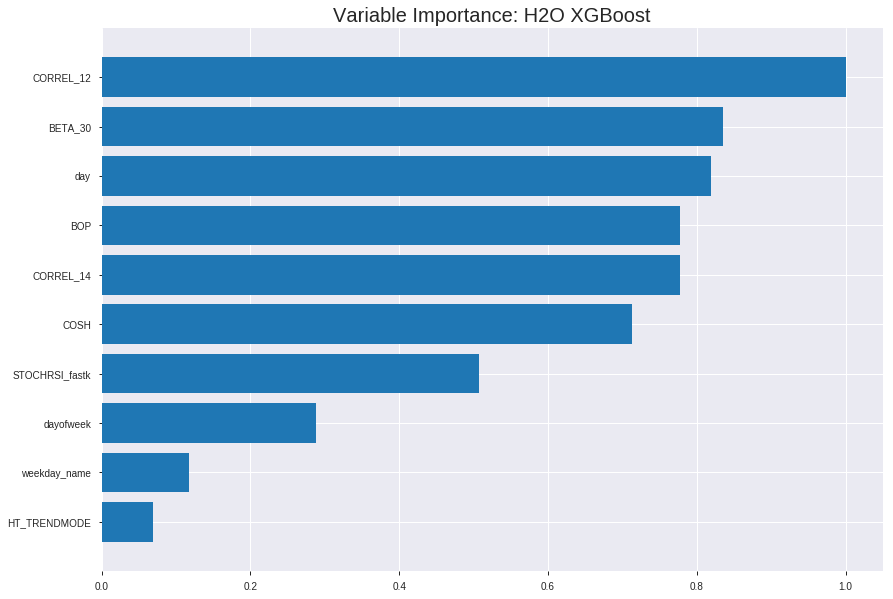

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_182740_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.23070081884259636
RMSE: 0.48031325074642317
LogLoss: 0.6540444612751488
Mean Per-Class Error: 0.3420025676955716
AUC: 0.7150555942623485
pr_auc: 0.7221441662180103
Gini: 0.4301111885246971
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46210118797090316: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      229  605   0.7254   (605.0/834.0)
1      68   851   0.074    (68.0/919.0)
Total  297  1456  0.3839   (673.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.462101     0.716632  309
max f2                       0.410906     0.850866  369
max f0point5                 0.529986     0.676049  188
max accuracy                 0.503802     0.662293  237
max precision                0.728983     1         0
max recall                   0.388126     1         387
max specificity              0.728983     1         0
max absolute_mcc             0.503802     0.321706  237
max min_per_class_accuracy   0.519075     0.647443  207
max mean_per_class_accuracy  0.523153     0.657997  200

Gains/Lift Table: Avg response rate: 52.42 %, avg score: 51.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.657525           1.80154   1.80154            0.944444         0.682857  0.944444                    0.682857            0.0184984       0.0184984                  80.1535    80.1535
    2        0.0205362                   0.63756            1.69556   1.74855            0.888889         0.645514  0.916667                    0.664185            0.0174102       0.0359086                  69.5563    74.8549
    3        0.0302339                   0.627807           1.6831    1.72755            0.882353         0.63185   0.90566                     0.653814            0.0163221       0.0522307                  68.3095    72.7555
    4        0.040502                    0.619659           1.58959   1.69258            0.833333         0.622973  0.887324                    0.645995            0.0163221       0.0685528                  58.959     69.2578
    5        0.0501997                   0.615855           1.45868   1.64739            0.764706         0.617724  0.863636                    0.640534            0.0141458       0.0826986                  45.8683    64.7393
    6        0.100399                    0.595051           1.3656    1.5065             0.715909         0.604361  0.789773                    0.622447            0.0685528       0.151251                   36.5602    50.6498
    7        0.150029                    0.582964           1.5567    1.52311            0.816092         0.588429  0.798479                    0.611194            0.0772579       0.228509                   55.6702    52.3105
    8        0.200228                    0.570931           1.38728   1.48905            0.727273         0.576707  0.780627                    0.602548            0.0696409       0.29815                    38.7279    48.9052
    9        0.300057                    0.552869           1.28621   1.42157            0.674286         0.56169   0.745247                    0.588954            0.1284          0.426551                   28.6206    42.1565
    10       0.399886                    0.535167           1.18811   1.36328            0.622857         0.543427  0.714693                    0.577589            0.118607        0.545158                   18.8105    36.3283
    11       0.500285                    0.51922            0.997107  1.2898             0.522727         0.527257  0.676169                    0.567488            0.100109        0.645267                   -0.289346  28.9797
    12       0.600114                    0.503307           1.0464    1.24931            0.548571         0.511571  0.654943                    0.558186            0.104461        0.749728                   4.64045    24.9309
    13       0.699943                    0.488767           0.861104  1.19394            0.451429         0.49658   0.625917                    0.5494              0.085963        0.835691                   -13.8896   19.3942
    14       0.799772                    0.468838           0.643103  1.12518            0.337143         0.47903   0.589872                    0.540616            0.0642002       0.899891                   -35.6897   12.5185
    15       0.899601                    0.44182            0.675803  1.07532            0.354286         0.456188  0.563729                    0.531247            0.0674646       0.967356                   -32.4197   7.53169
    16       1                           0.349044           0.325143  1                  0.170455         0.41536   0.524244                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2507891085454729
RMSE: 0.5007884868339856
LogLoss: 0.6947634901876297
Mean Per-Class Error: 0.47203647416413375
AUC: 0.5169332906734923
pr_auc: 0.5580241285769902
Gini: 0.0338665813469845
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3703472316265106: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    235  1        (235.0/235.0)
1      0    266  0        (0.0/266.0)
Total  0    501  0.4691   (235.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.370347     0.693611  399
max f2                       0.370347     0.84984   399
max f0point5                 0.414108     0.589991  377
max accuracy                 0.414108     0.540918  377
max precision                0.611836     0.740741  23
max recall                   0.370347     1         399
max specificity              0.690545     0.995745  0
max absolute_mcc             0.611836     0.100338  23
max min_per_class_accuracy   0.509288     0.497872  199
max mean_per_class_accuracy  0.555515     0.527964  111

Gains/Lift Table: Avg response rate: 53.09 %, avg score: 51.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.634641           0.941729  0.941729           0.5              0.654081  0.5                         0.654081            0.0112782       0.0112782                  -5.82707  -5.82707
    2        0.0219561                   0.628386           1.50677   1.19856            0.8              0.63129   0.636364                    0.643722            0.0150376       0.0263158                  50.6767   19.8565
    3        0.0319361                   0.622989           1.50677   1.29488            0.8              0.624666  0.6875                      0.637767            0.0150376       0.0413534                  50.6767   29.4878
    4        0.0419162                   0.620367           1.50677   1.34533            0.8              0.621467  0.714286                    0.633886            0.0150376       0.056391                   50.6767   34.5328
    5        0.0518962                   0.612274           1.50677   1.37637            0.8              0.613548  0.730769                    0.629975            0.0150376       0.0714286                  50.6767   37.6374
    6        0.101796                    0.59401            0.90406   1.14485            0.48             0.603164  0.607843                    0.616832            0.0451128       0.116541                   -9.59398  14.4847
    7        0.151697                    0.581045           1.05474   1.11521            0.56             0.586428  0.592105                    0.606831            0.0526316       0.169173                   5.47368   11.5206
    8        0.201597                    0.568466           1.05474   1.10024            0.56             0.573511  0.584158                    0.598583            0.0526316       0.221805                   5.47368   10.0238
    9        0.301397                    0.544074           0.941729  1.04775            0.5              0.55629   0.556291                    0.584579            0.093985        0.315789                   -5.82707  4.77518
    10       0.401198                    0.524011           0.941729  1.02138            0.5              0.53436   0.542289                    0.572086            0.093985        0.409774                   -5.82707  2.13781
    11       0.500998                    0.509245           0.90406   0.998008           0.48             0.516617  0.52988                     0.561037            0.0902256       0.5                        -9.59398  -0.199203
    12       0.600798                    0.493478           0.941729  0.988659           0.5              0.50103   0.524917                    0.551069            0.093985        0.593985                   -5.82707  -1.13406
    13       0.700599                    0.480014           1.09241   1.00344            0.58             0.487228  0.532764                    0.541975            0.109023        0.703008                   9.2406    0.343808
    14       0.800399                    0.462106           1.05474   1.00983            0.56             0.470313  0.53616                     0.533039            0.105263        0.808271                   5.47368   0.983444
    15       0.9002                      0.435628           0.941729  1.00228            0.5              0.45106   0.532151                    0.523951            0.093985        0.902256                   -5.82707  0.228398
    16       1                           0.370347           0.979398  1                  0.52             0.412959  0.530938                    0.512874  


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:27:47  2.411 sec   0                  0.5              0.693147            0.5             0                  1                0.475756                         0.5                0.693147              0.5               0                    1                  0.469062
    2019-08-27 18:27:47  2.508 sec   5                  0.496953         0.687067            0.63459         0.643072           1.58959          0.419852                         0.499345           0.691837              0.522228          0.5513               1.25564            0.461078
    2019-08-27 18:27:47  2.557 sec   10                 0.494314         0.681819            0.653854        0.661699           1.37764          0.420422                         0.499074           0.691294              0.529987          0.548846             1.25564            0.457086
    2019-08-27 18:27:47  2.609 sec   15                 0.49187          0.676965            0.664714        0.676711           1.80154          0.409584                         0.499013           0.691166              0.525732          0.556688             1.56955            0.457086
    2019-08-27 18:27:47  2.661 sec   20                 0.48994          0.673129            0.67099         0.678181           1.80154          0.429549                         0.499464           0.692067              0.518157          0.551031             1.56955            0.461078
    2019-08-27 18:27:47  2.720 sec   25                 0.488336         0.669942            0.67838         0.686906           1.80154          0.410724                         0.499619           0.692371              0.515454          0.556627             1.56955            0.461078
    2019-08-27 18:27:47  2.783 sec   30                 0.486341         0.665989            0.691594        0.702128           1.90751          0.37935                          0.499735           0.692622              0.516965          0.554678             1.56955            0.45509
    2019-08-27 18:27:47  2.845 sec   35                 0.484927         0.663175            0.696888        0.704549           1.80154          0.372504                         0.499674           0.692491              0.518829          0.552094             0.941729           0.457086
    2019-08-27 18:27:47  2.906 sec   40                 0.483301         0.659957            0.705264        0.712955           1.80154          0.383913                         0.500477           0.694114              0.512478          0.550702             0.941729           0.469062
    2019-08-27 18:27:47  2.968 sec   45                 0.481883         0.657148            0.708075        0.71691            1.80154          0.369652                         0.500582           0.694324              0.516397          0.557974             0.941729           0.469062
    2019-08-27 18:27:47  3.042 sec   50                 0.480313         0.654044            0.715056        0.722144           1.80154          0.383913                         0.500788           0.694763              0.516933          0.558024             0.941729           0.469062

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  ------------
CORREL_12       303.693                1                    0.165749
BETA_30         253.719                0.835447             0.138474
day             248.913                0.819621             0.135851
BOP             236.215                0.77781              0.128921
CORREL_14       236.085                0.77738              0.12885
COSH            216.525                0.712975             0.118175
STOCHRSI_fastk  154.18                 0.507683             0.0841478
dayofweek       87.3319                0.287567             0.0476638
weekday_name    35.5504                0.11706              0.0194026
HT_TRENDMODE    20.9842                0.0690966            0.0114527
CDLDOJI         18.4958                0.0609029            0.0100946
days_in_month   13.1042                0.0431495            0.00715198
weekday         7.45171                0.024537             0.00406697

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.545816733067729)

('F1', 0.7012987012987013)

('auc', 0.5360791826309067)

('logloss', 0.6912999772130072)

('mean_per_class_error', 0.4332694763729247)

('rmse', 0.4990944185218032)

('mse', 0.24909523859961683)

xgboost prediction progress: |████████████████████████████████████████████| 100%


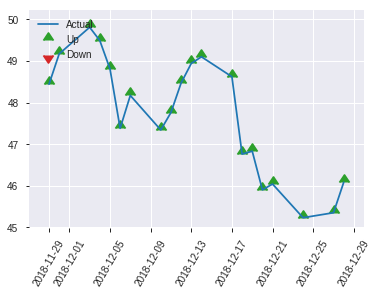


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24909523859961683
RMSE: 0.4990944185218032
LogLoss: 0.6912999772130072
Mean Per-Class Error: 0.4332694763729247
AUC: 0.5360791826309067
pr_auc: 0.6204777809382758
Gini: 0.0721583652618134
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36804041266441345: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    115  0.9914   (115.0/116.0)
1      0    135  0        (0.0/135.0)
Total  1    250  0.4582   (115.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.36804      0.701299  249
max f2                       0.36804      0.85443   249
max f0point5                 0.415003     0.595349  234
max accuracy                 0.415003     0.545817  234
max precision                0.643346     1         0
max recall                   0.36804      1         249
max specificity              0.643346     1         0
max absolute_mcc             0.557777     0.202236  30
max min_per_class_accuracy   0.493066     0.533333  124
max mean_per_class_accuracy  0.557777     0.566731  30

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 49.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.605453           1.85926   1.85926            1                0.627051  1                           0.627051            0.0222222       0.0222222                  85.9259   85.9259
    2        0.0239044                   0.59478            1.85926   1.85926            1                0.598835  1                           0.612943            0.0222222       0.0444444                  85.9259   85.9259
    3        0.0318725                   0.588294           1.85926   1.85926            1                0.590131  1                           0.60724             0.0148148       0.0592593                  85.9259   85.9259
    4        0.0438247                   0.586757           1.23951   1.69024            0.666667         0.58731   0.909091                    0.601805            0.0148148       0.0740741                  23.9506   69.0236
    5        0.0517928                   0.579551           1.85926   1.71624            1                0.581174  0.923077                    0.598631            0.0148148       0.0888889                  85.9259   71.6239
    6        0.103586                    0.565701           1.28718   1.50171            0.692308         0.572388  0.807692                    0.585509            0.0666667       0.155556                   28.7179   50.1709
    7        0.151394                    0.549006           0.92963   1.32105            0.5              0.555574  0.710526                    0.576056            0.0444444       0.2                        -7.03704  32.1053
    8        0.203187                    0.539839           0.57208   1.13014            0.307692         0.543969  0.607843                    0.567877            0.0296296       0.22963                    -42.792   13.0138
    9        0.302789                    0.527477           0.966815  1.07641            0.52             0.532766  0.578947                    0.556327            0.0962963       0.325926                   -3.31852  7.64133
    10       0.40239                     0.507915           0.966815  1.04928            0.52             0.517049  0.564356                    0.546605            0.0962963       0.422222                   -3.31852  4.92849
    11       0.501992                    0.492154           1.11556   1.06243            0.6              0.499622  0.571429                    0.537283            0.111111        0.533333                   11.5556   6.24339
    12       0.601594                    0.476823           0.818074  1.02198            0.44             0.484616  0.549669                    0.528563            0.0814815       0.614815                   -18.1926  2.19769
    13       0.701195                    0.457946           0.818074  0.993013           0.44             0.468515  0.534091                    0.520034            0.0814815       0.696296                   -18.1926  -0.698653
    14       0.800797                    0.444727           0.966815  0.989755           0.52             0.452234  0.532338                    0.511601            0.0962963       0.792593                   -3.31852  -1.02451
    15       0.900398                    0.423654           1.04119   0.995444           0.56             0.432738  0.535398                    0.502877            0.103704        0.896296                   4.11852   -0.455588
    16       1                           0.357931           1.04119   1                  0.56             0.405514  0.537849                    0.49318     

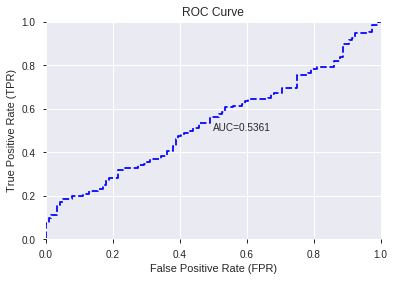

This function is available for GLM models only


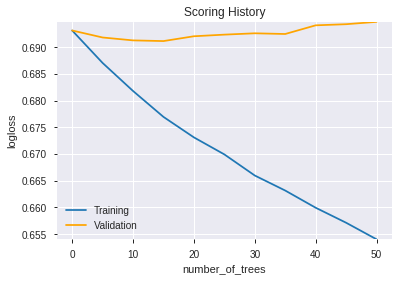

--2019-08-27 18:27:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.228.16
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.228.16|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.setRightChild(SharedTreeNode.java:220)
	at hex.genmodel.algos.tree.SharedTreeSubgraph.makeRightEdge(SharedTreeSubgraph.java:86)
	at hex.genmodel.algos.tree.SharedTreeSubgraph.makeRightChildNode(SharedTreeSubgraph.java:77)
	at h

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_182740_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_182740_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_9b73',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CORREL_12',
 'BETA_30',
 'day',
 'BOP',
 'CORREL_14',
 'COSH',
 'STOCHRSI_fastk',
 'dayofweek',
 'weekday_name',
 'HT_TRENDMODE',
 'CDLDOJI',
 'days_in_month',
 'weekday']

In [22]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [24]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [25]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [26]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [28]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [29]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [30]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [32]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [33]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [34]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [36]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [37]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [38]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [40]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [41]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [42]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [44]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [45]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [46]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [47]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [895 916 940] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_182806_model_9  0.568838  0.689023              0.490773  0.497939  0.247943
1  DeepLearning_grid_1_AutoML_20190827_182806_model_7  0.530971  0.720777              0.477842  0.513625  0.263811
2  DeepLearning_grid_1_AutoML_20190827_182806_model_8  0.500000  0.690561              0.500000  0.498706  0.248708
3  DeepLearning_grid_1_AutoML_20190827_182806_model_5  0.500000  0.690554              0.500000  0.498703  0.248704
4  DeepLearning_grid_1_AutoML_20190827_182806_model_6  0.500000  0.690441              0.500000  0.498646  0.248648
5               DeepLearning_1_AutoML_20190827_182806  0.489049  1.345252              0.491379  0.514076  0.264274
6  DeepLearning_grid_1_AutoML_20190827_182806_model_3  0.478225  0.998974              0.491379  0.592439  0.350984
7  DeepLearning_grid_1_AutoML_20190827_182806_model_4  0.477969  1.535590              0.468614  0.609435  0.371411
8  DeepLearning_grid_1_AutoML_20190827_182806_model_1  0.455460  6.040338              0.500000  0.679341  0.461504
9  DeepLearning_grid_1_AutoML_20190827_182806_model_2  0.422797  0.748255              0.500000  0.520738  0.271168

variable  relative_importance  scaled_importance  percentage
0                   aroonup_14             1.000000           1.000000    0.001193
1                   PLUS_DM_12             0.996409           0.996409    0.001189
2                   aroonup_30             0.996317           0.996317    0.001188
3                    aroonup_8             0.993417           0.993417    0.001185
4                   weekofyear             0.990704           0.990704    0.001182
...                        ...                  ...                ...         ...
1034          CDLCOUNTERATTACK             0.702000           0.702000    0.000837
1035  BBANDS_middleband_12_1_5             0.697694           0.697694    0.000832
1036                   TEMA_14             0.697518           0.697518    0.000832
1037       CDLXSIDEGAP3METHODS             0.681671           0.681671    0.000813
1038              CDLTASUKIGAP             0.674149           0.674149    0.000804

[1039 rows x 4 columns]

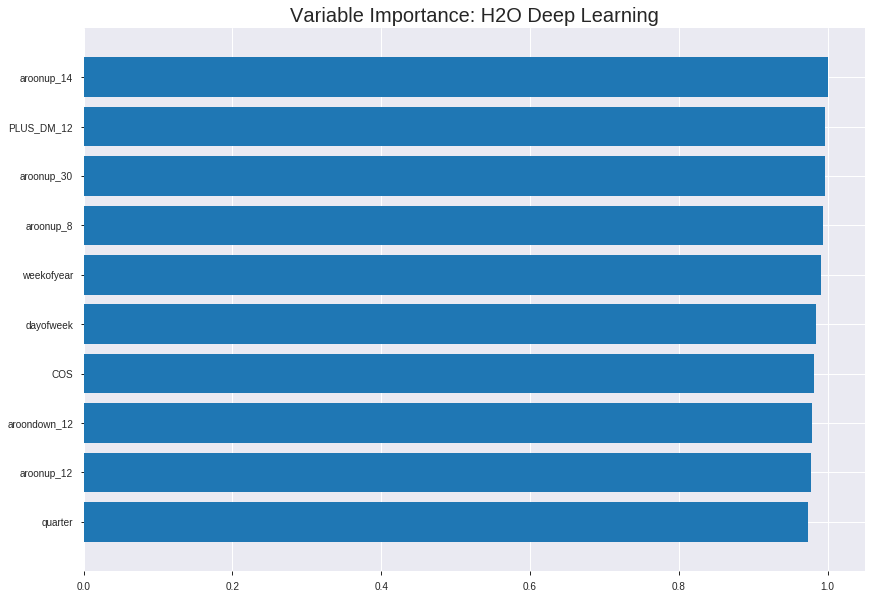

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_182806_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24989671843140282
RMSE: 0.4998967077621164
LogLoss: 0.6929468538569638
Mean Per-Class Error: 0.46979369714239483
AUC: 0.5268316358882426
pr_auc: 0.3698648967155277
Gini: 0.05366327177648511
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5310768990988963: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    833   0.9988   (833.0/834.0)
1      0    919   0        (0.0/919.0)
Total  1    1752  0.4752   (833.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.531077     0.688132   398
max f2                       0.531077     0.846536   398
max f0point5                 0.539259     0.581596   327
max accuracy                 0.544532     0.533942   235
max precision                0.552198     0.553238   46
max recall                   0.531077     1          398
max specificity              0.552891     0.720624   0
max absolute_mcc             0.552198     0.0603883  46
max min_per_class_accuracy   0.552285     0.524483   41
max mean_per_class_accuracy  0.552198     0.530206   46

Gains/Lift Table: Avg response rate: 52.42 %, avg score: 54.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.295493                    0.552891           1.05686   1.05686            0.554054         0.552891  0.554054                    0.552891            0.312296        0.312296                   5.68626    5.68626
    2        0.300057                    0.552877           0.953754  1.05529            0.5              0.552884  0.553232                    0.552891            0.00435256      0.316649                   -4.62459   5.52944
    3        0.399886                    0.552608           0.991904  1.03947            0.52             0.552741  0.544936                    0.552853            0.0990207       0.415669                   -0.809576  3.94695
    4        0.500285                    0.552279           1.08381   1.04837            0.568182         0.552439  0.549601                    0.55277             0.108814        0.524483                   8.38115    4.83682
    5        0.600114                    0.551741           0.981004  1.03716            0.514286         0.552041  0.543726                    0.552649            0.0979325       0.622416                   -1.89958   3.71622
    6        0.699943                    0.55051            0.893804  1.01672            0.468571         0.551222  0.533007                    0.552445            0.0892274       0.711643                   -10.6196   1.67158
    7        0.799772                    0.546422           1.0137    1.01634            0.531429         0.548737  0.53281                     0.551983            0.101197        0.81284                    1.37043    1.63399
    8        0.899601                    0.542186           0.991904  1.01363            0.52             0.544263  0.531389                    0.551126            0.0990207       0.911861                   -0.809576  1.36283
    9        1                           0.530417           0.877887  1                  0.460227         0.538245  0.524244                    0.549833            0.0881393       1                          -12.2113   0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24908650484811298
RMSE: 0.499085668846655
LogLoss: 0.6913187871370514
Mean Per-Class Error: 0.44202527595584706
AUC: 0.5506718924972005
pr_auc: 0.5030752542013557
Gini: 0.101343784994401
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5417328229401647: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      15   220  0.9362   (220.0/235.0)
1      6    260  0.0226   (6.0/266.0)
Total  21   480  0.4511   (226.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.541733     0.697051  380
max f2                       0.540031     0.851472  396
max f0point5                 0.541733     0.594694  380
max accuracy                 0.550359     0.550898  127
max precision                0.552891     0.666667  0
max recall                   0.540031     1         396
max specificity              0.552891     0.931915  0
max absolute_mcc             0.550359     0.118677  127
max min_per_class_accuracy   0.549299     0.526316  170
max mean_per_class_accuracy  0.550359     0.557975  127

Gains/Lift Table: Avg response rate: 53.09 %, avg score: 54.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0958084                   0.552891           1.25564   1.25564            0.666667         0.552891  0.666667                    0.552891            0.120301        0.120301                   25.5639   25.5639
    2        0.101796                    0.552783           0         1.18178            0                0.552798  0.627451                    0.552886            0               0.120301                   -100      18.1778
    3        0.151697                    0.552251           1.13008   1.16477            0.6              0.552511  0.618421                    0.552762            0.056391        0.176692                   13.0075   16.477
    4        0.201597                    0.551808           1.05474   1.13753            0.56             0.552024  0.60396                     0.55258             0.0526316       0.229323                   5.47368   13.7534
    5        0.301397                    0.551055           1.09241   1.12259            0.58             0.551428  0.596026                    0.552198            0.109023        0.338346                   9.2406    12.2591
    6        0.401198                    0.550194           1.13008   1.12445            0.6              0.550657  0.597015                    0.551815            0.112782        0.451128                   13.0075   12.4453
    7        0.500998                    0.549226           0.753383  1.05053            0.4              0.549712  0.557769                    0.551396            0.075188        0.526316                   -24.6617  5.05347
    8        0.600798                    0.54855            0.828722  1.01369            0.44             0.548872  0.538206                    0.550977            0.0827068       0.609023                   -17.1278  1.36887
    9        0.700599                    0.544937           1.13008   1.03027            0.6              0.547012  0.547009                    0.550412            0.112782        0.721805                   13.0075   3.0268
    10       0.800399                    0.543491           1.01707   1.02862            0.54             0.544121  0.546135                    0.549628            0.101504        0.823308                   1.70677   2.86221
    11       0.9002                      0.542531           0.941729  1.01899            0.5              0.543053  0.54102                     0.548899            0.093985        0.917293                   -5.82707  1.89887
    12       1                           0.539894           0.828722  1                  0.44             0.541606  0.530938                    0.548171            0.0827068       1                          -17.1278  0


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:48:32  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 18:48:34  6 min 30.972 sec   185 obs/sec       0.225328  1             395        0.677574         2.05719             -0.840755      0.497282        0.516056           0.741809         0.475756                         0.644647           1.47948               -0.668667        0.463302          0.510457             0.62782            0.46507
    2019-08-27 18:49:20  7 min 16.528 sec   243 obs/sec       6.01198   26            10539      0.499107         0.691362            0.00121904     0.523953        0.536988           0.953754         0.470051                         0.500025           0.693198              -0.00394375      0.487274          0.510423             0.941729           0.469062
    2019-08-27 18:50:05  8 min  1.907 sec   270 obs/sec       13.0108   56            22808      0.502606         0.69855             -0.0128329     0.507014        0.523855           1.11271          0.475185                         0.503495           0.70026               -0.0179265       0.542345          0.57004              1.56955            0.463074
    2019-08-27 18:50:49  8 min 45.654 sec   295 obs/sec       20.8214   89            36500      0.499412         0.691972            -1.80338e-06   0.5             0                  1                0.475756                         0.499096           0.69134               -0.000217785     0.5               0                    1                  0.469062
    2019-08-27 18:51:34  9 min 30.221 sec   313 obs/sec       29.2618   125           51296      0.499897         0.692947            -0.00194256    0.526832        0.369865           1.05686          0.475185                         0.499086           0.691319              -0.000175361     0.550672          0.503075             1.25564            0.451098
    2019-08-27 18:52:17  10 min 13.586 sec  339 obs/sec       39.2892   168           68874      0.500773         0.694721            -0.0054581     0.503825        0.00228761         1.00366          0.471763                         0.499979           0.693123              -0.00375726      0.494641          0.00797169           0.994891           0.467066
    2019-08-27 18:53:02  10 min 57.982 sec  379 obs/sec       52.6372   225           92273      0.499851         0.69285             -0.00176001    0.505909        0.620495           1.00424          0.471763                         0.499901           0.69295               -0.00344691      0.496944          0.00995575           0.997125           0.469062
    2019-08-27 18:53:06  11 min  2.180 sec  379 obs/sec       52.6372   225           92273      0.499897         0.692947            -0.00194256    0.526832        0.369865           1.05686          0.475185                         0.499086           0.691319              -0.000175361     0.550672          0.503075             1.25564            0.451098

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
aroonup_14                1.0                    1.0                  0.0011928409468850113
PLUS_DM_12                0.9964092373847961     0.9964092373847961   0.0011885577382070524
aroonup_30                0.9963170289993286     0.9963170289993286   0.0011884477482692205
aroonup_8                 0.9934172034263611     0.9934172034263611   0.0011849887175869604
weekofyear                0.9907041192054749     0.9907041192054749   0.0011817524396359397
---                       ---                    ---                  ---
CDLCOUNTERATTACK          0.7020001411437988     0.7020001411437988   0.0008373745130753807
BBANDS_middleband_12_1_5  0.6976938247680664     0.6976938247680664   0.0008322377625721656
TEMA_14                   0.6975179314613342     0.6975179314613342   0.0008320279498336124
CDLXSIDEGAP3METHODS       0.6816713809967041     0.6816713809967041   0.0008131255355725219
CDLTASUKIGAP              0.6741493940353394     0.6741493940353394   0.0008041530015230709


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5657370517928287)

('F1', 0.7015706806282723)

('auc', 0.568837803320562)

('logloss', 0.6890226558099278)

('mean_per_class_error', 0.4348339719029374)

('rmse', 0.49793861019465696)

('mse', 0.24794285952258655)

deeplearning prediction progress: |███████████████████████████████████████| 100%


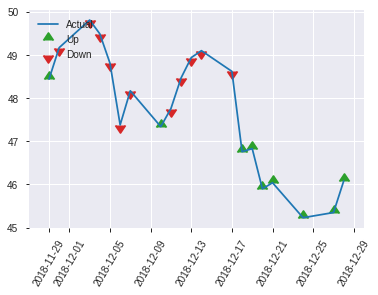


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24794285952258655
RMSE: 0.49793861019465696
LogLoss: 0.6890226558099278
Mean Per-Class Error: 0.4348339719029374
AUC: 0.568837803320562
pr_auc: 0.6037173589594481
Gini: 0.137675606641124
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5282192173044373: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    113  0.9741   (113.0/116.0)
1      1    134  0.0074   (1.0/135.0)
Total  4    247  0.4542   (114.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.528219     0.701571  246
max f2                       0.528008     0.85443   249
max f0point5                 0.529864     0.606208  223
max accuracy                 0.533936     0.565737  173
max precision                0.549283     1         0
max recall                   0.528008     1         249
max specificity              0.549283     1         0
max absolute_mcc             0.540063     0.13583   88
max min_per_class_accuracy   0.536385     0.543103  126
max mean_per_class_accuracy  0.540063     0.565166  88

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 53.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.547712           1.85926   1.85926            1                0.548576  1                           0.548576            0.0222222       0.0222222                  85.9259   85.9259
    2        0.0239044                   0.547282           1.23951   1.54938            0.666667         0.54734   0.833333                    0.547958            0.0148148       0.037037                   23.9506   54.9383
    3        0.0318725                   0.546806           0         1.16204            0                0.547093  0.625                       0.547742            0               0.037037                   -100      16.2037
    4        0.0438247                   0.546146           1.23951   1.18316            0.666667         0.546403  0.636364                    0.547376            0.0148148       0.0518519                  23.9506   18.3165
    5        0.0517928                   0.545839           1.85926   1.28718            1                0.546092  0.692308                    0.547179            0.0148148       0.0666667                  85.9259   28.7179
    6        0.103586                    0.544543           1.00114   1.14416            0.538462         0.545061  0.615385                    0.54612             0.0518519       0.118519                   0.11396   14.416
    7        0.151394                    0.543948           1.23951   1.17427            0.666667         0.544205  0.631579                    0.545515            0.0592593       0.177778                   23.9506   17.4269
    8        0.203187                    0.542582           1.28718   1.20305            0.692308         0.543456  0.647059                    0.54499             0.0666667       0.244444                   28.7179   20.305
    9        0.302789                    0.540971           0.966815  1.12534            0.52             0.541835  0.605263                    0.543952            0.0962963       0.340741                   -3.31852  12.5341
    10       0.40239                     0.538717           1.04119   1.10451            0.56             0.540037  0.594059                    0.542983            0.103704        0.444444                   4.11852   10.451
    11       0.501992                    0.536385           0.966815  1.07719            0.52             0.537663  0.579365                    0.541928            0.0962963       0.540741                   -3.31852  7.71899
    12       0.601594                    0.534846           0.818074  1.03429            0.44             0.535687  0.556291                    0.540894            0.0814815       0.622222                   -18.1926  3.42899
    13       0.701195                    0.533731           1.2643    1.06696            0.68             0.534356  0.573864                    0.539966            0.125926        0.748148                   26.4296   6.69613
    14       0.800797                    0.532183           0.669333  1.01751            0.36             0.533019  0.547264                    0.539102            0.0666667       0.814815                   -33.0667  1.75051
    15       0.900398                    0.529799           1.11556   1.02835            0.6              0.531081  0.553097                    0.538214            0.111111        0.925926                   11.5556   2.83514
    16       1                           0.527796           0.743704  1                  0.4              0.528746  0.537849                    0.537271            

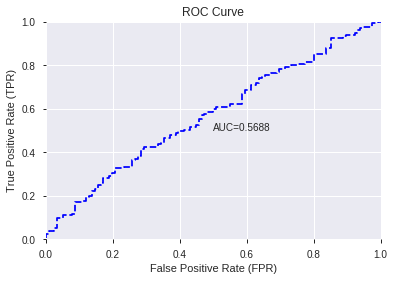

This function is available for GLM models only


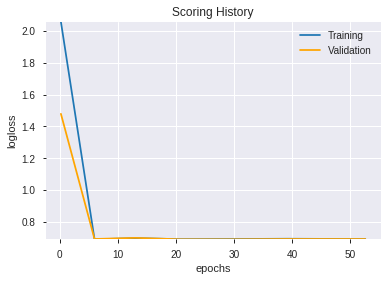

--2019-08-27 18:53:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.164.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.164.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_182806_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_182806_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_9b73',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['aroonup_14',
 'PLUS_DM_12',
 'aroonup_30',
 'aroonup_8',
 'weekofyear',
 'dayofweek',
 'COS',
 'aroondown_12',
 'aroonup_12',
 'quarter',
 'weekday',
 'STOCHRSI_fastd',
 'BOP',
 'DIV',
 'PLUS_DM_24',
 'STOCHRSI_fastk',
 'SIN',
 'AROONOSC_30',
 'AROONOSC_12',
 'SAREXT',
 'dayofyear',
 'CORREL_12',
 'MOM_8',
 'day',
 'PLUS_DM_14',
 'PLUS_DM_20',
 'AROONOSC_8',
 'BETA_8',
 'MACDEXT_hist',
 'weekday_name',
 'STOCHF_fastk',
 'CCI_14',
 'MACDFIX_hist_8',
 'RSI_20',
 'HT_TRENDMODE',
 'SUB',
 'STOCHF_fastd',
 'ATR_24',
 'CORREL_8',
 'MACD_hist',
 'aroondown_20',
 'PLUS_DM_30',
 'BETA_30',
 'MACDFIX_signal_24',
 'STOCH_slowk',
 'MINUS_DM_30',
 'DX_8',
 'days_in_month',
 'LINEARREG_ANGLE_30',
 'DX_12',
 'MFI_30',
 'aroonup_20',
 'WILLR_14',
 'MACDFIX_hist_20',
 'MACDFIX_signal_20',
 'ADX_8',
 'MACDFIX_signal_14',
 'CCI_8',
 'ATR_14',
 'MINUS_DM_24',
 'ADX_12',
 'CMO_20',
 'ATR_12',
 'MACDFIX_14',
 'STDDEV_8',
 'AROONOSC_24',
 'MOM_12',
 'VAR_8',
 'DX_30',
 'TRIX_12',
 'NATR_12',
 'aroondown_30

In [48]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_185323_model_1  0.474393  0.695525              0.490773  0.501187  0.251189

variable  relative_importance  scaled_importance  percentage
0                 CDLSHORTLINE             0.009186           1.000000    0.012389
1                          day             0.008301           0.903618    0.011195
2             is_quarter_start             0.006044           0.657899    0.008151
3                      weekday             0.005922           0.644609    0.007986
4                    dayofweek             0.005911           0.643505    0.007973
...                        ...                  ...                ...         ...
1034   BBANDS_lowerband_20_0_2             0.000004           0.000384    0.000005
1035  BBANDS_middleband_20_3_2             0.000003           0.000379    0.000005
1036                   MA_20_3             0.000003           0.000338    0.000004
1037  BBANDS_middleband_12_6_3             0.000001           0.000154    0.000002
1038                 MAVP_14_5             0.000001           0.000135    0.000002

[1039 rows x 4 columns]

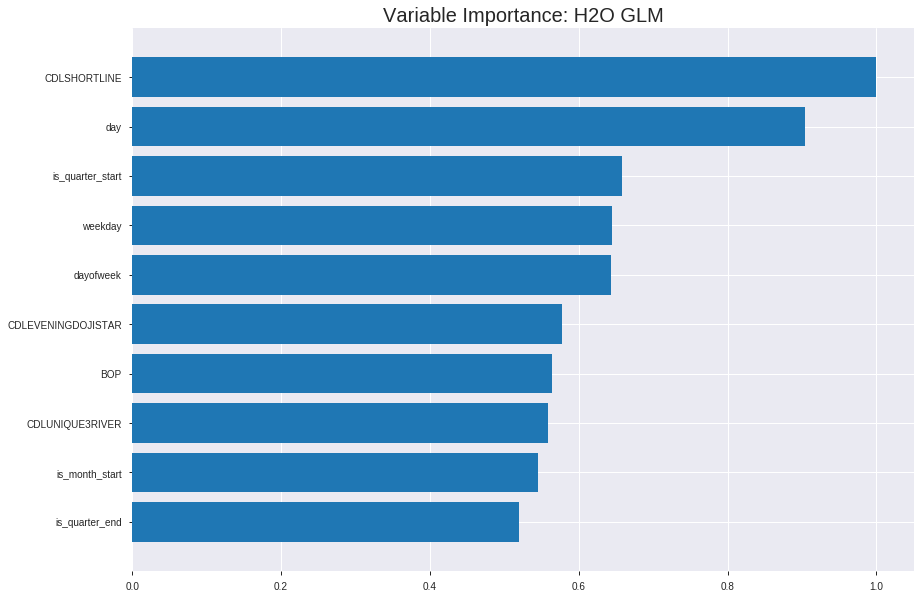

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_185323_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24632305993290093
RMSE: 0.496309439697555
LogLoss: 0.6857629635768286
Null degrees of freedom: 1752
Residual degrees of freedom: 713
Null deviance: 2426.050892509706
Residual deviance: 2404.2849503003617
AIC: 4484.284950300362
AUC: 0.578069426939406
pr_auc: 0.5845235031870788
Gini: 0.156138853878812
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4611033186915171: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      20   814   0.976    (814.0/834.0)
1      5    914   0.0054   (5.0/919.0)
Total  25   1728  0.4672   (819.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.461103     0.690593  381
max f2                       0.430195     0.846849  396
max f0point5                 0.506293     0.598063  269
max accuracy                 0.518302     0.573303  220
max precision                0.615616     0.75      3
max recall                   0.430195     1         396
max specificity              0.623614     0.998801  0
max absolute_mcc             0.518302     0.14042   220
max min_per_class_accuracy   0.52347      0.566921  201
max mean_per_class_accuracy  0.518302     0.569192  220

Gains/Lift Table: Avg response rate: 52.42 %, avg score: 52.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.5955             1.37764   1.37764            0.722222         0.607314  0.722222                    0.607314            0.0141458       0.0141458                  37.7645   37.7645
    2        0.0205362                   0.584886           1.27167   1.32466            0.666667         0.591148  0.694444                    0.599231            0.0130577       0.0272035                  27.1672   32.4658
    3        0.0302339                   0.5796             1.34648   1.33166            0.705882         0.582052  0.698113                    0.593721            0.0130577       0.0402612                  34.6476   33.1657
    4        0.040502                    0.576283           1.05973   1.26272            0.555556         0.577779  0.661972                    0.589679            0.0108814       0.0511425                  5.97268   26.2717
    5        0.0501997                   0.57234            1.45868   1.30057            0.764706         0.574488  0.681818                    0.586744            0.0141458       0.0652884                  45.8683   30.0574
    6        0.100399                    0.559365           0.953754  1.12716            0.5              0.564534  0.590909                    0.575639            0.0478781       0.113166                   -4.62459  12.7164
    7        0.150029                    0.552513           1.22782   1.16046            0.643678         0.555508  0.608365                    0.56898             0.0609358       0.174102                   22.7821   16.0461
    8        0.200228                    0.546348           1.01878   1.12494            0.534091         0.549073  0.589744                    0.563989            0.0511425       0.225245                   1.87828   12.4941
    9        0.300057                    0.537125           1.0246    1.09156            0.537143         0.542091  0.572243                    0.556704            0.102285        0.32753                    2.46044   9.15589
    10       0.399886                    0.530003           1.1227    1.09933            0.588571         0.533647  0.57632                     0.550948            0.112078        0.439608                   12.2705   9.93342
    11       0.500285                    0.52351            1.23555   1.12667            0.647727         0.526842  0.59065                     0.54611             0.124048        0.563656                   23.5545   12.667
    12       0.600114                    0.517813           0.970104  1.10062            0.508571         0.520412  0.576996                    0.541835            0.0968444       0.660501                   -2.98958  10.0625
    13       0.699943                    0.510641           0.926504  1.07579            0.485714         0.514236  0.563977                    0.537899            0.0924918       0.752992                   -7.3496   7.57911
    14       0.799772                    0.502145           0.926504  1.05716            0.485714         0.506345  0.554208                    0.53396             0.0924918       0.845484                   -7.3496   5.71568
    15       0.899601                    0.489229           0.784803  1.02693            0.411429         0.496096  0.538364                    0.529758            0.078346        0.92383                    -21.5197  2.69337
    16       1                           0.400878           0.758668  1                  0.397727         0.474835  0.524244                    0.524244          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24961685283142002
RMSE: 0.49961670591706603
LogLoss: 0.6923850151087547
Null degrees of freedom: 500
Residual degrees of freedom: -539
Null deviance: 692.7041364892402
Residual deviance: 693.7697851389722
AIC: 2773.769785138972
AUC: 0.5238681810910255
pr_auc: 0.537099334830445
Gini: 0.04773636218205102
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46034972067559005: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    232  0.9872   (232.0/235.0)
1      0    266  0        (0.0/266.0)
Total  3    498  0.4631   (232.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.46035      0.696335  396
max f2                       0.46035      0.851472  396
max f0point5                 0.46035      0.589017  396
max accuracy                 0.519589     0.55489   143
max precision                0.579849     1         0
max recall                   0.46035      1         396
max specificity              0.579849     1         0
max absolute_mcc             0.519589     0.134952  143
max min_per_class_accuracy   0.513861     0.541353  196
max mean_per_class_accuracy  0.519589     0.564462  143

Gains/Lift Table: Avg response rate: 53.09 %, avg score: 51.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.562039           0.62782   0.62782            0.333333         0.570112  0.333333                    0.570112            0.0075188       0.0075188                  -37.218   -37.218
    2        0.0219561                   0.55986            1.13008   0.856118           0.6              0.560523  0.454545                    0.565753            0.0112782       0.018797                   13.0075   -14.3882
    3        0.0319361                   0.555247           1.13008   0.941729           0.6              0.556939  0.5                         0.562999            0.0112782       0.0300752                  13.0075   -5.82707
    4        0.0419162                   0.554807           0.376692  0.807197           0.2              0.554976  0.428571                    0.561088            0.0037594       0.0338346                  -62.3308  -19.2803
    5        0.0518962                   0.551546           0.753383  0.796848           0.4              0.553116  0.423077                    0.559555            0.0075188       0.0413534                  -24.6617  -20.3152
    6        0.101796                    0.537254           0.90406   0.849403           0.48             0.54334   0.45098                     0.551607            0.0451128       0.0864662                  -9.59398  -15.0597
    7        0.151697                    0.530325           1.20541   0.966512           0.64             0.533164  0.513158                    0.54554             0.0601504       0.146617                   20.5414   -3.34883
    8        0.201597                    0.526915           1.28075   1.04429            0.68             0.528584  0.554455                    0.541343            0.0639098       0.210526                   28.0752   4.42939
    9        0.301397                    0.520988           1.20541   1.09764            0.64             0.523461  0.582781                    0.535422            0.120301        0.330827                   20.5414   9.76448
    10       0.401198                    0.517605           1.16774   1.11508            0.62             0.519279  0.59204                     0.531406            0.116541        0.447368                   16.7744   11.5082
    11       0.500998                    0.513861           0.941729  1.08055            0.5              0.515841  0.573705                    0.528306            0.093985        0.541353                   -5.82707  8.055
    12       0.600798                    0.509004           0.715714  1.01995            0.38             0.511259  0.541528                    0.525474            0.0714286       0.612782                   -28.4286  1.9946
    13       0.700599                    0.504132           0.979398  1.01417            0.52             0.506654  0.538462                    0.522793            0.0977444       0.710526                   -2.06015  1.417
    14       0.800399                    0.497401           0.828722  0.991047           0.44             0.500784  0.526185                    0.520049            0.0827068       0.793233                   -17.1278  -0.895318
    15       0.9002                      0.485963           0.979398  0.989755           0.52             0.493056  0.525499                    0.517056            0.0977444       0.890977                   -2.06015  -1.02446
    16       1                           0.439304           1.09241   1                  0.58             0.474467  0.530938                    0.512806     


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 18:53:26  0.000 sec   2            3.2       1040          1.37153           1.38477
    2019-08-27 18:53:29  2.045 sec   4            2.4       1040          1.36894           1.38498
    2019-08-27 18:53:31  4.150 sec   6            1.7       1040          1.36586           1.385
    2019-08-27 18:53:33  6.252 sec   8            1.3       1040          1.36225           1.38495
    2019-08-27 18:53:35  8.353 sec   10           0.91      1040          1.35809           1.38487
    2019-08-27 18:53:37  10.480 sec  12           0.66      1040          1.35342           1.38485
    2019-08-27 18:53:39  12.596 sec  14           0.48      1040          1.34831           1.385
    2019-08-27 18:53:41  14.783 sec  16           0.35      1040          1.34286           1.38547
    2019-08-27 18:53:43  16.915 sec  18           0.26      1040          1.33722           1.38639
    2019-08-27 18:53:45  19.011 sec  20           0.19      1040          1.3315            1.38788
    2019-08-27 18:53:48  21.127 sec  22           0.14      1040          1.32581           1.39007

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.545816733067729)

('F1', 0.7015706806282723)

('auc', 0.4743933588761175)

('logloss', 0.6955251632336527)

('mean_per_class_error', 0.47713920817369093)

('rmse', 0.5011872684344625)

('mse', 0.2511886780407979)

glm prediction progress: |████████████████████████████████████████████████| 100%


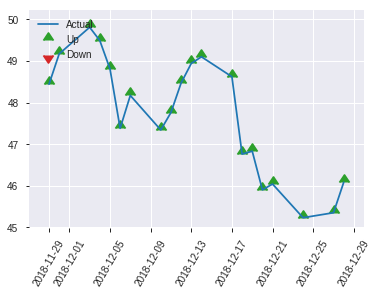


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2511886780407979
RMSE: 0.5011872684344625
LogLoss: 0.6955251632336527
Null degrees of freedom: 250
Residual degrees of freedom: -789
Null deviance: 346.70670784719556
Residual deviance: 349.15363194329365
AIC: 2429.1536319432935
AUC: 0.4743933588761175
pr_auc: 0.5249019398813967
Gini: -0.051213282247765
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4529132705415852: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    113  0.9741   (113.0/116.0)
1      1    134  0.0074   (1.0/135.0)
Total  4    247  0.4542   (114.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.452913     0.701571  246
max f2                       0.449455     0.85443   249
max f0point5                 0.452913     0.596616  246
max accuracy                 0.452913     0.545817  246
max precision                0.57052      1         0
max recall                   0.449455     1         249
max specificity              0.57052      1         0
max absolute_mcc             0.481316     0.112117  206
max min_per_class_accuracy   0.500643     0.508621  125
max mean_per_class_accuracy  0.497678     0.522861  135

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 50.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.547703           1.23951   1.23951            0.666667         0.560154  0.666667                    0.560154            0.0148148       0.0148148                  23.9506   23.9506
    2        0.0239044                   0.545744           1.23951   1.23951            0.666667         0.546095  0.666667                    0.553125            0.0148148       0.0296296                  23.9506   23.9506
    3        0.0318725                   0.543866           0.92963   1.16204            0.5              0.544394  0.625                       0.550942            0.00740741      0.037037                   -7.03704  16.2037
    4        0.0438247                   0.542923           1.23951   1.18316            0.666667         0.543264  0.636364                    0.548848            0.0148148       0.0518519                  23.9506   18.3165
    5        0.0517928                   0.541119           0.92963   1.14416            0.5              0.542156  0.615385                    0.547818            0.00740741      0.0592593                  -7.03704  14.416
    6        0.103586                    0.533272           0.42906   0.78661            0.230769         0.536798  0.423077                    0.542308            0.0222222       0.0814815                  -57.094   -21.339
    7        0.151394                    0.525927           1.39444   0.978558           0.75             0.529204  0.526316                    0.53817             0.0666667       0.148148                   39.4444   -2.14425
    8        0.203187                    0.521003           0.85812   0.947858           0.461538         0.523217  0.509804                    0.534359            0.0444444       0.192593                   -14.188   -5.21423
    9        0.302789                    0.514611           0.966815  0.954094           0.52             0.517724  0.513158                    0.528887            0.0962963       0.288889                   -3.31852  -4.59064
    10       0.40239                     0.507837           0.966815  0.957242           0.52             0.51119   0.514851                    0.524506            0.0962963       0.385185                   -3.31852  -4.27576
    11       0.501992                    0.500643           1.2643    1.01817            0.68             0.503953  0.547619                    0.520428            0.125926        0.511111                   26.4296   1.81658
    12       0.601594                    0.494302           0.892444  0.997351           0.48             0.497024  0.536424                    0.516553            0.0888889       0.6                        -10.7556  -0.264901
    13       0.701195                    0.489813           0.669333  0.950758           0.36             0.49189   0.511364                    0.51305             0.0666667       0.666667                   -33.0667  -4.92424
    14       0.800797                    0.482338           1.04119   0.962005           0.56             0.486251  0.517413                    0.509717            0.103704        0.77037                    4.11852   -3.79952
    15       0.900398                    0.472226           1.2643    0.995444           0.68             0.4786    0.535398                    0.506275            0.125926        0.896296                   26.4296   -0.455588
    16       1                           0.439207           1.04119   1                  0.56             0.461711  0.537849                    0.501836

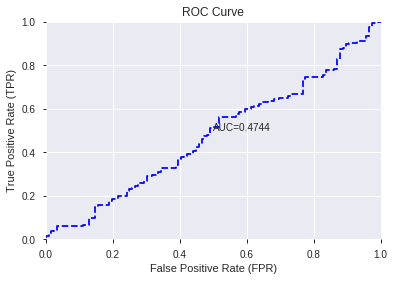

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


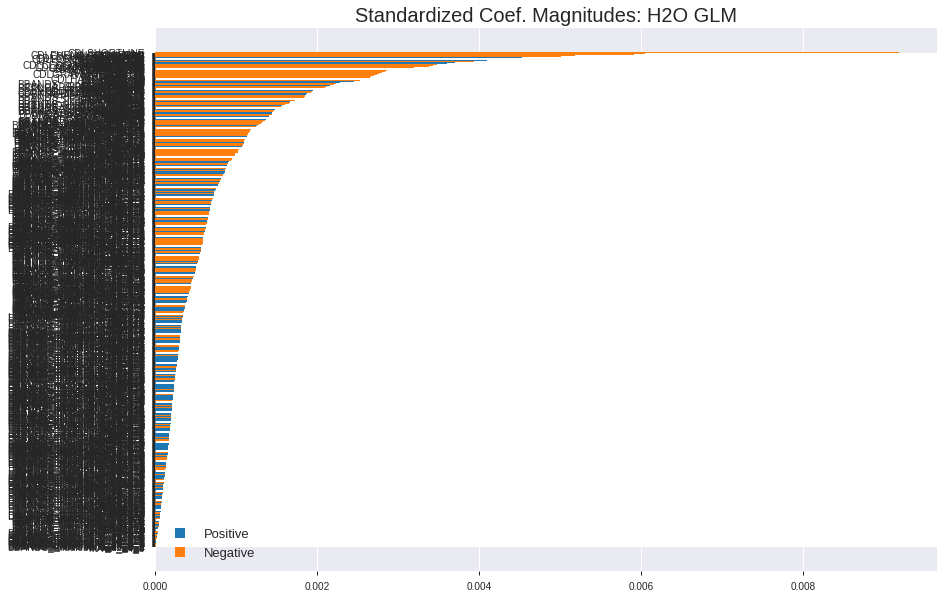

'log_likelihood'
--2019-08-27 18:54:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.171.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.171.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_185323_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_185323_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_9b73',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLSHORTLINE',
 'day',
 'is_quarter_start',
 'weekday',
 'dayofweek',
 'CDLEVENINGDOJISTAR',
 'BOP',
 'CDLUNIQUE3RIVER',
 'is_month_start',
 'is_quarter_end',
 'CDLCOUNTERATTACK',
 'CORREL_30',
 'CDLINNECK',
 'CDLLONGLEGGEDDOJI',
 'CDLTASUKIGAP',
 'TAN',
 'CDLBELTHOLD',
 'CDLDOJI',
 'CORREL_12',
 'CDL3OUTSIDE',
 'CDLHAMMER',
 'CORREL_24',
 'aroonup_14',
 'weekday_name',
 'CDLCLOSINGMARUBOZU',
 'STDDEV_8',
 'aroonup_30',
 'DX_8',
 'CDLHANGINGMAN',
 'CDL3INSIDE',
 'CDLABANDONEDBABY',
 'CDLMATCHINGLOW',
 'aroonup_24',
 'is_month_end',
 'CDLEVENINGSTAR',
 'CDL2CROWS',
 'CDLMARUBOZU',
 'DX_12',
 'MINUS_DI_30',
 'VAR_8',
 'AROONOSC_30',
 'aroonup_12',
 'DX_14',
 'CDLGRAVESTONEDOJI',
 'MINUS_DI_24',
 'MOM_12',
 'MFI_14',
 'MFI_12',
 'OBV',
 'ROCR100_30',
 'ROCR_30',
 'ROCP_30',
 'ROC_30',
 'MOM_30',
 'CDLHARAMICROSS',
 'MINUS_DI_20',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'BETA_30',
 'CORREL_20',
 'PLUS_DM_30',
 'ADX_12',
 'BBANDS_upperband_8_7_5',
 'MOM_14',
 'ADX_14',
 'PLUS_D

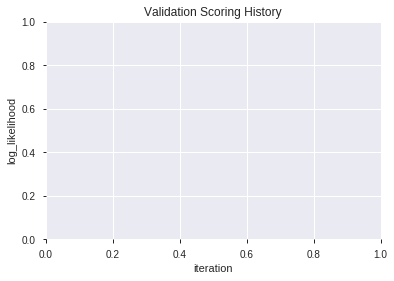

In [49]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_185417_model_3  0.537229  0.702918              0.487069  0.504572  0.254593
1  XGBoost_grid_1_AutoML_20190827_185417_model_5  0.512963  0.746979              0.495690  0.522703  0.273218
2  XGBoost_grid_1_AutoML_20190827_185417_model_7  0.496616  0.722644              0.491379  0.513460  0.263641
3  XGBoost_grid_1_AutoML_20190827_185417_model_4  0.485377  0.702001              0.485856  0.504343  0.254362
4               XGBoost_1_AutoML_20190827_185417  0.484802  0.737538              0.487069  0.520358  0.270772
5               XGBoost_2_AutoML_20190827_185417  0.478416  0.722831              0.477842  0.513729  0.263918
6  XGBoost_grid_1_AutoML_20190827_185417_model_6  0.478416  0.731701              0.490773  0.517799  0.268116
7               XGBoost_3_AutoML_20190827_185417  0.476564  0.728602              0.490166  0.516304  0.266570
8  XGBoost_grid_1_AutoML_20190827_185417_model_1  0.463538  0.759035              0.490773  0.529395  0.280259
9  XGBoost_grid_1_AutoML_20190827_185417_model_2  0.448978  0.718177              0.500000  0.512005  0.262149

variable  relative_importance  scaled_importance  percentage
0                        day           122.819008           1.000000    0.021567
1                  CORREL_14            96.471237           0.785475    0.016940
2                     CCI_24            87.282204           0.710657    0.015327
3          HT_PHASOR_inphase            81.607971           0.664457    0.014330
4                  CORREL_24            72.757599           0.592397    0.012776
..                       ...                  ...                ...         ...
324              MINUS_DM_20             1.222715           0.009955    0.000215
325  BBANDS_lowerband_12_0_2             1.023185           0.008331    0.000180
326                   CMO_14             0.768317           0.006256    0.000135
327              aroondown_8             0.763712           0.006218    0.000134
328   BBANDS_upperband_8_6_2             0.304053           0.002476    0.000053

[329 rows x 4 columns]

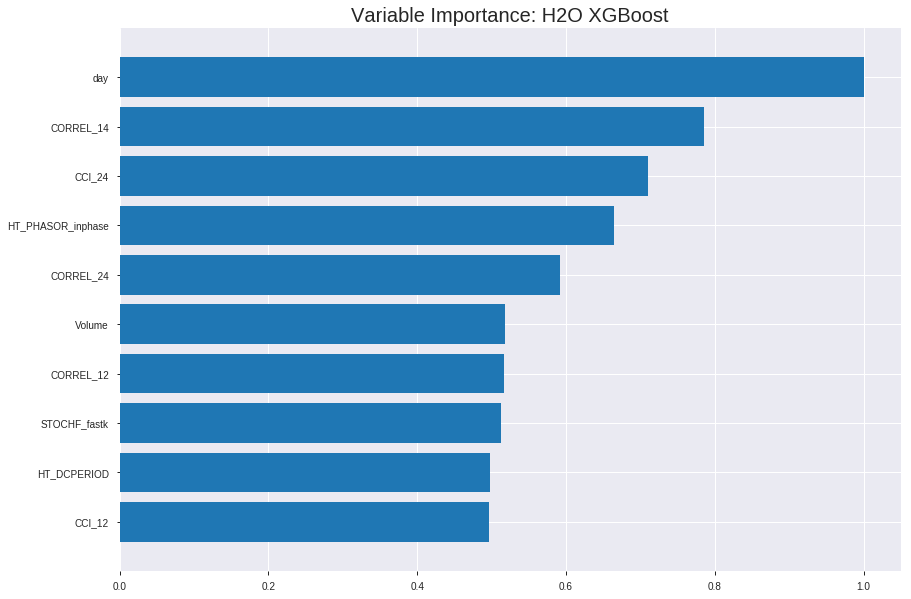

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_185417_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17846723852926513
RMSE: 0.4224538300563331
LogLoss: 0.5456074738227253
Mean Per-Class Error: 0.1351204129188488
AUC: 0.9395482525840047
pr_auc: 0.9417034808583666
Gini: 0.8790965051680093
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4946851134300232: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      657  177   0.2122   (177.0/834.0)
1      63   856   0.0686   (63.0/919.0)
Total  720  1033  0.1369   (240.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.494685     0.877049  223
max f2                       0.476832     0.919983  240
max f0point5                 0.546453     0.888476  174
max accuracy                 0.511925     0.865944  207
max precision                0.795759     1         0
max recall                   0.349793     1         344
max specificity              0.795759     1         0
max absolute_mcc             0.511925     0.731203  207
max min_per_class_accuracy   0.519398     0.860718  199
max mean_per_class_accuracy  0.511925     0.86488   207

Gains/Lift Table: Avg response rate: 52.42 %, avg score: 52.29 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.745711           1.90751    1.90751            1                0.769139  1                           0.769139            0.0195865       0.0195865                  90.7508   90.7508
    2        0.0205362                   0.721383           1.90751    1.90751            1                0.732388  1                           0.750764            0.0195865       0.039173                   90.7508   90.7508
    3        0.0302339                   0.713473           1.90751    1.90751            1                0.716902  1                           0.739902            0.0184984       0.0576714                  90.7508   90.7508
    4        0.040502                    0.707283           1.90751    1.90751            1                0.709954  1                           0.73231             0.0195865       0.0772579                  90.7508   90.7508
    5        0.0501997                   0.701284           1.90751    1.90751            1                0.704109  1                           0.726862            0.0184984       0.0957563                  90.7508   90.7508
    6        0.100399                    0.672184           1.88583    1.89667            0.988636         0.684994  0.994318                    0.705928            0.0946681       0.190424                   88.5832   89.667
    7        0.150029                    0.647679           1.84173    1.8785             0.965517         0.659173  0.984791                    0.690462            0.0914037       0.281828                   84.1732   87.8497
    8        0.200228                    0.629634           1.8208     1.86403            0.954545         0.636932  0.977208                    0.677041            0.0914037       0.373232                   82.0803   86.4032
    9        0.300057                    0.592384           1.76581    1.83135            0.925714         0.611107  0.960076                    0.655105            0.176279        0.54951                    76.5808   83.1353
    10       0.399886                    0.563477           1.61321    1.77689            0.845714         0.578154  0.931526                    0.635895            0.161045        0.710555                   61.3207   77.6894
    11       0.500285                    0.525988           1.33309    1.68783            0.698864         0.543441  0.884835                    0.617341            0.133841        0.844396                   33.3088   68.7829
    12       0.600114                    0.49131            0.926504   1.56118            0.485714         0.507822  0.818441                    0.599122            0.0924918       0.936888                   -7.3496   56.1183
    13       0.699943                    0.453415           0.381502   1.39293            0.2              0.472543  0.730236                    0.581069            0.0380849       0.974973                   -61.8498  39.2932
    14       0.799772                    0.419858           0.196201   1.24355            0.102857         0.437479  0.651926                    0.563146            0.0195865       0.994559                   -80.3799  24.3554
    15       0.899601                    0.374909           0.0436002  1.11039            0.0228571        0.397582  0.582118                    0.544773            0.00435256      0.998912                   -95.64    11.0395
    16       1                           0.140015           0.0108381  1                  0.00568182       0.326602  0.524244                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2655784298967568
RMSE: 0.5153430215853871
LogLoss: 0.7254608623327643
Mean Per-Class Error: 0.4927291633338666
AUC: 0.4348904175331947
pr_auc: 0.4894330830747079
Gini: -0.13021916493361063
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20768743753433228: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    235  1        (235.0/235.0)
1      0    266  0        (0.0/266.0)
Total  0    501  0.4691   (235.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.207687     0.693611  399
max f2                       0.207687     0.84984   399
max f0point5                 0.261296     0.586667  394
max accuracy                 0.261296     0.532934  394
max precision                0.713228     1         0
max recall                   0.207687     1         399
max specificity              0.713228     1         0
max absolute_mcc             0.529448     0.128024  107
max min_per_class_accuracy   0.483335     0.443609  196
max mean_per_class_accuracy  0.659818     0.507271  5

Gains/Lift Table: Avg response rate: 53.09 %, avg score: 47.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.659818           1.56955   1.56955            0.833333         0.683365  0.833333                    0.683365            0.018797        0.018797                   56.9549   56.9549
    2        0.0219561                   0.623119           0.753383  1.19856            0.4              0.630234  0.636364                    0.659215            0.0075188       0.0263158                  -24.6617  19.8565
    3        0.0319361                   0.615836           0         0.824013           0                0.62051   0.4375                      0.64712             0               0.0263158                  -100      -17.5987
    4        0.0419162                   0.60527            1.13008   0.896885           0.6              0.610067  0.47619                     0.638297            0.0112782       0.037594                   13.0075   -10.3115
    5        0.0518962                   0.596846           0         0.724407           0                0.600717  0.384615                    0.63107             0               0.037594                   -100      -27.5593
    6        0.101796                    0.565844           1.13008   0.923264           0.6              0.578005  0.490196                    0.605058            0.056391        0.093985                   13.0075   -7.6736
    7        0.151697                    0.555714           0.602707  0.817818           0.32             0.560459  0.434211                    0.590387            0.0300752       0.12406                    -39.7293  -18.2182
    8        0.201597                    0.544058           0.979398  0.857813           0.52             0.549353  0.455446                    0.58023             0.0488722       0.172932                   -2.06015  -14.2187
    9        0.301397                    0.519332           0.715714  0.81076            0.38             0.530864  0.430464                    0.563884            0.0714286       0.244361                   -28.4286  -18.924
    10       0.401198                    0.499922           1.09241   0.880821           0.58             0.508186  0.467662                    0.550029            0.109023        0.353383                   9.2406    -11.9179
    11       0.500998                    0.481854           0.941729  0.892954           0.5              0.490766  0.474104                    0.538224            0.093985        0.447368                   -5.82707  -10.7046
    12       0.600798                    0.465767           1.16774   0.938601           0.62             0.473201  0.498339                    0.527423            0.116541        0.56391                    16.7744   -6.13993
    13       0.700599                    0.446555           1.13008   0.965876           0.6              0.455945  0.512821                    0.51724             0.112782        0.676692                   13.0075   -3.41238
    14       0.800399                    0.419815           1.01707   0.972259           0.54             0.433096  0.516209                    0.506749            0.101504        0.778195                   1.70677   -2.77408
    15       0.9002                      0.384548           1.05474   0.981403           0.56             0.404553  0.521064                    0.495419            0.105263        0.883459                   5.47368   -1.85969
    16       1                           0.207687           1.16774   1                  0.62             0.330253  0.530938                    0.4789


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:54:41  7.177 sec   0                  0.5              0.693147            0.5             0                  1                0.475756                         0.5                0.693147              0.5               0                    1                  0.469062
    2019-08-27 18:54:43  8.385 sec   5                  0.491723         0.676685            0.712995        0.732494           1.80154          0.386766                         0.50128            0.69572               0.489682          0.51897              0.706297           0.467066
    2019-08-27 18:54:43  8.736 sec   10                 0.483274         0.660072            0.784173        0.794354           1.80154          0.313177                         0.503114           0.699437              0.456767          0.505947             1.25564            0.46507
    2019-08-27 18:54:43  9.122 sec   15                 0.47452          0.643021            0.829094        0.83767            1.90751          0.261837                         0.506239           0.705894              0.438474          0.481693             0.62782            0.467066
    2019-08-27 18:54:44  9.482 sec   20                 0.465864         0.626325            0.851454        0.865964           1.90751          0.229321                         0.508073           0.709702              0.435898          0.493649             1.56955            0.467066
    2019-08-27 18:54:44  9.854 sec   25                 0.459403         0.613987            0.868606        0.880152           1.90751          0.224187                         0.508926           0.711537              0.442993          0.499678             1.56955            0.467066
    2019-08-27 18:54:45  10.209 sec  30                 0.452642         0.60116             0.883479        0.892398           1.90751          0.204221                         0.510422           0.714771              0.442209          0.496262             1.56955            0.469062
    2019-08-27 18:54:45  10.581 sec  35                 0.446054         0.588943            0.907275        0.914167           1.90751          0.179692                         0.511092           0.716237              0.448624          0.495417             1.56955            0.469062
    2019-08-27 18:54:45  10.979 sec  40                 0.438115         0.574217            0.92252         0.927677           1.90751          0.150599                         0.510653           0.715479              0.459327          0.509375             1.25564            0.469062
    2019-08-27 18:54:46  11.367 sec  45                 0.43041          0.56007             0.931459        0.935424           1.90751          0.146606                         0.514271           0.723091              0.43601           0.490257             1.56955            0.469062
    2019-08-27 18:54:46  11.744 sec  50                 0.422454         0.545607            0.939548        0.941703           1.90751          0.136908                         0.515343           0.725461              0.43489           0.489433             1.56955            0.469062

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
day                      122.81900787353516     1.0                    0.021566977628013163
CORREL_14                96.47123718261719      0.7854748125139729     0.01694031770885669
CCI_24                   87.2822036743164       0.7106571302398856     0.01532672642907165
HT_PHASOR_inphase        81.60797119140625      0.6644571764936965     0.014330333060212346
CORREL_24                72.75759887695312      0.5923968947206487     0.012776210575344699
---                      ---                    ---                    ---
MINUS_DM_20              1.2227153778076172     0.009955424644584562   0.00021470842058712614
BBANDS_lowerband_12_0_2  1.0231847763061523     0.008330834078709624   0.00017967091219822014
CMO_14                   0.7683167457580566     0.00625568272420162    0.0001349161693608048
aroondown_8              0.7637119293212891     0.006218190022408188   0.00013410756510001207
BBANDS_upperband_8_6_2   0.30405330657958984    0.0024756209307004733  5.339166122785823e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5537848605577689)

('F1', 0.7049608355091384)

('auc', 0.5372286079182631)

('logloss', 0.7029175458920663)

('mean_per_class_error', 0.44862707535121327)

('rmse', 0.5045716911514762)

('mse', 0.25459259151146063)

xgboost prediction progress: |████████████████████████████████████████████| 100%


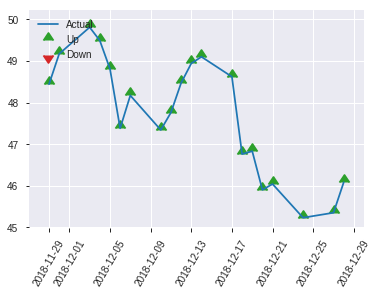


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25459259151146063
RMSE: 0.5045716911514762
LogLoss: 0.7029175458920663
Mean Per-Class Error: 0.44862707535121327
AUC: 0.5372286079182631
pr_auc: 0.5763233583322397
Gini: 0.0744572158365262
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23748557269573212: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    113  0.9741   (113.0/116.0)
1      0    135  0        (0.0/135.0)
Total  3    248  0.4502   (113.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.237486     0.704961  247
max f2                       0.237486     0.856599  247
max f0point5                 0.282154     0.600723  242
max accuracy                 0.287962     0.553785  240
max precision                0.587381     0.75      11
max recall                   0.237486     1         247
max specificity              0.684668     0.991379  0
max absolute_mcc             0.547332     0.137234  41
max min_per_class_accuracy   0.478853     0.511111  124
max mean_per_class_accuracy  0.547332     0.551373  41

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 46.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.617348           0.619753  0.619753           0.333333         0.650914  0.333333                    0.650914            0.00740741      0.00740741                 -38.0247  -38.0247
    2        0.0239044                   0.609551           1.85926   1.23951            1                0.609992  0.666667                    0.630453            0.0222222       0.0296296                  85.9259   23.9506
    3        0.0318725                   0.597822           0.92963   1.16204            0.5              0.605479  0.625                       0.62421             0.00740741      0.037037                   -7.03704  16.2037
    4        0.0438247                   0.590173           1.85926   1.35219            1                0.591108  0.727273                    0.615182            0.0222222       0.0592593                  85.9259   35.2189
    5        0.0517928                   0.58468            0.92963   1.28718            0.5              0.586414  0.692308                    0.610756            0.00740741      0.0666667                  -7.03704  28.7179
    6        0.103586                    0.566783           1.00114   1.14416            0.538462         0.575413  0.615385                    0.593085            0.0518519       0.118519                   0.11396   14.416
    7        0.151394                    0.550366           1.39444   1.2232             0.75             0.557216  0.657895                    0.581758            0.0666667       0.185185                   39.4444   22.3197
    8        0.203187                    0.54078            1.00114   1.16659            0.538462         0.545217  0.627451                    0.572443            0.0518519       0.237037                   0.11396   16.6594
    9        0.302789                    0.518372           1.11556   1.14981            0.6              0.530899  0.618421                    0.558777            0.111111        0.348148                   11.5556   14.9805
    10       0.40239                     0.500703           0.892444  1.0861             0.48             0.509025  0.584158                    0.546462            0.0888889       0.437037                   -10.7556  8.61019
    11       0.501992                    0.477362           0.743704  1.01817            0.4              0.486568  0.547619                    0.534579            0.0740741       0.511111                   -25.6296  1.81658
    12       0.601594                    0.45517            0.892444  0.997351           0.48             0.465546  0.536424                    0.523149            0.0888889       0.6                        -10.7556  -0.264901
    13       0.701195                    0.437858           0.966815  0.993013           0.52             0.446465  0.534091                    0.512257            0.0962963       0.696296                   -3.31852  -0.698653
    14       0.800797                    0.404678           1.11556   1.00826            0.6              0.425785  0.542289                    0.501502            0.111111        0.807407                   11.5556   0.825502
    15       0.900398                    0.364938           1.11556   1.02012            0.6              0.381417  0.548673                    0.488218            0.111111        0.918519                   11.5556   2.01245
    16       1                           0.186959           0.818074  1                  0.44             0.290455  0.537849                    0.46852     

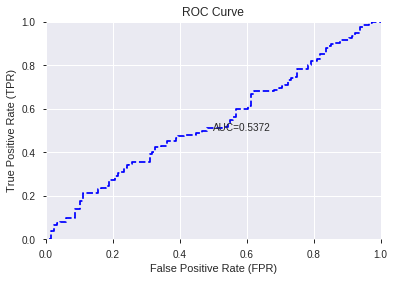

This function is available for GLM models only


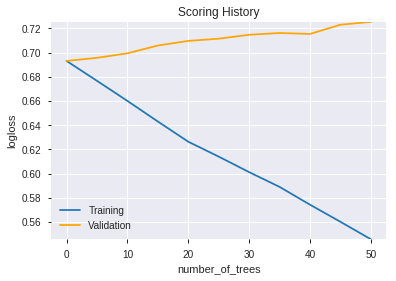

--2019-08-27 18:55:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.38.20
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.38.20|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.ge

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_185417_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_185417_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_9b73',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['day',
 'CORREL_14',
 'CCI_24',
 'HT_PHASOR_inphase',
 'CORREL_24',
 'Volume',
 'CORREL_12',
 'STOCHF_fastk',
 'HT_DCPERIOD',
 'CCI_12',
 'HT_PHASOR_quadrature',
 'PLUS_DI_12',
 'ADXR_12',
 'SIN',
 'DX_14',
 'MACDEXT_hist',
 'MOM_8',
 'TAN',
 'TRANGE',
 'STOCH_slowd',
 'WILLR_12',
 'STDDEV_14',
 'MOM_14',
 'DX_8',
 'BOP',
 'DX_24',
 'BETA_24',
 'COS',
 'STDDEV_24',
 'dayofyear',
 'ULTOSC',
 'CORREL_8',
 'CORREL_20',
 'MFI_24',
 'BETA_30',
 'STOCHRSI_fastd',
 'ROC_8',
 'ADX_24',
 'LINEARREG_ANGLE_12',
 'MFI_14',
 'CCI_8',
 'DX_20',
 'ADX_20',
 'BBANDS_upperband_14_5_2',
 'PLUS_DI_30',
 'OBV',
 'TRIX_14',
 'STDDEV_30',
 'NATR_8',
 'BETA_12',
 'MFI_12',
 'MACDEXT_signal',
 'STDDEV_12',
 'ATR_8',
 'TRIX_8',
 'aroondown_30',
 'NATR_30',
 'STOCH_slowk',
 'VAR_20',
 'DIV',
 'AD',
 'PLUS_DI_14',
 'MACDFIX_signal_24',
 'STOCHRSI_fastk',
 'LINEARREG_ANGLE_14',
 'ATR_20',
 'WILLR_14',
 'ROC_12',
 'MOM_30',
 'BBANDS_lowerband_20_7_4',
 'PLUS_DM_20',
 'BETA_8',
 'MACDFIX_signal_12',
 'ROC_14',
 'B

In [50]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [51]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

205

['BBANDS_lowerband_12_7_2',
 'BBANDS_upperband_12_7_3',
 'BBANDS_middleband_12_7_3',
 'BBANDS_lowerband_12_7_3',
 'BBANDS_upperband_12_7_4',
 'BBANDS_middleband_12_7_4',
 'BBANDS_lowerband_12_7_4',
 'BBANDS_upperband_12_7_5',
 'BBANDS_middleband_12_7_5',
 'BBANDS_lowerband_12_7_5',
 'DEMA_14',
 'SAR_0.14',
 'TEMA_14',
 'TRIMA_14',
 'WMA_14',
 'MA_14_0',
 'MAVP_14_0',
 'BBANDS_upperband_14_0_3',
 'BBANDS_middleband_14_0_3',
 'BBANDS_lowerband_14_0_3',
 'BBANDS_upperband_14_0_4',
 'BBANDS_middleband_14_0_4',
 'BBANDS_lowerband_14_0_4',
 'MAVP_14_1',
 'BBANDS_upperband_14_1_2',
 'BBANDS_lowerband_14_1_3',
 'BBANDS_lowerband_14_1_4',
 'BBANDS_middleband_14_1_5',
 'BBANDS_upperband_14_2_3',
 'BBANDS_lowerband_14_2_3',
 'BBANDS_upperband_14_2_4',
 'BBANDS_lowerband_14_2_4',
 'BBANDS_upperband_14_2_5',
 'BBANDS_middleband_14_2_5',
 'BBANDS_lowerband_14_2_5',
 'MA_14_3',
 'BBANDS_upperband_14_3_3',
 'BBANDS_lowerband_14_3_4',
 'MA_14_4',
 'BBANDS_lowerband_14_4_2',
 'BBANDS_lowerband_14_4_3',


AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_185627_model_2  0.580971  1.097877              0.477842  0.609265  0.371203
1  DeepLearning_grid_1_AutoML_20190827_185627_model_9  0.571807  0.690037              0.500000  0.498444  0.248446
2  DeepLearning_grid_1_AutoML_20190827_185627_model_5  0.565581  0.698494              0.500000  0.502626  0.252632
3  DeepLearning_grid_1_AutoML_20190827_185627_model_4  0.531226  0.972880              0.500000  0.570114  0.325030
4  DeepLearning_grid_1_AutoML_20190827_185627_model_1  0.521456  1.122090              0.485856  0.585471  0.342777
5  DeepLearning_grid_1_AutoML_20190827_185627_model_6  0.509387  0.698603              0.485249  0.502525  0.252532
6               DeepLearning_1_AutoML_20190827_185627  0.505939  0.744665              0.495690  0.521518  0.271981
7  DeepLearning_grid_1_AutoML_20190827_185627_model_8  0.500000  0.691743              0.500000  0.499297  0.249298
8  DeepLearning_grid_1_AutoML_20190827_185627_model_3  0.499361  0.938469              0.500000  0.568403  0.323083
9  DeepLearning_grid_1_AutoML_20190827_185627_model_7  0.492976  0.695577              0.487069  0.501369  0.251371

variable  relative_importance  scaled_importance  percentage
0                         BOP             1.000000           1.000000    0.007615
1                HT_TRENDMODE             0.924966           0.924966    0.007044
2              STOCHRSI_fastk             0.875870           0.875870    0.006670
3                      BETA_8             0.869289           0.869289    0.006620
4              CDLSPINNINGTOP             0.856369           0.856369    0.006521
..                        ...                  ...                ...         ...
200                    RSI_12             0.549158           0.549158    0.004182
201         CDLDARKCLOUDCOVER             0.548551           0.548551    0.004177
202                  TYPPRICE             0.546445           0.546445    0.004161
203  BBANDS_middleband_14_1_5             0.541656           0.541656    0.004125
204                    RSI_20             0.537090           0.537090    0.004090

[205 rows x 4 columns]

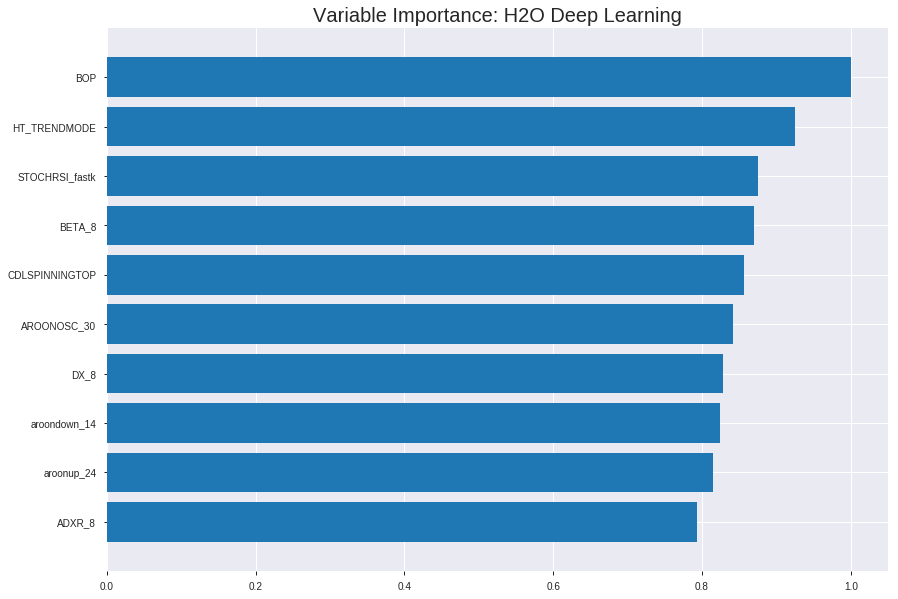

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_185627_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2834533498870468
RMSE: 0.5324033714084151
LogLoss: 0.7834075200926244
Mean Per-Class Error: 0.4607969772169207
AUC: 0.5277038434540724
pr_auc: 0.5593437586751698
Gini: 0.05540768690814479
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.051839756262117856: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      7    827   0.9916   (827.0/834.0)
1      2    917   0.0022   (2.0/919.0)
Total  9    1744  0.4729   (829.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0518398    0.688697   394
max f2                       0.0373996    0.846692   398
max f0point5                 0.0518398    0.580747   394
max accuracy                 0.632447     0.533371   135
max precision                0.958479     1          0
max recall                   0.0373996    1          398
max specificity              0.958479     1          0
max absolute_mcc             0.769538     0.0877223  57
max min_per_class_accuracy   0.56447      0.51469    173
max mean_per_class_accuracy  0.632447     0.539203   135

Gains/Lift Table: Avg response rate: 52.42 %, avg score: 53.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.893634           1.05973   1.05973            0.555556         0.919681  0.555556                    0.919681            0.0108814       0.0108814                  5.97268    5.97268
    2        0.0205362                   0.863915           1.1657    1.11271            0.611111         0.879286  0.583333                    0.899484            0.0119695       0.0228509                  16.5699    11.2713
    3        0.0302339                   0.846361           1.23427   1.1517             0.647059         0.855145  0.603774                    0.885262            0.0119695       0.0348205                  23.427     15.1703
    4        0.040502                    0.832869           1.05973   1.12839            0.555556         0.838894  0.591549                    0.873507            0.0108814       0.0457018                  5.97268    12.8385
    5        0.0501997                   0.820229           1.12206   1.12716            0.588235         0.825885  0.590909                    0.864307            0.0108814       0.0565832                  12.2064    12.7164
    6        0.100399                    0.7727             1.3656    1.24638            0.715909         0.791835  0.653409                    0.828071            0.0685528       0.125136                   36.5602    24.6383
    7        0.150029                    0.737624           0.833164  1.10969            0.436782         0.752916  0.581749                    0.80321             0.0413493       0.166485                   -16.6836   10.9691
    8        0.200228                    0.710231           1.06214   1.09777            0.556818         0.724058  0.575499                    0.783365            0.0533188       0.219804                   6.21352    9.77682
    9        0.300057                    0.66827            1.1554    1.11694            0.605714         0.689024  0.585551                    0.751978            0.115343        0.335147                   15.5405    11.6944
    10       0.399886                    0.621676           0.970104  1.08029            0.508571         0.646347  0.566334                    0.725608            0.0968444       0.431991                   -2.98958   8.02864
    11       0.500285                    0.562464           0.834535  1.03097            0.4375           0.593912  0.540479                    0.699179            0.0837867       0.515778                   -16.5465   3.09679
    12       0.600114                    0.509443           0.948304  1.01722            0.497143         0.535593  0.53327                     0.671966            0.0946681       0.610446                   -5.16959   1.72168
    13       0.699943                    0.433122           0.926504  1.00428            0.485714         0.473073  0.526487                    0.643599            0.0924918       0.702938                   -7.3496    0.427895
    14       0.799772                    0.340874           0.991904  1.00273            0.52             0.388503  0.525678                    0.611758            0.0990207       0.801959                   -0.809576  0.273432
    15       0.899601                    0.230655           0.948304  0.996694           0.497143         0.286686  0.522511                    0.575685            0.0946681       0.896627                   -5.16959   -0.330582
    16       1                           0.0330297          1.02962   1                  0.539773         0.14488   0.524244                



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.28108446619873984
RMSE: 0.5301739961547905
LogLoss: 0.7811942079398433
Mean Per-Class Error: 0.44223324268117103
AUC: 0.551063829787234
pr_auc: 0.5739091757674114
Gini: 0.10212765957446801
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.03284246286631693: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    235  1        (235.0/235.0)
1      0    266  0        (0.0/266.0)
Total  0    501  0.4691   (235.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0328425    0.693611  399
max f2                       0.0328425    0.84984   399
max f0point5                 0.152585     0.590047  365
max accuracy                 0.436491     0.55489   184
max precision                0.792759     1         0
max recall                   0.0328425    1         399
max specificity              0.792759     1         0
max absolute_mcc             0.50189      0.119864  137
max min_per_class_accuracy   0.417476     0.540426  201
max mean_per_class_accuracy  0.436491     0.557767  184

Gains/Lift Table: Avg response rate: 53.09 %, avg score: 41.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.776544           1.56955   1.56955            0.833333         0.784894  0.833333                    0.784894            0.018797        0.018797                   56.9549   56.9549
    2        0.0219561                   0.761035           1.13008   1.36979            0.6              0.764371  0.727273                    0.775565            0.0112782       0.0300752                  13.0075   36.9788
    3        0.0319361                   0.743558           0.753383  1.17716            0.4              0.750418  0.625                       0.767707            0.0075188       0.037594                   -24.6617  17.7162
    4        0.0419162                   0.725651           0.753383  1.07626            0.4              0.732041  0.571429                    0.759215            0.0075188       0.0451128                  -24.6617  7.62621
    5        0.0518962                   0.713605           0.376692  0.941729           0.2              0.71728   0.5                         0.75115             0.0037594       0.0488722                  -62.3308  -5.82707
    6        0.101796                    0.658299           1.05474   0.997125           0.56             0.681355  0.529412                    0.716937            0.0526316       0.101504                   5.47368   -0.287483
    7        0.151697                    0.603937           1.20541   1.06564            0.64             0.627004  0.565789                    0.687354            0.0601504       0.161654                   20.5414   6.56411
    8        0.201597                    0.566971           1.35609   1.13753            0.72             0.581914  0.60396                     0.661255            0.0676692       0.229323                   35.609    13.7534
    9        0.301397                    0.52368            1.13008   1.13506            0.6              0.54344   0.602649                    0.622243            0.112782        0.342105                   13.0075   13.5064
    10       0.401198                    0.473703           0.979398  1.09634            0.52             0.497125  0.58209                     0.59112             0.0977444       0.43985                    -2.06015  9.63416
    11       0.500998                    0.417596           1.01707   1.08055            0.54             0.442845  0.573705                    0.561583            0.101504        0.541353                   1.70677   8.055
    12       0.600798                    0.356374           0.715714  1.01995            0.38             0.385401  0.541528                    0.532317            0.0714286       0.612782                   -28.4286  1.9946
    13       0.700599                    0.303861           1.16774   1.041              0.62             0.32873   0.552707                    0.503316            0.116541        0.729323                   16.7744   4.09999
    14       0.800399                    0.236202           0.941729  1.02862            0.5              0.269924  0.546135                    0.474215            0.093985        0.823308                   -5.82707  2.86221
    15       0.9002                      0.165398           0.866391  1.01064            0.46             0.19838   0.536585                    0.443634            0.0864662       0.909774                   -13.3609  1.06363
    16       1                           0.0328425          0.90406   1                  0.48             0.113062  0.530938                    0.410643         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:57:23  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 18:57:26  57.552 sec        1853 obs/sec      2.34398   1             4109       0.536714         0.803426            -0.154961      0.542028        0.562875           1.27167          0.475185                         0.597279           1.02393               -0.432455        0.453943          0.489294             0.62782            0.469062
    2019-08-27 18:57:32  1 min  3.580 sec  2050 obs/sec      9.30918   4             16319      0.532403         0.783408            -0.136485      0.527704        0.559344           1.05973          0.472904                         0.530174           0.781194              -0.128659        0.551064          0.573909             1.56955            0.469062
    2019-08-27 18:57:38  1 min  9.745 sec  2343 obs/sec      18.6115   8             32626      0.514865         0.734565            -0.0628426     0.543843        0.561888           1.1657           0.474615                         0.540556           0.798262              -0.173295        0.485354          0.524912             1.25564            0.469062
    2019-08-27 18:57:43  1 min 14.897 sec  2596 obs/sec      27.9361   12            48972      0.519468         0.769431            -0.0819337     0.5846          0.591257           1.37764          0.456931                         0.541501           0.794984              -0.1774          0.467853          0.53207              1.56955            0.467066
    2019-08-27 18:57:48  1 min 20.252 sec  2884 obs/sec      39.5157   17            69271      0.506817         0.730157            -0.029874      0.612853        0.608642           1.37764          0.416999                         0.539917           0.791139              -0.170525        0.475076          0.533873             1.56955            0.469062
    2019-08-27 18:57:54  1 min 26.134 sec  3164 obs/sec      53.567    23            93903      0.485343         0.668732            0.0555489      0.664188        0.678217           1.80154          0.440958                         0.553535           0.850586              -0.230314        0.47214           0.509361             0.31391            0.467066
    2019-08-27 18:58:00  1 min 31.484 sec  3402 obs/sec      67.5488   29            118413     0.47496          0.657115            0.0955257      0.69973         0.692146           1.58959          0.369652                         0.561272           0.883236              -0.26495         0.476132          0.514152             0.941729           0.469062
    2019-08-27 18:58:00  1 min 31.699 sec  3401 obs/sec      67.5488   29            118413     0.532403         0.783408            -0.136485      0.527704        0.559344           1.05973          0.472904                         0.530174           0.781194              -0.128659        0.551064          0.573909             1.56955            0.469062

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.007615153308181289
HT_TRENDMODE              0.9249661564826965     0.9249661564826965   0.007043759086494938
STOCHRSI_fastk            0.8758697509765625     0.8758697509765625   0.0066698824316850916
BETA_8                    0.8692892789840698     0.8692892789840698   0.006619771128622067
CDLSPINNINGTOP            0.8563694953918457     0.8563694953918457   0.006521384995858755
---                       ---                    ---                  ---
RSI_12                    0.5491579174995422     0.5491579174995422   0.004181921732160586
CDLDARKCLOUDCOVER         0.5485514402389526     0.5485514402389526   0.004177303314843271
TYPPRICE                  0.5464451909065247     0.5464451909065247   0.0041612639032715774
BBANDS_middleband_14_1_5  0.541656494140625      0.541656494140625    0.004124797243252859
RSI_20                    0.5370895266532898     0.5370895266532898   0.004090019085683323


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5896414342629482)

('F1', 0.7071240105540898)

('auc', 0.580970625798212)

('logloss', 1.0978769140514346)

('mean_per_class_error', 0.4045338441890166)

('rmse', 0.6092646309091602)

('mse', 0.3712033904768751)

deeplearning prediction progress: |███████████████████████████████████████| 100%


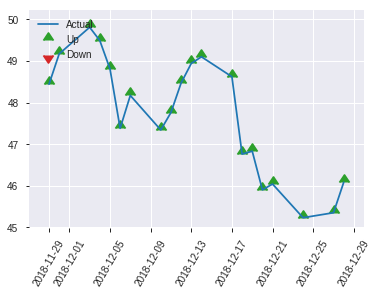


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3712033904768751
RMSE: 0.6092646309091602
LogLoss: 1.0978769140514346
Mean Per-Class Error: 0.4045338441890166
AUC: 0.580970625798212
pr_auc: 0.5965486049252585
Gini: 0.16194125159642403
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.019084469137427416: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    110  0.9483   (110.0/116.0)
1      1    134  0.0074   (1.0/135.0)
Total  7    244  0.4422   (111.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0190845    0.707124  243
max f2                       0.013762     0.857687  246
max f0point5                 0.171746     0.617597  113
max accuracy                 0.180508     0.589641  107
max precision                0.605356     1         0
max recall                   0.013762     1         246
max specificity              0.605356     1         0
max absolute_mcc             0.209273     0.196137  94
max min_per_class_accuracy   0.155614     0.577586  126
max mean_per_class_accuracy  0.180508     0.595466  107

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 18.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.507667           0.619753  0.619753           0.333333         0.554029   0.333333                    0.554029            0.00740741      0.00740741                 -38.0247  -38.0247
    2        0.0239044                   0.468219           0.619753  0.619753           0.333333         0.486608   0.333333                    0.520318            0.00740741      0.0148148                  -38.0247  -38.0247
    3        0.0318725                   0.437984           1.85926   0.92963            1                0.446954   0.5                         0.501977            0.0148148       0.0296296                  85.9259   -7.03704
    4        0.0438247                   0.423483           1.23951   1.01414            0.666667         0.430977   0.545455                    0.482614            0.0148148       0.0444444                  23.9506   1.41414
    5        0.0517928                   0.421821           1.85926   1.14416            1                0.422772   0.615385                    0.473407            0.0148148       0.0592593                  85.9259   14.416
    6        0.103586                    0.384777           1.4302    1.28718            0.769231         0.407201   0.692308                    0.440304            0.0740741       0.133333                   43.0199   28.7179
    7        0.151394                    0.336962           0.92963   1.17427            0.5              0.357827   0.631579                    0.414259            0.0444444       0.177778                   -7.03704  17.4269
    8        0.203187                    0.307601           1.14416   1.16659            0.615385         0.320069   0.627451                    0.390249            0.0592593       0.237037                   14.416    16.6594
    9        0.302789                    0.237908           1.41304   1.24766            0.76             0.264767   0.671053                    0.348972            0.140741        0.377778                   41.3037   24.7661
    10       0.40239                     0.200738           1.04119   1.19655            0.56             0.217976   0.643564                    0.316548            0.103704        0.481481                   4.11852   19.6553
    11       0.501992                    0.157852           0.892444  1.13621            0.48             0.17449    0.611111                    0.288362            0.0888889       0.57037                    -10.7556  13.6214
    12       0.601594                    0.122841           0.743704  1.07123            0.4              0.139563   0.576159                    0.263726            0.0740741       0.644444                   -25.6296  7.12288
    13       0.701195                    0.0927919          0.669333  1.01414            0.36             0.106351   0.545455                    0.241372            0.0666667       0.711111                   -33.0667  1.41414
    14       0.800797                    0.0675825          1.11556   1.02676            0.6              0.0811378  0.552239                    0.221442            0.111111        0.822222                   11.5556   2.67551
    15       0.900398                    0.0439634          0.966815  1.02012            0.52             0.0566875  0.548673                    0.203217            0.0962963       0.918519                   -3.31852  2.01245
    16       1                           0.00839995         0.818074  1                  0.44             0.0266124  0.537849                 

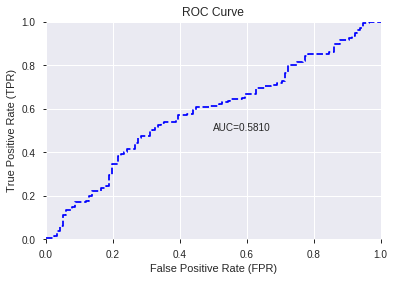

This function is available for GLM models only


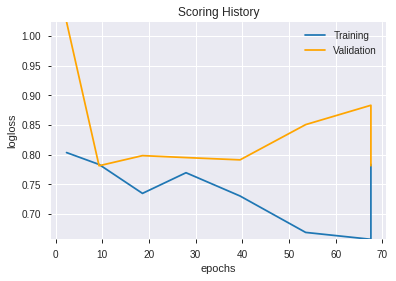

--2019-08-27 19:06:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.115.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.115.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_185627_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_185627_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_9b73',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'HT_TRENDMODE',
 'STOCHRSI_fastk',
 'BETA_8',
 'CDLSPINNINGTOP',
 'AROONOSC_30',
 'DX_8',
 'aroondown_14',
 'aroonup_24',
 'ADXR_8',
 'TRANGE',
 'ADX_24',
 'HT_PHASOR_inphase',
 'aroondown_8',
 'AROONOSC_12',
 'AROONOSC_20',
 'STOCH_slowd',
 'aroondown_20',
 'DX_12',
 'WILLR_12',
 'CDLSTALLEDPATTERN',
 'CDLLONGLINE',
 'HT_PHASOR_quadrature',
 'MFI_14',
 'DX_20',
 'CDLSHORTLINE',
 'STOCH_slowk',
 'STOCHF_fastd',
 'CCI_12',
 'MFI_8',
 'AROONOSC_14',
 'STOCHF_fastk',
 'PLUS_DI_8',
 'MINUS_DI_14',
 'DX_14',
 'AROONOSC_24',
 'ADXR_14',
 'CDLCLOSINGMARUBOZU',
 'MINUS_DI_20',
 'CDLHIGHWAVE',
 'WILLR_8',
 'ADX_14',
 'PLUS_DI_24',
 'MOM_8',
 'ADX_20',
 'ROCR_12',
 'ADX_12',
 'MINUS_DM_20',
 'BBANDS_lowerband_30_7_3',
 'ADOSC',
 'MINUS_DI_8',
 'MOM_20',
 'PLUS_DI_14',
 'ATR_14',
 'PPO',
 'WILLR_24',
 'BBANDS_upperband_20_2_5',
 'BBANDS_lowerband_14_2_4',
 'ATR_20',
 'BBANDS_middleband_14_0_4',
 'BBANDS_lowerband_20_1_5',
 'ATR_24',
 'RSI_8',
 'ROC_30',
 'BBANDS_lowerband_20_5_2',
 'ROCR

In [52]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_190628_model_1  0.507024  0.692759              0.473531  0.499808  0.249808

variable  relative_importance  scaled_importance  percentage
0                CDLSHORTLINE         9.237077e-03           1.000000    0.036632
1                         BOP         5.211188e-03           0.564160    0.020666
2                        DX_8         4.036723e-03           0.437013    0.016009
3                  aroonup_24         3.926978e-03           0.425132    0.015573
4          CDLCLOSINGMARUBOZU         3.626906e-03           0.392647    0.014383
..                        ...                  ...                ...         ...
200  BBANDS_middleband_14_0_4         1.663714e-05           0.001801    0.000066
201  BBANDS_middleband_14_0_3         1.042606e-05           0.001129    0.000041
202   BBANDS_lowerband_14_2_4         9.291823e-06           0.001006    0.000037
203         CDLDARKCLOUDCOVER         8.425560e-07           0.000091    0.000003
204   BBANDS_lowerband_14_1_3         7.946245e-07           0.000086    0.000003

[205 rows x 4 columns]

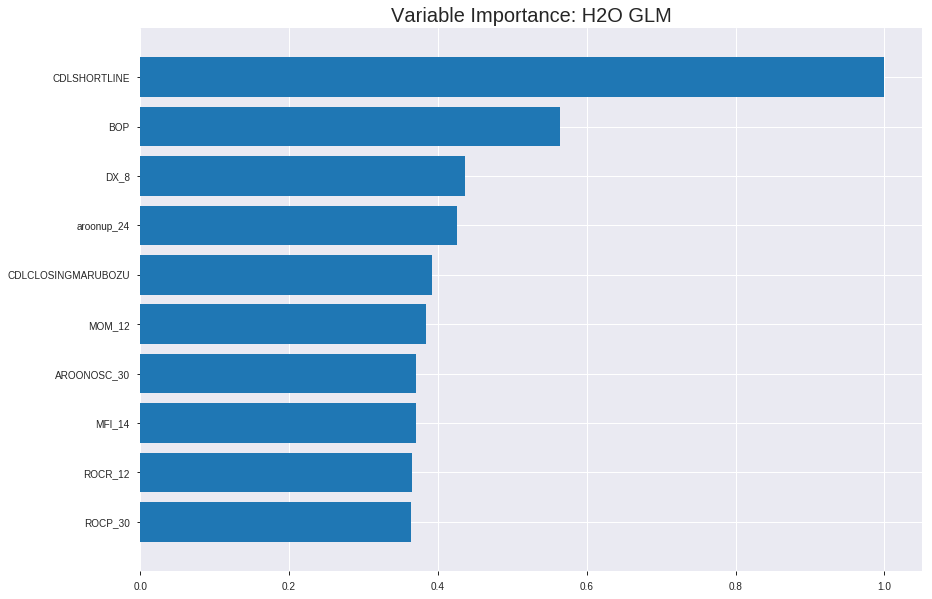

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_190628_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24799158537420324
RMSE: 0.4979875353602771
LogLoss: 0.6891193601383041
Null degrees of freedom: 1752
Residual degrees of freedom: 1547
Null deviance: 2426.050892509706
Residual deviance: 2416.0524766448943
AIC: 2828.0524766448943
AUC: 0.5481997427085535
pr_auc: 0.5623830920511353
Gini: 0.09639948541710708
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4707720682493893: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      7    827   0.9916   (827.0/834.0)
1      0    919   0        (0.0/919.0)
Total  7    1746  0.4718   (827.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.470772     0.689681  392
max f2                       0.470772     0.847473  392
max f0point5                 0.512608     0.58699   266
max accuracy                 0.512608     0.555619  266
max precision                0.596227     1         0
max recall                   0.470772     1         392
max specificity              0.596227     1         0
max absolute_mcc             0.512608     0.100247  266
max min_per_class_accuracy   0.523082     0.531175  209
max mean_per_class_accuracy  0.515995     0.547789  247

Gains/Lift Table: Avg response rate: 52.42 %, avg score: 52.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.57717            1.37764   1.37764            0.722222         0.584629  0.722222                    0.584629            0.0141458       0.0141458                  37.7645    37.7645
    2        0.0205362                   0.571664           1.05973   1.21869            0.555556         0.57384   0.638889                    0.579234            0.0108814       0.0250272                  5.97268    21.8686
    3        0.0302339                   0.56768            0.897651  1.11571            0.470588         0.569747  0.584906                    0.576191            0.00870511      0.0337323                  -10.2349   11.5712
    4        0.040502                    0.562456           1.37764   1.18212            0.722222         0.564587  0.619718                    0.573249            0.0141458       0.0478781                  37.7645    18.2118
    5        0.0501997                   0.559576           0.897651  1.12716            0.470588         0.561062  0.590909                    0.570895            0.00870511      0.0565832                  -10.2349   12.7164
    6        0.100399                    0.551758           1.12716   1.12716            0.590909         0.555168  0.590909                    0.563031            0.0565832       0.113166                   12.7164    12.7164
    7        0.150029                    0.546906           1.05242   1.10244            0.551724         0.549298  0.577947                    0.558488            0.0522307       0.165397                   5.24183    10.2438
    8        0.200228                    0.542214           1.06214   1.09233            0.556818         0.544604  0.57265                     0.555007            0.0533188       0.218716                   6.21352    9.23337
    9        0.300057                    0.534864           0.882904  1.02266            0.462857         0.538214  0.536122                    0.54942             0.0881393       0.306855                   -11.7096   2.26565
    10       0.399886                    0.528649           1.17721   1.06124            0.617143         0.531756  0.556348                    0.545011            0.117519        0.424374                   17.7205    6.12385
    11       0.500285                    0.523138           1.06214   1.06142            0.556818         0.525767  0.556442                    0.541149            0.106638        0.531012                   6.21352    6.14185
    12       0.600114                    0.518596           1.1009    1.06799            0.577143         0.520703  0.559886                    0.537747            0.109902        0.640914                   10.0905    6.7987
    13       0.699943                    0.513172           0.991904  1.05714            0.52             0.515959  0.554197                    0.53464             0.0990207       0.739935                   -0.809576  5.71357
    14       0.799772                    0.506647           0.893804  1.03675            0.468571         0.509999  0.543509                    0.531564            0.0892274       0.829162                   -10.6196   3.67484
    15       0.899601                    0.496987           0.893804  1.02089            0.468571         0.502486  0.535193                    0.528337            0.0892274       0.91839                    -10.6196   2.08858
    16       1                           0.452118           0.812859  1                  0.426136         0.487568  0.524244                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2500450517988884
RMSE: 0.5000450497694067
LogLoss: 0.6932396496170935
Null degrees of freedom: 500
Residual degrees of freedom: 295
Null deviance: 692.7041364892402
Residual deviance: 694.6261289163277
AIC: 1106.6261289163276
AUC: 0.49938409854423293
pr_auc: 0.5261327640403954
Gini: -0.00123180291153413
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47637469198858595: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    232  0.9872   (232.0/235.0)
1      1    265  0.0038   (1.0/266.0)
Total  4    497  0.4651   (233.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.476375     0.694626  395
max f2                       0.471261     0.850384  398
max f0point5                 0.476375     0.587844  395
max accuracy                 0.476375     0.53493   395
max precision                0.554976     1         0
max recall                   0.471261     1         398
max specificity              0.554976     1         0
max absolute_mcc             0.490901     0.107944  357
max min_per_class_accuracy   0.51459      0.518797  195
max mean_per_class_accuracy  0.515698     0.525956  181

Gains/Lift Table: Avg response rate: 53.09 %, avg score: 51.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.553089           1.25564   1.25564            0.666667         0.554277  0.666667                    0.554277            0.0150376       0.0150376                  25.5639   25.5639
    2        0.0219561                   0.550867           1.13008   1.19856            0.6              0.551886  0.636364                    0.55319             0.0112782       0.0263158                  13.0075   19.8565
    3        0.0319361                   0.546929           0.376692  0.941729           0.2              0.549131  0.5                         0.551922            0.0037594       0.0300752                  -62.3308  -5.82707
    4        0.0419162                   0.545612           0.753383  0.896885           0.4              0.545803  0.47619                     0.550465            0.0075188       0.037594                   -24.6617  -10.3115
    5        0.0518962                   0.54454            0         0.724407           0                0.545093  0.384615                    0.549432            0               0.037594                   -100      -27.5593
    6        0.101796                    0.536873           0.979398  0.849403           0.52             0.540047  0.45098                     0.544832            0.0488722       0.0864662                  -2.06015  -15.0597
    7        0.151697                    0.530226           1.28075   0.991294           0.68             0.533062  0.526316                    0.54096             0.0639098       0.150376                   28.0752   -0.870598
    8        0.201597                    0.52608            0.979398  0.98835            0.52             0.528196  0.524752                    0.537801            0.0488722       0.199248                   -2.06015  -1.16504
    9        0.301397                    0.521244           1.13008   1.03528            0.6              0.523459  0.549669                    0.533052            0.112782        0.31203                    13.0075   3.52786
    10       0.401198                    0.517667           1.05474   1.04012            0.56             0.519295  0.552239                    0.52963             0.105263        0.417293                   5.47368   4.0119
    11       0.500998                    0.514367           1.01707   1.03553            0.54             0.51584   0.549801                    0.526883            0.101504        0.518797                   1.70677   3.55271
    12       0.600798                    0.511053           0.90406   1.01369            0.48             0.512631  0.538206                    0.524515            0.0902256       0.609023                   -9.59398  1.36887
    13       0.700599                    0.506976           0.866391  0.992706           0.46             0.508967  0.527066                    0.5223              0.0864662       0.695489                   -13.3609  -0.729388
    14       0.800399                    0.501184           0.979398  0.991047           0.52             0.503762  0.526185                    0.519989            0.0977444       0.793233                   -2.06015  -0.895318
    15       0.9002                      0.492772           0.791053  0.968875           0.42             0.497289  0.514412                    0.517472            0.0789474       0.87218                    -20.8947  -3.11255
    16       1                           0.468115           1.28075   1                  0.68             0.484148  0.530938                    0.5141


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 19:06:28  0.000 sec   2            3.2       206           1.37824           1.38648
    2019-08-27 19:06:29  0.112 sec   4            2.4       206           1.37723           1.3874
    2019-08-27 19:06:29  0.220 sec   6            1.7       206           1.37602           1.3885
    2019-08-27 19:06:29  0.329 sec   8            1.3       206           1.37458           1.38971
    2019-08-27 19:06:29  0.453 sec   10           0.91      206           1.3729            1.39101

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5617529880478087)

('F1', 0.708994708994709)

('auc', 0.5070242656449553)

('logloss', 0.6927590721413646)

('mean_per_class_error', 0.46471902937420184)

('rmse', 0.4998077022378599)

('mse', 0.24980773921628924)

glm prediction progress: |████████████████████████████████████████████████| 100%


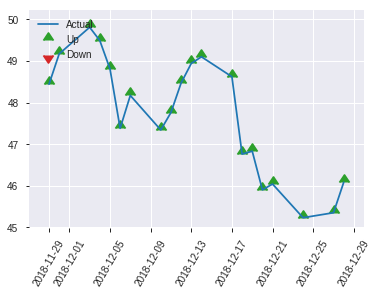


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24980773921628924
RMSE: 0.4998077022378599
LogLoss: 0.6927590721413646
Null degrees of freedom: 250
Residual degrees of freedom: 45
Null deviance: 346.70670784719556
Residual deviance: 347.765054214965
AIC: 759.765054214965
AUC: 0.5070242656449553
pr_auc: 0.548536919159561
Gini: 0.01404853128991057
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46533671151431727: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    109  0.9397   (109.0/116.0)
1      1    134  0.0074   (1.0/135.0)
Total  8    243  0.4382   (110.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.465337     0.708995  242
max f2                       0.463289     0.858779  245
max f0point5                 0.465337     0.605239  242
max accuracy                 0.466741     0.561753  238
max precision                0.543828     1         0
max recall                   0.463289     1         245
max specificity              0.543828     1         0
max absolute_mcc             0.463289     0.1538    245
max min_per_class_accuracy   0.503375     0.474074  123
max mean_per_class_accuracy  0.528482     0.535281  28

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 50.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.539073           0.619753  0.619753           0.333333         0.54136   0.333333                    0.54136             0.00740741      0.00740741                 -38.0247  -38.0247
    2        0.0239044                   0.538129           1.23951   0.92963            0.666667         0.538539  0.5                         0.539949            0.0148148       0.0222222                  23.9506   -7.03704
    3        0.0318725                   0.536319           1.85926   1.16204            1                0.536477  0.625                       0.539081            0.0148148       0.037037                   85.9259   16.2037
    4        0.0438247                   0.535374           1.85926   1.35219            1                0.535819  0.727273                    0.538191            0.0222222       0.0592593                  85.9259   35.2189
    5        0.0517928                   0.533779           0.92963   1.28718            0.5              0.534457  0.692308                    0.537617            0.00740741      0.0666667                  -7.03704  28.7179
    6        0.103586                    0.529876           1.14416   1.21567            0.615385         0.531435  0.653846                    0.534526            0.0592593       0.125926                   14.416    21.567
    7        0.151394                    0.526389           0.92963   1.12534            0.5              0.527742  0.605263                    0.532384            0.0444444       0.17037                    -7.03704  12.5341
    8        0.203187                    0.521744           0.7151    1.02077            0.384615         0.524152  0.54902                     0.530286            0.037037        0.207407                   -28.49    2.07698
    9        0.302789                    0.513907           0.818074  0.954094           0.44             0.517952  0.513158                    0.526228            0.0814815       0.288889                   -18.1926  -4.59064
    10       0.40239                     0.509359           1.33867   1.04928            0.72             0.511843  0.564356                    0.522668            0.133333        0.422222                   33.8667   4.92849
    11       0.501992                    0.503033           0.520593  0.944386           0.28             0.506281  0.507937                    0.519416            0.0518519       0.474074                   -47.9407  -5.56143
    12       0.601594                    0.496336           1.33867   1.00966            0.72             0.49939   0.543046                    0.516101            0.133333        0.607407                   33.8667   0.966397
    13       0.701195                    0.491205           1.04119   1.01414            0.56             0.494135  0.545455                    0.51298             0.103704        0.711111                   4.11852   1.41414
    14       0.800797                    0.482418           0.818074  0.989755           0.44             0.485575  0.532338                    0.509572            0.0814815       0.792593                   -18.1926  -1.02451
    15       0.900398                    0.472824           1.11556   1.00367            0.6              0.477629  0.539823                    0.506038            0.111111        0.903704                   11.5556   0.367093
    16       1                           0.453209           0.966815  1                  0.52             0.466453  0.537849                    0.502095   

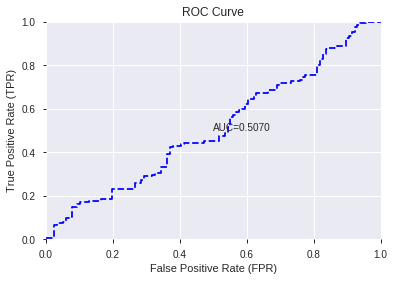

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


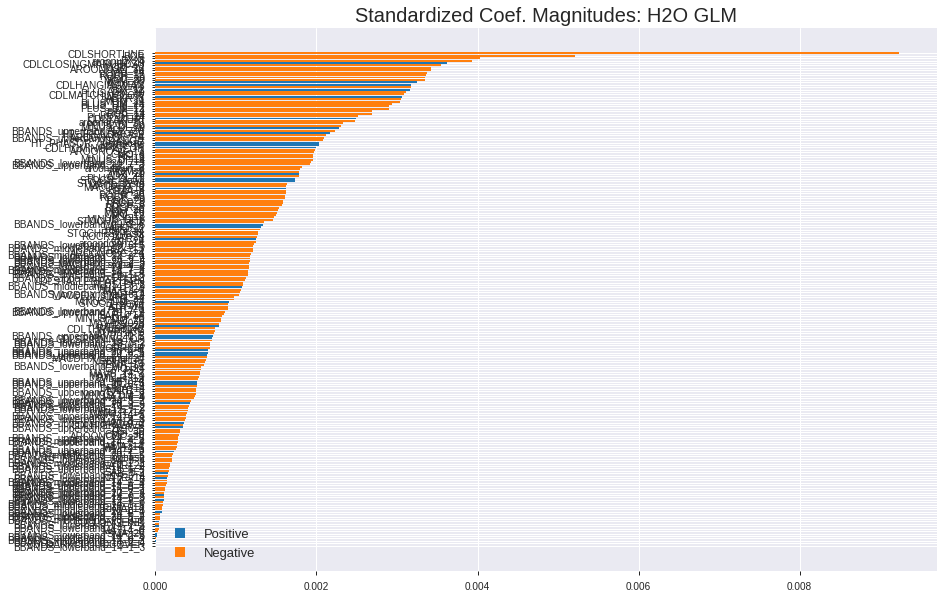

'log_likelihood'
--2019-08-27 19:06:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.81.16
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.81.16|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_190628_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_190628_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_9b73',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CDLSHORTLINE',
 'BOP',
 'DX_8',
 'aroonup_24',
 'CDLCLOSINGMARUBOZU',
 'MOM_12',
 'AROONOSC_30',
 'MFI_14',
 'ROCR_12',
 'ROCP_30',
 'ROC_30',
 'MOM_30',
 'ADX_12',
 'CDLHANGINGMAN',
 'DX_12',
 'ADX_14',
 'PLUS_DM_30',
 'CDLMATCHINGLOW',
 'ADXR_8',
 'MOM_14',
 'PLUS_DM_24',
 'PLUS_DM_14',
 'PLUS_DM_12',
 'DX_14',
 'ROC_14',
 'ROCP_14',
 'PLUS_DI_24',
 'CDLTAKURI',
 'aroondown_20',
 'PLUS_DI_20',
 'MINUS_DI_20',
 'ADX_20',
 'BBANDS_upperband_12_7_5',
 'HT_TRENDMODE',
 'AROONOSC_14',
 'BBANDS_upperband_12_7_4',
 'TRANGE',
 'HT_PHASOR_quadrature',
 'ADXR_14',
 'CDLHOMINGPIGEON',
 'AROONOSC_12',
 'CMO_8',
 'RSI_8',
 'MINUS_DI_14',
 'PLUS_DI_14',
 'BBANDS_lowerband_30_7_3',
 'BBANDS_upperband_12_7_3',
 'aroondown_8',
 'MOM_8',
 'DX_20',
 'ADX_24',
 'PLUS_DI_12',
 'STOCH_slowk',
 'STOCHF_fastd',
 'MACDFIX_8',
 'MACDFIX_12',
 'BETA_8',
 'MFI_8',
 'ROCR_20',
 'ROCP_20',
 'ROC_20',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'MFI_20',
 'MOM_20',
 'CMO_12',
 'RSI_12',
 'MINUS_DI_8',
 'STOCHF_fastk',
 'BB

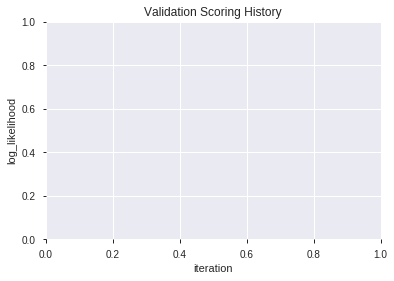

In [53]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190827_190643  0.521775  0.705891              0.462484  0.505979  0.256015
1  XGBoost_grid_1_AutoML_20190827_190643_model_4  0.508876  0.698319              0.472318  0.502568  0.252575
2               XGBoost_1_AutoML_20190827_190643  0.506897  0.706239              0.468008  0.506455  0.256496
3  XGBoost_grid_1_AutoML_20190827_190643_model_6  0.492593  0.714399              0.500000  0.509988  0.260088
4  XGBoost_grid_1_AutoML_20190827_190643_model_1  0.490230  0.706169              0.476628  0.506034  0.256070
5  XGBoost_grid_1_AutoML_20190827_190643_model_5  0.489974  0.771759              0.500000  0.532384  0.283432
6  XGBoost_grid_1_AutoML_20190827_190643_model_7  0.488506  0.732361              0.487069  0.518078  0.268405
7               XGBoost_3_AutoML_20190827_190643  0.486909  0.711380              0.495690  0.508653  0.258727
8  XGBoost_grid_1_AutoML_20190827_190643_model_3  0.477778  0.723440              0.495690  0.514109  0.264308
9  XGBoost_grid_1_AutoML_20190827_190643_model_2  0.471839  0.707180              0.500000  0.506801  0.256847

variable  relative_importance  scaled_importance  percentage
0                         BOP           173.494675           1.000000    0.029534
1              STOCHRSI_fastk           136.755600           0.788241    0.023280
2        HT_PHASOR_quadrature           123.970940           0.714552    0.021103
3                      CCI_24           108.127304           0.623231    0.018406
4                      TRANGE            97.041451           0.559334    0.016519
..                        ...                  ...                ...         ...
173   BBANDS_upperband_14_1_2             3.554330           0.020487    0.000605
174   BBANDS_lowerband_14_2_4             3.080280           0.017754    0.000524
175  BBANDS_middleband_14_6_4             2.122304           0.012233    0.000361
176  BBANDS_middleband_20_5_2             1.876484           0.010816    0.000319
177   BBANDS_lowerband_14_0_3             1.729765           0.009970    0.000294

[178 rows x 4 columns]

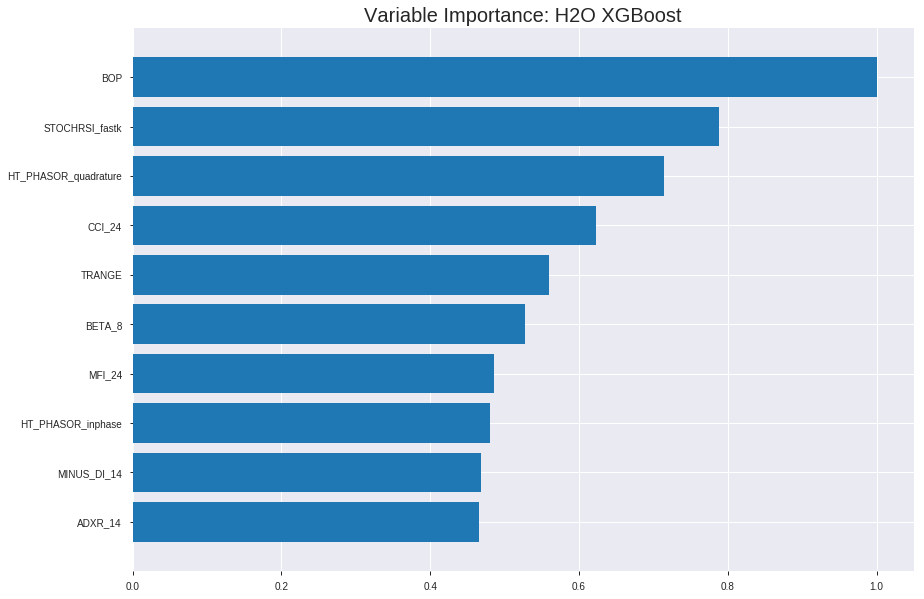

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190827_190643


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1785100795309525
RMSE: 0.4225045319649867
LogLoss: 0.5455162636875747
Mean Per-Class Error: 0.1500666713636707
AUC: 0.9268911312734361
pr_auc: 0.9370838091485596
Gini: 0.8537822625468723
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48928438127040863: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      620  214   0.2566   (214.0/834.0)
1      72   847   0.0783   (72.0/919.0)
Total  692  1061  0.1631   (286.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489284     0.855556  224
max f2                       0.455584     0.905552  253
max f0point5                 0.569455     0.874561  154
max accuracy                 0.530222     0.849401  187
max precision                0.799459     1         0
max recall                   0.309924     1         370
max specificity              0.799459     1         0
max absolute_mcc             0.530222     0.699094  187
max min_per_class_accuracy   0.525557     0.845324  191
max mean_per_class_accuracy  0.530222     0.849933  187

Gains/Lift Table: Avg response rate: 52.42 %, avg score: 52.38 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.754463           1.90751    1.90751            1                0.769372  1                           0.769372            0.0195865       0.0195865                  90.7508   90.7508
    2        0.0205362                   0.737142           1.90751    1.90751            1                0.742384  1                           0.755878            0.0195865       0.039173                   90.7508   90.7508
    3        0.0302339                   0.723975           1.90751    1.90751            1                0.729368  1                           0.747375            0.0184984       0.0576714                  90.7508   90.7508
    4        0.040502                    0.711587           1.90751    1.90751            1                0.718515  1                           0.740058            0.0195865       0.0772579                  90.7508   90.7508
    5        0.0501997                   0.703644           1.90751    1.90751            1                0.706647  1                           0.733604            0.0184984       0.0957563                  90.7508   90.7508
    6        0.100399                    0.674786           1.90751    1.90751            1                0.686593  1                           0.710098            0.0957563       0.191513                   90.7508   90.7508
    7        0.150029                    0.653134           1.90751    1.90751            1                0.662925  1                           0.694494            0.0946681       0.286181                   90.7508   90.7508
    8        0.200228                    0.634816           1.8208     1.88577            0.954545         0.643182  0.988604                    0.681629            0.0914037       0.377584                   82.0803   88.577
    9        0.300057                    0.599064           1.78761    1.85311            0.937143         0.615809  0.971483                    0.659731            0.178455        0.556039                   78.7608   85.3112
    10       0.399886                    0.567246           1.51511    1.76873            0.794286         0.582523  0.927247                    0.640456            0.151251        0.707291                   51.5106   76.8731
    11       0.500285                    0.531793           1.23555    1.66173            0.647727         0.54857   0.871152                    0.622016            0.124048        0.831338                   23.5545   66.1729
    12       0.600114                    0.491803           0.861104   1.52855            0.451429         0.511356  0.801331                    0.603608            0.085963        0.917301                   -13.8896  52.8545
    13       0.699943                    0.450627           0.468702   1.37739            0.245714         0.470362  0.722086                    0.584604            0.04679         0.964091                   -53.1298  37.7386
    14       0.799772                    0.412406           0.196201   1.22995            0.102857         0.431846  0.644793                    0.565536            0.0195865       0.983678                   -80.3799  22.9948
    15       0.899601                    0.365242           0.130801   1.10798            0.0685714        0.389286  0.58085                     0.545978            0.0130577       0.996736                   -86.9199  10.7976
    16       1                           0.218123           0.0325143  1                  0.0170455        0.324791  0.524244                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25799793257240544
RMSE: 0.5079349688418838
LogLoss: 0.7105466666354806
Mean Per-Class Error: 0.45919852823548235
AUC: 0.5098544232922733
pr_auc: 0.5221825747687275
Gini: 0.019708846584546524
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25023865699768066: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    235  1        (235.0/235.0)
1      0    266  0        (0.0/266.0)
Total  0    501  0.4691   (235.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.250239     0.693611  399
max f2                       0.250239     0.84984   399
max f0point5                 0.451284     0.593645  296
max accuracy                 0.451284     0.556886  296
max precision                0.53383      0.558036  174
max recall                   0.250239     1         399
max specificity              0.739823     0.995745  0
max absolute_mcc             0.710037     0.117133  5
max min_per_class_accuracy   0.521638     0.507519  193
max mean_per_class_accuracy  0.451284     0.540801  296

Gains/Lift Table: Avg response rate: 53.09 %, avg score: 51.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.710037           0         0                  0                0.724856  0                           0.724856            0               0                          -100      -100
    2        0.0219561                   0.695009           1.88346   0.856118           1                0.697409  0.454545                    0.71238             0.018797        0.018797                   88.3459   -14.3882
    3        0.0319361                   0.68909            1.13008   0.941729           0.6              0.691321  0.5                         0.705799            0.0112782       0.0300752                  13.0075   -5.82707
    4        0.0419162                   0.684399           1.13008   0.986574           0.6              0.686751  0.52381                     0.701264            0.0112782       0.0413534                  13.0075   -1.34264
    5        0.0518962                   0.67349            0.753383  0.941729           0.4              0.677797  0.5                         0.696751            0.0075188       0.0488722                  -24.6617  -5.82707
    6        0.101796                    0.64115            0.90406   0.923264           0.48             0.654803  0.490196                    0.676188            0.0451128       0.093985                   -9.59398  -7.6736
    7        0.151697                    0.624059           0.90406   0.916947           0.48             0.630948  0.486842                    0.661306            0.0451128       0.139098                   -9.59398  -8.3053
    8        0.201597                    0.608431           0.979398  0.932405           0.52             0.616648  0.49505                     0.650252            0.0488722       0.18797                    -2.06015  -6.75947
    9        0.301397                    0.577376           1.05474   0.972912           0.56             0.591318  0.516556                    0.630737            0.105263        0.293233                   5.47368   -2.70876
    10       0.401198                    0.546498           1.16774   1.02138            0.62             0.561218  0.542289                    0.613444            0.116541        0.409774                   16.7744   2.13781
    11       0.500998                    0.521143           0.979398  1.01302            0.52             0.533272  0.537849                    0.597474            0.0977444       0.507519                   -2.06015  1.30156
    12       0.600798                    0.496227           1.01707   1.01369            0.54             0.507367  0.538206                    0.582506            0.101504        0.609023                   1.70677   1.36887
    13       0.700599                    0.470528           1.24308   1.04637            0.66             0.482925  0.555556                    0.568321            0.12406         0.733083                   24.3083   4.63659
    14       0.800399                    0.438701           0.90406   1.02862            0.48             0.454079  0.546135                    0.554076            0.0902256       0.823308                   -9.59398  2.86221
    15       0.9002                      0.390638           0.715714  0.993932           0.38             0.415952  0.527716                    0.538763            0.0714286       0.894737                   -28.4286  -0.606839
    16       1                           0.250239           1.05474   1                  0.56             0.343972  0.530938                    0.519323    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 19:06:45  0.002 sec   0                  0.5              0.693147            0.5             0                  1                0.475756                         0.5                0.693147              0.5               0                    1                  0.469062
    2019-08-27 19:06:45  0.195 sec   5                  0.489279         0.671887            0.744208        0.762139           1.80711          0.348545                         0.501867           0.696895              0.463654          0.506218             0.941729           0.469062
    2019-08-27 19:06:45  0.354 sec   10                 0.480532         0.654779            0.799242        0.81545            1.90751          0.284655                         0.502463           0.698145              0.485346          0.517176             1.25564            0.469062
    2019-08-27 19:06:46  0.507 sec   15                 0.472087         0.638435            0.833723        0.846919           1.90751          0.245864                         0.5039             0.701111              0.482139          0.510825             0.62782            0.469062
    2019-08-27 19:06:46  0.677 sec   20                 0.463932         0.622769            0.851413        0.865651           1.90751          0.229321                         0.505634           0.704739              0.477212          0.499766             0                  0.469062
    2019-08-27 19:06:46  0.829 sec   25                 0.455919         0.607487            0.863392        0.875349           1.90751          0.219624                         0.505673           0.704874              0.487986          0.504328             0.31391            0.467066
    2019-08-27 19:06:46  0.976 sec   30                 0.448415         0.593374            0.880921        0.890736           1.90751          0.211067                         0.506753           0.707247              0.490705          0.50151              0.31391            0.467066
    2019-08-27 19:06:46  1.153 sec   35                 0.441182         0.579811            0.893626        0.9051             1.90751          0.187108                         0.506322           0.706518              0.500856          0.509975             0                  0.469062
    2019-08-27 19:06:46  1.308 sec   40                 0.435251         0.568825            0.90551         0.914044           1.90751          0.175128                         0.506368           0.706829              0.507855          0.51481              0                  0.469062
    2019-08-27 19:06:47  1.469 sec   45                 0.429149         0.557647            0.918167        0.928615           1.90751          0.163719                         0.507851           0.710222              0.505727          0.514657             0                  0.469062
    2019-08-27 19:06:47  1.632 sec   50                 0.422505         0.545516            0.926891        0.937084           1.90751          0.163149                         0.507935           0.710547              0.509854          0.522183             0                  0.469062

Variable Importances: 


variable                  relative_importance    scaled_importance     percentage
------------------------  ---------------------  --------------------  ---------------------
BOP                       173.4946746826172      1.0                   0.029533796122167975
STOCHRSI_fastk            136.75559997558594     0.788240908406901     0.023279746284041895
HT_PHASOR_quadrature      123.97093963623047     0.7145518435249781    0.02110342846538598
CCI_24                    108.12730407714844     0.6232312563768965    0.01840638486279786
TRANGE                    97.04145050048828      0.5593338854809881    0.016519252938015552
---                       ---                    ---                   ---
BBANDS_upperband_14_1_2   3.554330348968506      0.020486682691965196  0.0006050495098440475
BBANDS_lowerband_14_2_4   3.080280303955078      0.017754321909822273  0.0005243525235720311
BBANDS_middleband_14_6_4  2.1223039627075195     0.012232674960139038  0.0003612773283014956
BBANDS_middleband_20_5_2  1.8764839172363281     0.010815801238101847  0.0003194316686639919
BBANDS_lowerband_14_0_3   1.7297649383544922     0.009970132752021587  0.0002944558680091551


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5697211155378487)

('F1', 0.7065217391304347)

('auc', 0.5217752234993615)

('logloss', 0.7058914601781751)

('mean_per_class_error', 0.45680076628352495)

('rmse', 0.5059793254687706)

('mse', 0.256015077801832)

xgboost prediction progress: |████████████████████████████████████████████| 100%


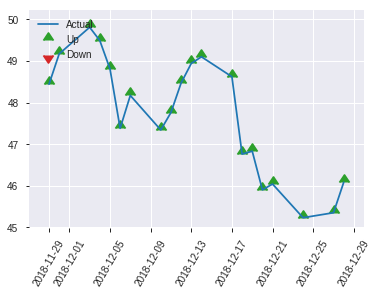


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.256015077801832
RMSE: 0.5059793254687706
LogLoss: 0.7058914601781751
Mean Per-Class Error: 0.45680076628352495
AUC: 0.5217752234993615
pr_auc: 0.5355723508601483
Gini: 0.0435504469987229
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33031582832336426: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   103  0.8879   (103.0/116.0)
1      5    130  0.037    (5.0/135.0)
Total  18   233  0.4303   (108.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.330316     0.706522  232
max f2                       0.267582     0.855513  248
max f0point5                 0.330316     0.609185  232
max accuracy                 0.330316     0.569721  232
max precision                0.661861     0.666667  5
max recall                   0.267582     1         248
max specificity              0.709861     0.991379  0
max absolute_mcc             0.330316     0.144987  232
max min_per_class_accuracy   0.512209     0.518519  124
max mean_per_class_accuracy  0.496998     0.543199  134

Gains/Lift Table: Avg response rate: 53.78 %, avg score: 49.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.673443           0.619753  0.619753           0.333333         0.693915  0.333333                    0.693915            0.00740741      0.00740741                 -38.0247  -38.0247
    2        0.0239044                   0.661861           1.85926   1.23951            1                0.668397  0.666667                    0.681156            0.0222222       0.0296296                  85.9259   23.9506
    3        0.0318725                   0.654587           0         0.92963            0                0.656872  0.5                         0.675085            0               0.0296296                  -100      -7.03704
    4        0.0438247                   0.644251           0.619753  0.845118           0.333333         0.648936  0.454545                    0.667953            0.00740741      0.037037                   -38.0247  -15.4882
    5        0.0517928                   0.641448           0         0.7151             0                0.642394  0.384615                    0.664021            0               0.037037                   -100      -28.49
    6        0.103586                    0.622885           0.85812   0.78661            0.461538         0.63085   0.423077                    0.647436            0.0444444       0.0814815                  -14.188   -21.339
    7        0.151394                    0.596424           1.08457   0.880702           0.583333         0.608686  0.473684                    0.635199            0.0518519       0.133333                   8.45679   -11.9298
    8        0.203187                    0.58211            1.14416   0.947858           0.615385         0.589719  0.509804                    0.623606            0.0592593       0.192593                   14.416    -5.21423
    9        0.302789                    0.554995           1.2643    1.05195            0.68             0.567881  0.565789                    0.605275            0.125926        0.318519                   26.4296   5.19493
    10       0.40239                     0.534078           1.11556   1.06769            0.6              0.543508  0.574257                    0.589986            0.111111        0.42963                    11.5556   6.76934
    11       0.501992                    0.510945           0.892444  1.03292            0.48             0.523198  0.555556                    0.576735            0.0888889       0.518519                   -10.7556  3.29218
    12       0.601594                    0.484521           1.04119   1.03429            0.56             0.494585  0.556291                    0.563134            0.103704        0.622222                   4.11852   3.42899
    13       0.701195                    0.454964           0.966815  1.02471            0.52             0.469903  0.551136                    0.549891            0.0962963       0.718519                   -3.31852  2.47054
    14       0.800797                    0.408757           0.966815  1.01751            0.52             0.431561  0.547264                    0.535173            0.0962963       0.814815                   -3.31852  1.75051
    15       0.900398                    0.357993           1.04119   1.02012            0.56             0.38682   0.548673                    0.518762            0.103704        0.918519                   4.11852   2.01245
    16       1                           0.22398            0.818074  1                  0.44             0.305805  0.537849                    0.497551     

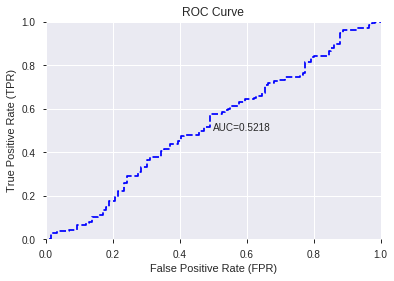

This function is available for GLM models only


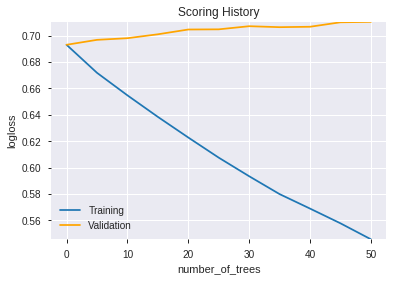

--2019-08-27 19:07:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.176.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.176.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


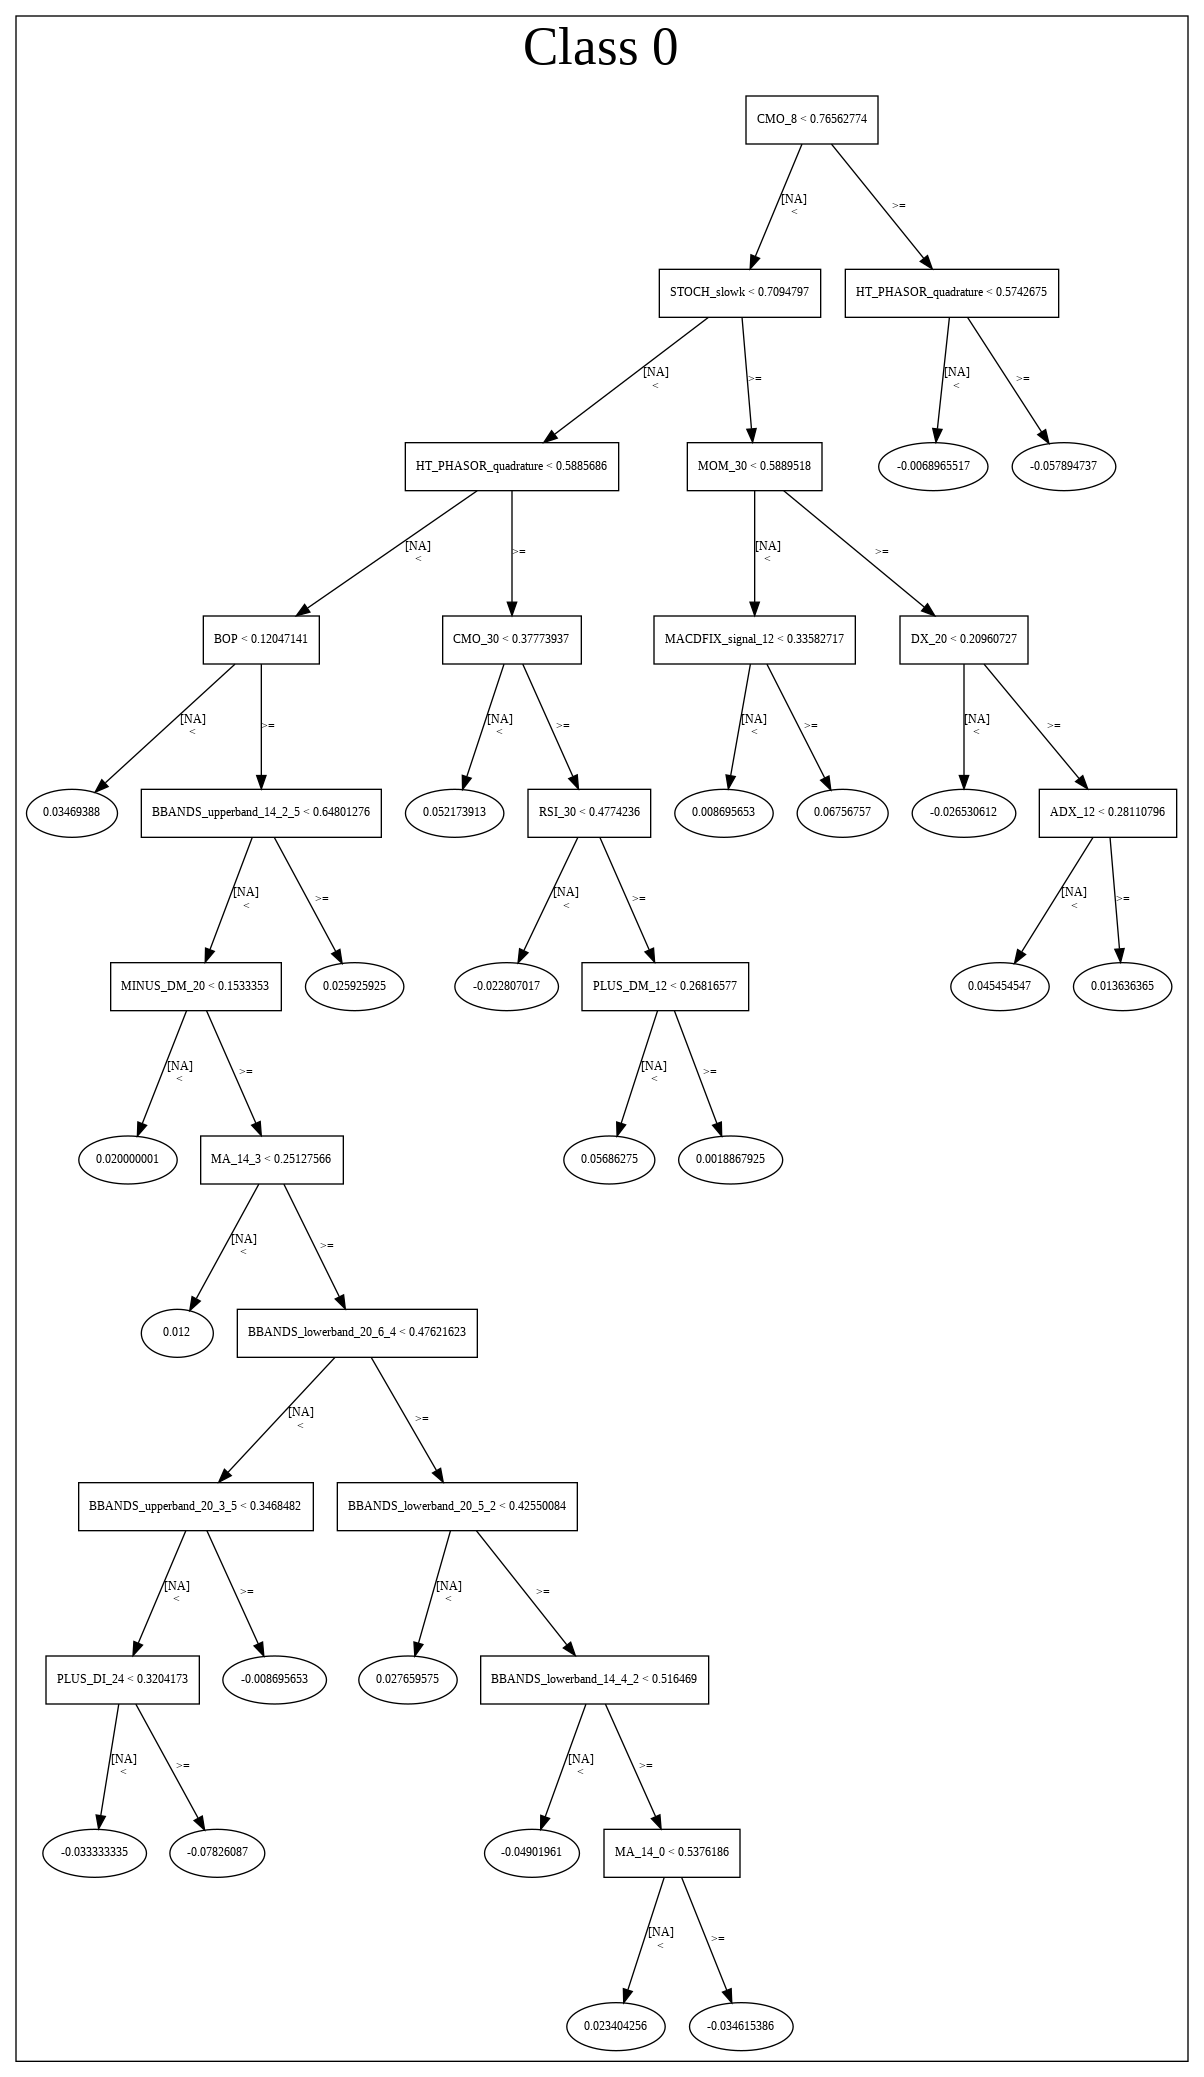

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190827_190643',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190827_190643',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_9b73',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_9b73',
   'ty

['BOP',
 'STOCHRSI_fastk',
 'HT_PHASOR_quadrature',
 'CCI_24',
 'TRANGE',
 'BETA_8',
 'MFI_24',
 'HT_PHASOR_inphase',
 'MINUS_DI_14',
 'ADXR_14',
 'PLUS_DM_12',
 'ADOSC',
 'PLUS_DI_14',
 'WILLR_14',
 'STOCH_slowd',
 'DX_8',
 'MOM_8',
 'WILLR_12',
 'PLUS_DM_30',
 'ADX_24',
 'ROC_20',
 'DX_12',
 'STOCH_slowk',
 'ATR_8',
 'DX_20',
 'SAR_0.14',
 'MINUS_DM_20',
 'MOM_30',
 'BBANDS_upperband_12_7_5',
 'ROC_14',
 'CCI_14',
 'PLUS_DI_8',
 'ADX_20',
 'MINUS_DI_20',
 'ADXR_8',
 'MACDFIX_8',
 'AROONOSC_30',
 'MINUS_DM_8',
 'PLUS_DI_12',
 'MACDFIX_signal_24',
 'AROONOSC_12',
 'MFI_8',
 'ROC_30',
 'ADX_12',
 'BBANDS_upperband_12_7_3',
 'MACDFIX_signal_12',
 'CCI_12',
 'MFI_14',
 'MINUS_DI_8',
 'DX_14',
 'PLUS_DM_14',
 'BBANDS_lowerband_24_2_4',
 'PLUS_DI_20',
 'MOM_12',
 'BBANDS_lowerband_14_1_4',
 'MINUS_DM_24',
 'WILLR_8',
 'ROCR100_24',
 'NATR_8',
 'CMO_8',
 'PLUS_DM_24',
 'BBANDS_upperband_14_5_5',
 'BBANDS_lowerband_20_3_5',
 'WILLR_24',
 'ROCR_12',
 'BBANDS_lowerband_20_1_5',
 'MFI_20',
 'MOM

In [54]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [55]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.590
GLM             0.574
XGBoost         0.570
dtype: float64

DeepLearning    GLM  XGBoost
All          0.590  0.546    0.554
DLF          0.570  0.574    0.546
Fwe          0.566  0.546    0.554
RFE          0.590  0.562    0.570
XGBF         0.570  0.574    0.546





F1


DeepLearning    0.711
GLM             0.713
XGBoost         0.707
dtype: float64

DeepLearning    GLM  XGBoost
All          0.711  0.702    0.705
DLF          0.708  0.713    0.701
Fwe          0.702  0.702    0.705
RFE          0.707  0.709    0.707
XGBF         0.707  0.713    0.701





auc


DeepLearning    0.581
GLM             0.529
XGBoost         0.537
dtype: float64

DeepLearning    GLM  XGBoost
All          0.581  0.474    0.537
DLF          0.549  0.529    0.536
Fwe          0.569  0.474    0.537
RFE          0.581  0.507    0.522
XGBF         0.547  0.529    0.536





logloss


DeepLearning    1.098
GLM             0.696
XGBoost         0.706
dtype: float64

DeepLearning    GLM  XGBoost
All          0.790  0.696    0.703
DLF          0.703  0.688    0.691
Fwe          0.689  0.696    0.703
RFE          1.098  0.693    0.706
XGBF         1.030  0.688    0.691





mean_per_class_error


DeepLearning    0.449
GLM             0.477
XGBoost         0.457
dtype: float64

DeepLearning    GLM  XGBoost
All          0.411  0.477    0.449
DLF          0.447  0.446    0.433
Fwe          0.435  0.477    0.449
RFE          0.405  0.465    0.457
XGBF         0.449  0.446    0.433





rmse


DeepLearning    0.609
GLM             0.501
XGBoost         0.506
dtype: float64

DeepLearning    GLM  XGBoost
All          0.531  0.501    0.505
DLF          0.503  0.497    0.499
Fwe          0.498  0.501    0.505
RFE          0.609  0.500    0.506
XGBF         0.530  0.497    0.499





mse


DeepLearning    0.371
GLM             0.251
XGBoost         0.256
dtype: float64

DeepLearning    GLM  XGBoost
All          0.282  0.251    0.255
DLF          0.253  0.247    0.249
Fwe          0.248  0.251    0.255
RFE          0.371  0.250    0.256
XGBF         0.281  0.247    0.249

{'F1':       DeepLearning    GLM  XGBoost
 All          0.711    NaN      NaN
 DLF          0.708    NaN      NaN
 DLF            NaN  0.713      NaN
 DLF            NaN    NaN    0.701
 All            NaN  0.702      NaN
 All            NaN    NaN    0.705
 XGBF         0.707    NaN      NaN
 XGBF           NaN  0.713      NaN
 XGBF           NaN    NaN    0.701
 Fwe          0.702    NaN      NaN
 Fwe            NaN  0.702      NaN
 Fwe            NaN    NaN    0.705
 RFE          0.707    NaN      NaN
 RFE            NaN  0.709      NaN
 RFE            NaN    NaN    0.707,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.590    NaN      NaN
 DLF          0.570    NaN      NaN
 DLF            NaN  0.574      NaN
 DLF            NaN    NaN    0.546
 All            NaN  0.546      NaN
 All            NaN    NaN    0.554
 XGBF         0.570    NaN      NaN
 XGBF           NaN  0.574      NaN
 XGBF           NaN    NaN    0.546
 Fwe          0.566    NaN      NaN
 Fwe     